In [1]:
import os

QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99] 

SPLIT = 0.9         # train/test %

FIGSIZE = (9, 6)


qL1, qL2 = 0.01, 0.10        # percentiles of predictions: lower bounds
qU1, qU2 = 1-qL1, 1-qL2,     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import missingno as mno
import pywt
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)
import random
import numpy as np
import torch
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, NBEATSModel, NHiTSModel, XGBModel, RNNModel, BlockRNNModel
from darts.models import AutoARIMA, LinearRegressionModel, RegressionEnsembleModel
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.metrics import mape, rmse, smape
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.tuner import lr_finder
import pytorch_lightning as pl
pl.seed_everything(42)
pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
xls = pd.ExcelFile('df_radon_combined.xlsx')

df_radon = {}
for num in xls.sheet_names[2:]:
    df_radon[num] = pd.read_excel(xls, num) 

#remove these indexes
devices = ['1', '2', '5', '9', '17', '23', '27', '28', '36', '44', '48']
for key in list(df_radon):
    if key in devices:
        del df_radon[key]

for key in df_radon:
    print(key)
    df_radon[key]['SyncDate'] = pd.to_datetime(df_radon[key]['SyncDate'])
    print(f"{df_radon[key]['SyncDate'].min()} - {df_radon[key]['SyncDate'].max()}")
    df_radon[key].sort_values(by='SyncDate', ascending=True, inplace=True)
    df_radon[key]['SyncDate'] = df_radon[key]['SyncDate'].dt.floor('H')
    df_radon[key] = df_radon[key].resample('H', on = 'SyncDate').mean()
    df_radon[key] = df_radon[key].interpolate(method='linear', limit_direction='both')
    start_time = pd.to_datetime('2022-05-11T18:29:00.000000000')
    end_time = pd.to_datetime('2023-06-06T12:00:00.000000000')
    df_radon[key] = df_radon[key][(df_radon[key].index >= start_time) & (df_radon[key].index <= end_time)]
    print(f"{df_radon[key].index.min()} - {df_radon[key].index.max()}")

3
2022-05-08 00:16:30 - 2023-06-06 12:25:38
2022-05-11 19:00:00 - 2023-06-06 12:00:00
4
2022-05-08 00:17:23 - 2023-06-06 12:26:06
2022-05-11 19:00:00 - 2023-06-06 12:00:00
7
2022-04-01 10:18:57 - 2023-06-06 12:30:25
2022-05-11 19:00:00 - 2023-06-06 12:00:00
8
2022-04-04 18:52:46 - 2023-06-06 12:27:12
2022-05-11 19:00:00 - 2023-06-06 12:00:00
10
2022-05-08 00:56:00 - 2023-06-06 23:02:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
11
2022-05-08 00:50:01 - 2023-06-07 12:13:32
2022-05-11 19:00:00 - 2023-06-06 12:00:00
13
2022-05-08 00:33:33 - 2023-06-06 23:09:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
15
2022-05-08 00:39:00 - 2023-06-06 23:59:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
16
2022-05-08 00:47:00 - 2023-06-06 23:00:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
18
2022-05-08 00:49:00 - 2023-06-06 23:07:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
19
2022-05-08 00:51:00 - 2023-06-06 23:36:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
20
2022-05-08 00:54:00 - 2023-06-07 12:40:49
20

# Radon 45

In [4]:
df = df_radon['45'].copy()

In [5]:
# Denoising the Radon signal
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [6]:
def wavelet_denoising(x, wavelet='db4', level=5):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    n = len(x) 
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    if len(x) % 2 ==0:
        return pywt.waverec(coeff, wavelet, mode='per')
    else:
        return pywt.waverec(coeff, wavelet, mode='per')[:n]

In [7]:
signal = df['Radon'].copy()
wavelet_name='coif9'
filtered = wavelet_denoising(signal, wavelet=wavelet_name, level=4)
df['Radon'] = filtered

In [8]:
# create time series object for target variable
ts_P = TimeSeries.from_series(df["Radon"], fill_missing_dates=True, freq="H") 

# check attributes of the time series
print("components:", ts_P.components)
print("duration:",ts_P.duration)
print("frequency:",ts_P.freq)
print("frequency:",ts_P.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_P.has_datetime_index)
print("deterministic:",ts_P.is_deterministic)
print("univariate:",ts_P.is_univariate)

components: Index(['Radon'], dtype='object', name='component')
duration: 390 days 17:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [9]:
# train/test split and scaling of target variable
ts_train, ts_test = ts_P.split_after(split_point=9210)

print("training start:", ts_train.start_time())
print("training end:", ts_train.end_time())
print("training duration:",ts_train.duration)
print("test start:", ts_test.start_time())
print("test end:", ts_test.end_time())
print("test duration:", ts_test.duration)


scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_ttest = scalerP.transform(ts_test)    
ts_t = scalerP.transform(ts_P)

# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)

print("first and last row of scaled Radon time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t.pd_dataframe().iloc[[0,-1]]

training start: 2022-05-11 19:00:00
training end: 2023-05-30 13:00:00
training duration: 383 days 18:00:00
test start: 2023-05-30 14:00:00
test end: 2023-06-06 12:00:00
test duration: 6 days 22:00:00
first and last row of scaled Radon time series:


component            Radon
SyncDate                  
2022-05-11 19:00:00   0.04
2023-06-06 12:00:00   0.05

In [10]:
print("first and last row of scaled target variable in training set: price:")
ts_ttrain.pd_dataframe().iloc[[0,-1]]

first and last row of scaled target variable in training set: price:


component            Radon
SyncDate                  
2022-05-11 19:00:00   0.04
2023-05-30 13:00:00   0.07

In [11]:
import torch
from ray.air import session
from darts.utils.losses import SmapeLoss
from torchmetrics import MetricCollection, SymmetricMeanAbsolutePercentageError, MeanAbsolutePercentageError
def build_fit_transformer_model(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1

    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "gpus":-1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
            "enable_progress_bar": False,
        }


    model = TransformerModel(
        input_chunk_length=model_args['in_len'],
        output_chunk_length=model_args['out_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name="Transformer",
        d_model=model_args['d_model'],
        nhead=model_args['nhead'],
        loss_fn=SmapeLoss(),
        norm_type=model_args['norm_type'],
        num_encoder_layers=model_args['num_encoder_layers'],
        num_decoder_layers=model_args['num_decoder_layers'],
        dim_feedforward=model_args['dim_feedforward'],
        dropout=model_args['dropout'],
        activation=model_args['activation'],
        #likelihood=QuantileRegression(quantiles=QUANTILES),
        optimizer_kwargs={'lr': model_args['lr']},
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                val_series=val_series,
               )
#     model.load_from_checkpoint(f"{model_args['model']} RNN model", best=True)
    ts_tpred = model.predict(
                series = ts_ttrain,
                n = len(ts_ttest),
                verbose=True
    )
    ts_q = scalerP.inverse_transform(ts_tpred)
    q_smape = smape(ts_q, ts_test)
    session.report({'q_smape': q_smape})

In [12]:
def build_fit_transformer_model_return(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1

    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "devices":1,
            'callbacks': callbacks,
        }



    model = TransformerModel(
        input_chunk_length=model_args['in_len'],
        output_chunk_length=model_args['out_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name="Transformer",
        d_model=model_args['d_model'],
        nhead=model_args['nhead'],
        loss_fn=SmapeLoss(),
        norm_type=model_args['norm_type'],
        num_encoder_layers=model_args['num_encoder_layers'],
        num_decoder_layers=model_args['num_decoder_layers'],
        dim_feedforward=model_args['dim_feedforward'],
        dropout=model_args['dropout'],
        activation=model_args['activation'],
        #likelihood=QuantileRegression(quantiles=QUANTILES),
        optimizer_kwargs={'lr': model_args['lr']},
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                
                val_series=val_series,
                )
#     if save_model:
#         print("have saved the model after training:", mpath)
#         model.save_model(mpath)
    return model

In [13]:
from ray import tune
from ray.tune import CLIReporter
# from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler, AsyncHyperBandScheduler
from ray.tune.search.optuna import OptunaSearch
from ray.tune.search import ConcurrencyLimiter
# tune_callback = TuneReportCallback(
#     {
#         "loss":"val_loss",
#         "sMAPE": "val_SymmetricMeanAbsolutePercentageError",
#     },
#     on="validation_end",
# )

early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )

#define the hyperparameter search space
config = {
    "batch_size": tune.choice([32,64,128]),
    "in_len": tune.randint(8,168),
    "out_len":tune.randint(1,24),
    "d_model":tune.choice([32,64,128,256]),
    "nhead":tune.choice([2,4,8]),
    "num_encoder_layers":tune.choice([1,2,3,4,5,6]),
    "num_decoder_layers":tune.choice([1,2,3,4,5,6]),
    "dim_feedforward":tune.choice([32,64,128,256]),
    "dropout":tune.uniform(0.1,0.5),
    "activation":tune.choice(["GLU", "Bilinear", "ReGLU", "GEGLU", "SwiGLU", "ReLU", "GELU"]),
    "norm_type":tune.choice([None,"LayerNorm", "RMSNorm", "LayerNormNoBias"]),
    "lr":tune.loguniform(1e-5,1e-1),
    
}

reporter = CLIReporter(
    parameter_columns=list(config.keys()),
    metric_columns=["q_smape"])
resources_per_trial = {"cpu": 5, "gpu": 0.4}

num_samples = 100

algo = OptunaSearch()

algo = ConcurrencyLimiter(algo, max_concurrent=10)

scheduler = AsyncHyperBandScheduler(max_t=100, grace_period=10, reduction_factor=2)

train_fn_with_parameters = tune.with_parameters(build_fit_transformer_model, callbacks=[early_stopper])

analysis = tune.run(
    train_fn_with_parameters,
    resources_per_trial=resources_per_trial,
    metric="q_smape",
    mode="min",
    config=config,
    num_samples=num_samples,
    search_alg=algo,
    scheduler = scheduler,
    progress_reporter=reporter,
    name="trasnformer_tune_cov",

)

print("Best hyperparameters found were: ", analysis.best_config)

== Status ==
Current time: 2023-07-08 03:58:00 (running for 00:00:00.15)
Memory usage on this node: 20.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 1/100 (1 RUNNING)
+--------------------------------------+----------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------------------+-------------------+-----------+--------------+-------------+------------+
| Trial name                           | status   | loc                  |   batch_size |   in_len |   out_len |   d_model |   nhead |   num_encoder_layers |   num_decoder_layers |   dim_feedforward |   dropout | activation   | norm_type   |         lr |
|--------------------------------

(build_fit_transformer_model pid=1145058) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1145058)   rank_zero_deprecation(
(build_fit_transformer_model pid=1145058) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1145058)   rank_zero_deprecation(
(build_fit_transformer_model pid=1145058) Auto select gpus: [0]
(build_fit_transformer_model pid=1145058) GPU available: True (cuda), used: True
(build_fit_t

== Status ==
Current time: 2023-07-08 03:58:10 (running for 00:00:09.50)
Memory usage on this node: 25.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+--------------------------------------+----------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------------------+-------------------+-----------+--------------+-----------------+-------------+
| Trial name                           | status   | loc                  |   batch_size |   in_len |   out_len |   d_model |   nhead |   num_encoder_layers |   num_decoder_layers |   dim_feedforward |   dropout | activation   | norm_type       |          l

(build_fit_transformer_model pid=1145308) Auto select gpus: [0]
(build_fit_transformer_model pid=1145308) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1145308) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1145308) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1145308) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1145308) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1145308) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1145308) 
(build_fit_transformer_model pid=1145308)   | Name                | Type                | Param

(build_fit_transformer_model pid=1145308) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1145308)   rank_zero_warn(
(build_fit_transformer_model pid=1145308) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1145308)   rank_zero_warn(
(build_fit_transformer_model pid=1145308) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. Y

(build_fit_transformer_model pid=1145311) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1145311)   rank_zero_warn(
(build_fit_transformer_model pid=1145311) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1145311)   rank_zero_warn(


== Status ==
Current time: 2023-07-08 03:58:15 (running for 00:00:14.51)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+--------------------------------------+----------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------------------+-------------------+-----------+--------------+-----------------+-------------+
| Trial name                           | status   | loc                  |   batch_size |   in_len |   out_len |   d_model |   nhead |   num_encoder_layers |   num_decoder_layers |   dim_feedforward |   dropout | activation   | norm_type       |          l

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 42.93it/s]


(build_fit_transformer_model pid=1145058) Auto select gpus: [0]
(build_fit_transformer_model pid=1145058) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1145058) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1145058) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1145058) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1145058) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1145058) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1146934) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelera

== Status ==
Current time: 2023-07-08 03:58:34 (running for 00:00:33.51)
Memory usage on this node: 36.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b860f9fd with q_smape=48.15470913728238 and parameters={'batch_size': 128, 'in_len': 157, 'out_len': 16, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 2, 'dim_feedforward': 128, 'dropout': 0.4368504507701949, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 9.747797699652576e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 10/100 (1 PENDING, 8 RUNNING, 1 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+------

(build_fit_transformer_model pid=1145308) Auto select gpus: [0]
(build_fit_transformer_model pid=1145308) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1145308) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1145308) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1145308) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1145308) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1145308) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1146934) Auto select gpus: [0]
(build_fit_transformer_model pid=1146934) GPU available: True (cuda), used

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1145301) Auto select gpus: [0]
(build_fit_transformer_model pid=1145301) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1145301) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1145301) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1145301) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1145301) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1145301) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1146934) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWar

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.47it/s]


(build_fit_transformer_model pid=1146934) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1146934)   rank_zero_warn(
(build_fit_transformer_model pid=1146934) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1146934)   rank_zero_warn(
(build_fit_transformer_model pid=1145314) Auto select gpus: [0]
(build_fit_transformer_model pid=1145314) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1145314) TPU available: False, using: 0 TPU cores
(build_fit_transforme

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.46it/s]


(build_fit_transformer_model pid=1147171) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1147171)   rank_zero_deprecation(
(build_fit_transformer_model pid=1147171) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1147171)   rank_zero_deprecation(
(build_fit_transformer_model pid=1147344) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:47

(build_fit_transformer_model pid=1147171) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1147171)   rank_zero_warn(
(build_fit_transformer_model pid=1147171) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1147171)   rank_zero_warn(
(build_fit_transformer_model pid=1147171) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. Y

== Status ==
Current time: 2023-07-08 03:58:43 (running for 00:00:42.52)
Memory usage on this node: 36.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b860f9fd with q_smape=48.15470913728238 and parameters={'batch_size': 128, 'in_len': 157, 'out_len': 16, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 2, 'dim_feedforward': 128, 'dropout': 0.4368504507701949, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 9.747797699652576e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 14/100 (1 PENDING, 8 RUNNING, 5 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+------

(build_fit_transformer_model pid=1147674) Auto select gpus: [0]
(build_fit_transformer_model pid=1147674) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1147674) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1147674) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1147674) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1147674) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1147674) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_transformer_model pid=1147674) 
(build_fit_transformer_model pid=1147674)   | Name                | Type                | Param

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.31it/s]


(build_fit_transformer_model pid=1147674) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1147674)   rank_zero_warn(
(build_fit_transformer_model pid=1147674) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1147674)   rank_zero_warn(
(build_fit_transformer_model pid=1147674) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. Y

== Status ==
Current time: 2023-07-08 03:58:51 (running for 00:00:50.53)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b860f9fd with q_smape=48.15470913728238 and parameters={'batch_size': 128, 'in_len': 157, 'out_len': 16, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 2, 'dim_feedforward': 128, 'dropout': 0.4368504507701949, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 9.747797699652576e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 15/100 (1 PENDING, 8 RUNNING, 6 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+------

(build_fit_transformer_model pid=1148139) Auto select gpus: [0]
(build_fit_transformer_model pid=1148139) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1148139) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1148139) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1148139) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1148139) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1148139) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1148139) 
(build_fit_transformer_model pid=1148139)   | Name                | Type                | Param

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.93it/s]


(build_fit_transformer_model pid=1147674) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_transformer_model pid=1148139) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1148139)   rank_zero_warn(
(build_fit_transformer_model pid=1148139) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1148139)   rank_zero_warn(
(build_fit_transformer_model pid=1148139) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('tra

== Status ==
Current time: 2023-07-08 03:58:57 (running for 00:00:56.52)
Memory usage on this node: 36.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b860f9fd with q_smape=48.15470913728238 and parameters={'batch_size': 128, 'in_len': 157, 'out_len': 16, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 2, 'dim_feedforward': 128, 'dropout': 0.4368504507701949, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 9.747797699652576e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 16/100 (1 PENDING, 8 RUNNING, 7 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+------

(build_fit_transformer_model pid=1148378) Auto select gpus: [0]
(build_fit_transformer_model pid=1148378) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1148378) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1148378) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1148378) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1148378) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1148378) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_transformer_model pid=1148378) 
(build_fit_transformer_model pid=1148378)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 03:59:02 (running for 00:01:01.53)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b860f9fd with q_smape=48.15470913728238 and parameters={'batch_size': 128, 'in_len': 157, 'out_len': 16, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 2, 'dim_feedforward': 128, 'dropout': 0.4368504507701949, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 9.747797699652576e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 16/100 (1 PENDING, 8 RUNNING, 7 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+------

(build_fit_transformer_model pid=1146934) Auto select gpus: [0]
(build_fit_transformer_model pid=1146934) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1146934) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1146934) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1146934) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1146934) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1146934) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


(build_fit_transformer_model pid=1148631) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1148631)   rank_zero_deprecation(
(build_fit_transformer_model pid=1148631) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1148631)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 03:59:09 (running for 00:01:08.53)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b860f9fd with q_smape=48.15470913728238 and parameters={'batch_size': 128, 'in_len': 157, 'out_len': 16, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 2, 'dim_feedforward': 128, 'dropout': 0.4368504507701949, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 9.747797699652576e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 17/100 (1 PENDING, 8 RUNNING, 8 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+------

(build_fit_transformer_model pid=1148631) Auto select gpus: [0]
(build_fit_transformer_model pid=1148631) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1148631) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1148631) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1148631) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1148631) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1148631) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1148631) 
(build_fit_transformer_model pid=1148631)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 03:59:14 (running for 00:01:13.53)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b860f9fd with q_smape=48.15470913728238 and parameters={'batch_size': 128, 'in_len': 157, 'out_len': 16, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 2, 'dim_feedforward': 128, 'dropout': 0.4368504507701949, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 9.747797699652576e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 17/100 (1 PENDING, 8 RUNNING, 8 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+------

(build_fit_transformer_model pid=1147344) Auto select gpus: [0]
(build_fit_transformer_model pid=1147344) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1147344) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1147344) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1147344) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1147344) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1147344) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1148879) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelera

== Status ==
Current time: 2023-07-08 03:59:23 (running for 00:01:22.53)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b860f9fd with q_smape=48.15470913728238 and parameters={'batch_size': 128, 'in_len': 157, 'out_len': 16, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 2, 'dim_feedforward': 128, 'dropout': 0.4368504507701949, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 9.747797699652576e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 18/100 (1 PENDING, 8 RUNNING, 9 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+------

(build_fit_transformer_model pid=1148879) Auto select gpus: [0]
(build_fit_transformer_model pid=1148879) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1148879) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1148879) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1148879) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1148879) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1148879) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1148879) 
(build_fit_transformer_model pid=1148879)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 03:59:28 (running for 00:01:27.54)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b860f9fd with q_smape=48.15470913728238 and parameters={'batch_size': 128, 'in_len': 157, 'out_len': 16, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 2, 'dim_feedforward': 128, 'dropout': 0.4368504507701949, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 9.747797699652576e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 18/100 (1 PENDING, 8 RUNNING, 9 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


(build_fit_transformer_model pid=1145303) Auto select gpus: [0]
(build_fit_transformer_model pid=1145303) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1145303) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1145303) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1145303) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1145303) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1145303) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1148631) Auto select gpus: [0]
(build_fit_transformer_model pid=1148631) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1148631) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1148631) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1148631) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1148631) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1148631) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]
== Status ==
Current time: 2023-07-08 03:59:39 (running for 00:01:38.82)
Memory usage on this node: 35.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b860f9fd with q_smape=48.15470913728238 and parameters={'batch_size': 128, 'in_len': 157, 'out_len': 16, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 2, 'dim_feedforward': 128, 'dropout': 0.4368504507701949, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 9.747797699652576e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 19/100 (1 PENDING, 8 RUNNING, 10 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+--

(build_fit_transformer_model pid=1149127) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1149127)   rank_zero_deprecation(
(build_fit_transformer_model pid=1149127) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1149127)   rank_zero_deprecation(


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1147342) Auto select gpus: [0]
(build_fit_transformer_model pid=1147342) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1147342) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1147342) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1147342) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1147342) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1147342) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


(build_fit_transformer_model pid=1149127) Auto select gpus: [0]
(build_fit_transformer_model pid=1149127) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1149127) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1149127) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1149127) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1149127) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1149127) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1149127) 
(build_fit_transformer_model pid=1149127)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 03:59:47 (running for 00:01:46.56)
Memory usage on this node: 36.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b860f9fd with q_smape=48.15470913728238 and parameters={'batch_size': 128, 'in_len': 157, 'out_len': 16, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 2, 'dim_feedforward': 128, 'dropout': 0.4368504507701949, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 9.747797699652576e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

(build_fit_transformer_model pid=1148879) Auto select gpus: [0]
(build_fit_transformer_model pid=1148879) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1148879) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1148879) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1148879) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1148879) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1148879) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.95it/s]


(build_fit_transformer_model pid=1149529) Auto select gpus: [0]
(build_fit_transformer_model pid=1149529) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1149529) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1149529) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1149529) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1149529) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1149529) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1149529) 
(build_fit_transformer_model pid=1149529)   | Name                | Type                | Param

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


(build_fit_transformer_model pid=1149850) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1149850)   rank_zero_deprecation(
(build_fit_transformer_model pid=1149850) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1149850)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 03:59:52 (running for 00:01:52.21)
Memory usage on this node: 36.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b860f9fd with q_smape=48.15470913728238 and parameters={'batch_size': 128, 'in_len': 157, 'out_len': 16, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 2, 'dim_feedforward': 128, 'dropout': 0.4368504507701949, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 9.747797699652576e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 22/100 (1 PENDING, 8 RUNNING, 13 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

(build_fit_transformer_model pid=1149850) Auto select gpus: [0]
(build_fit_transformer_model pid=1149850) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1149850) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1149850) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1149850) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1149850) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1148139) Auto select gpus: [0]
(build_fit_transformer_model pid=1148139) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1148139) TPU available: False, using: 0 TPU 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]


(build_fit_transformer_model pid=1149850) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1149850)   rank_zero_warn(
(build_fit_transformer_model pid=1149850) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1149850)   rank_zero_warn(
(build_fit_transformer_model pid=1149850) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. Y

== Status ==
Current time: 2023-07-08 03:59:59 (running for 00:01:58.55)
Memory usage on this node: 35.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b860f9fd with q_smape=48.15470913728238 and parameters={'batch_size': 128, 'in_len': 157, 'out_len': 16, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 2, 'dim_feedforward': 128, 'dropout': 0.4368504507701949, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 9.747797699652576e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 24/100 (1 PENDING, 8 RUNNING, 15 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

(build_fit_transformer_model pid=1150296) Auto select gpus: [0]
(build_fit_transformer_model pid=1150296) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1150296) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1150296) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1150296) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1150296) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1150296) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1150296) 
(build_fit_transformer_model pid=1150296)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:00:04 (running for 00:02:03.56)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b860f9fd with q_smape=48.15470913728238 and parameters={'batch_size': 128, 'in_len': 157, 'out_len': 16, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 2, 'dim_feedforward': 128, 'dropout': 0.4368504507701949, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 9.747797699652576e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 24/100 (1 PENDING, 8 RUNNING, 15 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

== Status ==
Current time: 2023-07-08 04:00:14 (running for 00:02:13.57)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b860f9fd with q_smape=48.15470913728238 and parameters={'batch_size': 128, 'in_len': 157, 'out_len': 16, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 2, 'dim_feedforward': 128, 'dropout': 0.4368504507701949, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 9.747797699652576e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 24/100 (1 PENDING, 8 RUNNING, 15 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1145316) Auto select gpus: [0]
(build_fit_transformer_model pid=1145316) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1145316) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1145316) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1145316) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1145316) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1145316) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.82it/s]


(build_fit_transformer_model pid=1150634) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1150634)   rank_zero_deprecation(
(build_fit_transformer_model pid=1150634) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1150634)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:00:29 (running for 00:02:28.55)
Memory usage on this node: 36.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b860f9fd with q_smape=48.15470913728238 and parameters={'batch_size': 128, 'in_len': 157, 'out_len': 16, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 2, 'dim_feedforward': 128, 'dropout': 0.4368504507701949, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 9.747797699652576e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 25/100 (1 PENDING, 8 RUNNING, 16 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

(build_fit_transformer_model pid=1150634) Auto select gpus: [0]
(build_fit_transformer_model pid=1150634) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1150634) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1150634) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1150634) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1150634) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1150634) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_transformer_model pid=1150634) 
(build_fit_transformer_model pid=1150634)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:00:34 (running for 00:02:33.56)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b860f9fd with q_smape=48.15470913728238 and parameters={'batch_size': 128, 'in_len': 157, 'out_len': 16, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 2, 'dim_feedforward': 128, 'dropout': 0.4368504507701949, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 9.747797699652576e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 25/100 (1 PENDING, 8 RUNNING, 16 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1149366) Auto select gpus: [0]
(build_fit_transformer_model pid=1149366) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1149366) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1149366) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1149366) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1149366) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1149366) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.08it/s]


(build_fit_transformer_model pid=1150882) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1150882)   rank_zero_deprecation(
(build_fit_transformer_model pid=1150882) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1150882)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:00:45 (running for 00:02:44.55)
Memory usage on this node: 36.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9f9860da with q_smape=46.738980502962306 and parameters={'batch_size': 128, 'in_len': 166, 'out_len': 23, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 6, 'dim_feedforward': 64, 'dropout': 0.3724993744066069, 'activation': 'GEGLU', 'norm_type': 'RMSNorm', 'lr': 4.009528078412429e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

(build_fit_transformer_model pid=1150882) Auto select gpus: [0]
(build_fit_transformer_model pid=1150882) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1150882) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1150882) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1150882) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1150882) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1150882) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1150882) 
(build_fit_transformer_model pid=1150882)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:00:50 (running for 00:02:49.56)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9f9860da with q_smape=46.738980502962306 and parameters={'batch_size': 128, 'in_len': 166, 'out_len': 23, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 6, 'dim_feedforward': 64, 'dropout': 0.3724993744066069, 'activation': 'GEGLU', 'norm_type': 'RMSNorm', 'lr': 4.009528078412429e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

== Status ==
Current time: 2023-07-08 04:01:00 (running for 00:02:59.57)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9f9860da with q_smape=46.738980502962306 and parameters={'batch_size': 128, 'in_len': 166, 'out_len': 23, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 6, 'dim_feedforward': 64, 'dropout': 0.3724993744066069, 'activation': 'GEGLU', 'norm_type': 'RMSNorm', 'lr': 4.009528078412429e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

== Status ==
Current time: 2023-07-08 04:01:10 (running for 00:03:09.59)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9f9860da with q_smape=46.738980502962306 and parameters={'batch_size': 128, 'in_len': 166, 'out_len': 23, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 6, 'dim_feedforward': 64, 'dropout': 0.3724993744066069, 'activation': 'GEGLU', 'norm_type': 'RMSNorm', 'lr': 4.009528078412429e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

(build_fit_transformer_model pid=1150133) Auto select gpus: [0]
(build_fit_transformer_model pid=1150133) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1150133) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1150133) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1150133) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1150133) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1150133) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.42it/s]


(build_fit_transformer_model pid=1150296) Auto select gpus: [0]
(build_fit_transformer_model pid=1150296) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1150296) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1150296) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1150296) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1150296) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1150296) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


== Status ==
Current time: 2023-07-08 04:01:15 (running for 00:03:14.81)
Memory usage on this node: 35.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9f9860da with q_smape=46.738980502962306 and parameters={'batch_size': 128, 'in_len': 166, 'out_len': 23, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 6, 'dim_feedforward': 64, 'dropout': 0.3724993744066069, 'activation': 'GEGLU', 'norm_type': 'RMSNorm', 'lr': 4.009528078412429e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 27/100 (1 PENDING, 8 RUNNING, 18 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

(build_fit_transformer_model pid=1151189) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1151189)   rank_zero_deprecation(
(build_fit_transformer_model pid=1151189) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1151189)   rank_zero_deprecation(
(build_fit_transformer_model pid=1151189) Auto select gpus: [0]
(build_fit_transformer_model pid=1151189) GPU available: True (cuda), used: True
(build_fit_t

== Status ==
Current time: 2023-07-08 04:01:24 (running for 00:03:23.55)
Memory usage on this node: 36.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9f9860da with q_smape=46.738980502962306 and parameters={'batch_size': 128, 'in_len': 166, 'out_len': 23, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 6, 'dim_feedforward': 64, 'dropout': 0.3724993744066069, 'activation': 'GEGLU', 'norm_type': 'RMSNorm', 'lr': 4.009528078412429e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 28/100 (1 PENDING, 8 RUNNING, 19 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

(build_fit_transformer_model pid=1151467) Auto select gpus: [0]
(build_fit_transformer_model pid=1151467) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1151467) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1151467) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1151467) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1151467) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1151467) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1151467) 
(build_fit_transformer_model pid=1151467)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:01:29 (running for 00:03:28.57)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9f9860da with q_smape=46.738980502962306 and parameters={'batch_size': 128, 'in_len': 166, 'out_len': 23, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 6, 'dim_feedforward': 64, 'dropout': 0.3724993744066069, 'activation': 'GEGLU', 'norm_type': 'RMSNorm', 'lr': 4.009528078412429e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 28/100 (1 PENDING, 8 RUNNING, 19 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

== Status ==
Current time: 2023-07-08 04:01:39 (running for 00:03:38.58)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9f9860da with q_smape=46.738980502962306 and parameters={'batch_size': 128, 'in_len': 166, 'out_len': 23, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 6, 'dim_feedforward': 64, 'dropout': 0.3724993744066069, 'activation': 'GEGLU', 'norm_type': 'RMSNorm', 'lr': 4.009528078412429e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 28/100 (1 PENDING, 8 RUNNING, 19 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

== Status ==
Current time: 2023-07-08 04:01:49 (running for 00:03:48.60)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9f9860da with q_smape=46.738980502962306 and parameters={'batch_size': 128, 'in_len': 166, 'out_len': 23, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 6, 'dim_feedforward': 64, 'dropout': 0.3724993744066069, 'activation': 'GEGLU', 'norm_type': 'RMSNorm', 'lr': 4.009528078412429e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 28/100 (1 PENDING, 8 RUNNING, 19 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

(build_fit_transformer_model pid=1149529) Auto select gpus: [0]
(build_fit_transformer_model pid=1149529) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1149529) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1149529) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1149529) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1149529) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1149529) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.88it/s]


(build_fit_transformer_model pid=1151734) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1151734)   rank_zero_deprecation(
(build_fit_transformer_model pid=1151734) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1151734)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:02:02 (running for 00:04:01.56)
Memory usage on this node: 36.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9f9860da with q_smape=46.738980502962306 and parameters={'batch_size': 128, 'in_len': 166, 'out_len': 23, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 6, 'dim_feedforward': 64, 'dropout': 0.3724993744066069, 'activation': 'GEGLU', 'norm_type': 'RMSNorm', 'lr': 4.009528078412429e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 29/100 (1 PENDING, 8 RUNNING, 20 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

(build_fit_transformer_model pid=1151734) Auto select gpus: [0]
(build_fit_transformer_model pid=1151734) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1151734) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1151734) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1151734) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1151734) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1151734) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1151734) 
(build_fit_transformer_model pid=1151734)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:02:07 (running for 00:04:06.57)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9f9860da with q_smape=46.738980502962306 and parameters={'batch_size': 128, 'in_len': 166, 'out_len': 23, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 6, 'dim_feedforward': 64, 'dropout': 0.3724993744066069, 'activation': 'GEGLU', 'norm_type': 'RMSNorm', 'lr': 4.009528078412429e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 29/100 (1 PENDING, 8 RUNNING, 20 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

(build_fit_transformer_model pid=1149127) Auto select gpus: [0]
(build_fit_transformer_model pid=1149127) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1149127) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1149127) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1149127) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1149127) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1149127) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.40it/s]


(build_fit_transformer_model pid=1147171) Auto select gpus: [0]
(build_fit_transformer_model pid=1147171) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1147171) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1147171) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1147171) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1147171) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1147171) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.31it/s]
== Status ==
Current time: 2023-07-08 04:02:13 (running for 00:04:12.54)
Memory usage on this node: 35.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fb7adb91 with q_smape=42.14949251784342 and parameters={'batch_size': 32, 'in_len': 130, 'out_len': 20, 'd_model': 128, 'nhead': 8, 'num_encoder_layers': 2, 'num_decoder_layers': 5, 'dim_feedforward': 64, 'dropout': 0.16344965137104275, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.0003689591942298188}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 29/100 (8 RUNNING, 21 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-------

(build_fit_transformer_model pid=1151985) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1151985)   rank_zero_deprecation(
(build_fit_transformer_model pid=1151985) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1151985)   rank_zero_deprecation(
(build_fit_transformer_model pid=1151985) Auto select gpus: [0]
(build_fit_transformer_model pid=1151985) GPU available: True (cuda), used: True
(build_fit_t

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1150882) Auto select gpus: [0]
(build_fit_transformer_model pid=1150882) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1150882) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1150882) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1150882) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1150882) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1150882) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.63it/s]
== Status ==
Current time: 2023-07-08 04:02:20 (running for 00:04:19.67)
Memory usage on this node: 35.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fb7adb91 with q_smape=42.14949251784342 and parameters={'batch_size': 32, 'in_len': 130, 'out_len': 20, 'd_model': 128, 'nhead': 8, 'num_encoder_layers': 2, 'num_decoder_layers': 5, 'dim_feedforward': 64, 'dropout': 0.16344965137104275, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.0003689591942298188}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 31/100 (1 PENDING, 8 RUNNING, 22 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+-------

(build_fit_transformer_model pid=1152221) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1152221)   rank_zero_deprecation(
(build_fit_transformer_model pid=1152221) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1152221)   rank_zero_deprecation(
(build_fit_transformer_model pid=1152221) Auto select gpus: [0]
(build_fit_transformer_model pid=1152221) GPU available: True (cuda), used: True
(build_fit_t

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.40it/s]
== Status ==
Current time: 2023-07-08 04:02:28 (running for 00:04:27.59)
Memory usage on this node: 36.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fb7adb91 with q_smape=42.14949251784342 and parameters={'batch_size': 32, 'in_len': 130, 'out_len': 20, 'd_model': 128, 'nhead': 8, 'num_encoder_layers': 2, 'num_decoder_layers': 5, 'dim_feedforward': 64, 'dropout': 0.16344965137104275, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.0003689591942298188}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+-------

(build_fit_transformer_model pid=1152462) Auto select gpus: [0]
(build_fit_transformer_model pid=1152462) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1152462) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1152462) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1152462) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1152462) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1152462) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1152462) 
(build_fit_transformer_model pid=1152462)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:02:34 (running for 00:04:33.56)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fb7adb91 with q_smape=42.14949251784342 and parameters={'batch_size': 32, 'in_len': 130, 'out_len': 20, 'd_model': 128, 'nhead': 8, 'num_encoder_layers': 2, 'num_decoder_layers': 5, 'dim_feedforward': 64, 'dropout': 0.16344965137104275, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.0003689591942298188}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 33/100 (1 PENDING, 8 RUNNING, 24 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------

(build_fit_transformer_model pid=1152703) Auto select gpus: [0]
(build_fit_transformer_model pid=1152703) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1152703) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1152703) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1152703) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1152703) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1152703) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1152703) 
(build_fit_transformer_model pid=1152703)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:02:39 (running for 00:04:38.58)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fb7adb91 with q_smape=42.14949251784342 and parameters={'batch_size': 32, 'in_len': 130, 'out_len': 20, 'd_model': 128, 'nhead': 8, 'num_encoder_layers': 2, 'num_decoder_layers': 5, 'dim_feedforward': 64, 'dropout': 0.16344965137104275, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.0003689591942298188}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 33/100 (1 PENDING, 8 RUNNING, 24 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------

(build_fit_transformer_model pid=1151189) Auto select gpus: [0]
(build_fit_transformer_model pid=1151189) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1151189) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1151189) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1151189) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1151189) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1151189) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.46it/s]


(build_fit_transformer_model pid=1152949) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1152949)   rank_zero_deprecation(
(build_fit_transformer_model pid=1152949) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1152949)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:02:46 (running for 00:04:45.57)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fb7adb91 with q_smape=42.14949251784342 and parameters={'batch_size': 32, 'in_len': 130, 'out_len': 20, 'd_model': 128, 'nhead': 8, 'num_encoder_layers': 2, 'num_decoder_layers': 5, 'dim_feedforward': 64, 'dropout': 0.16344965137104275, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.0003689591942298188}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 34/100 (1 PENDING, 8 RUNNING, 25 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------

(build_fit_transformer_model pid=1152949) Auto select gpus: [0]
(build_fit_transformer_model pid=1152949) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1152949) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1152949) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1152949) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1152949) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1152949) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_transformer_model pid=1152949) 
(build_fit_transformer_model pid=1152949)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:02:51 (running for 00:04:50.58)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fb7adb91 with q_smape=42.14949251784342 and parameters={'batch_size': 32, 'in_len': 130, 'out_len': 20, 'd_model': 128, 'nhead': 8, 'num_encoder_layers': 2, 'num_decoder_layers': 5, 'dim_feedforward': 64, 'dropout': 0.16344965137104275, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.0003689591942298188}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 34/100 (1 PENDING, 8 RUNNING, 25 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------

(build_fit_transformer_model pid=1151734) Auto select gpus: [0]
(build_fit_transformer_model pid=1151734) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1151734) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1151734) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1151734) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1151734) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1151734) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.62it/s]


(build_fit_transformer_model pid=1153196) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1153196)   rank_zero_deprecation(
(build_fit_transformer_model pid=1153196) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1153196)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:02:58 (running for 00:04:57.57)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fb7adb91 with q_smape=42.14949251784342 and parameters={'batch_size': 32, 'in_len': 130, 'out_len': 20, 'd_model': 128, 'nhead': 8, 'num_encoder_layers': 2, 'num_decoder_layers': 5, 'dim_feedforward': 64, 'dropout': 0.16344965137104275, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.0003689591942298188}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------

(build_fit_transformer_model pid=1153196) Auto select gpus: [0]
(build_fit_transformer_model pid=1153196) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1153196) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1153196) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1153196) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1153196) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1153196) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1153196) 
(build_fit_transformer_model pid=1153196)   | Name                | Type                | Param

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.26it/s]


(build_fit_transformer_model pid=1153439) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1153439)   rank_zero_deprecation(
(build_fit_transformer_model pid=1153439) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1153439)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:03:06 (running for 00:05:05.58)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3799dffd with q_smape=25.888279492659965 and parameters={'batch_size': 128, 'in_len': 115, 'out_len': 23, 'd_model': 32, 'nhead': 4, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 256, 'dropout': 0.35940696319064425, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 2.464642724687303e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 36/100 (1 PENDING, 8 RUNNING, 27 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

(build_fit_transformer_model pid=1153439) Auto select gpus: [0]
(build_fit_transformer_model pid=1153439) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1153439) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1153439) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1153439) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1153439) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1153439) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_transformer_model pid=1153439) 
(build_fit_transformer_model pid=1153439)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:03:11 (running for 00:05:10.59)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3799dffd with q_smape=25.888279492659965 and parameters={'batch_size': 128, 'in_len': 115, 'out_len': 23, 'd_model': 32, 'nhead': 4, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 256, 'dropout': 0.35940696319064425, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 2.464642724687303e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 36/100 (1 PENDING, 8 RUNNING, 27 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

(build_fit_transformer_model pid=1151985) Auto select gpus: [0]
(build_fit_transformer_model pid=1151985) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1151985) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1151985) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1151985) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1151985) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1151985) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.15it/s]


(build_fit_transformer_model pid=1153690) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1153690)   rank_zero_deprecation(
(build_fit_transformer_model pid=1153690) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1153690)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:03:22 (running for 00:05:21.57)
Memory usage on this node: 36.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3799dffd with q_smape=25.888279492659965 and parameters={'batch_size': 128, 'in_len': 115, 'out_len': 23, 'd_model': 32, 'nhead': 4, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 256, 'dropout': 0.35940696319064425, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 2.464642724687303e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 37/100 (1 PENDING, 8 RUNNING, 28 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

(build_fit_transformer_model pid=1153690) Auto select gpus: [0]
(build_fit_transformer_model pid=1153690) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1153690) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1153690) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1153690) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1153690) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1153690) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1153690) 
(build_fit_transformer_model pid=1153690)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:03:27 (running for 00:05:26.59)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3799dffd with q_smape=25.888279492659965 and parameters={'batch_size': 128, 'in_len': 115, 'out_len': 23, 'd_model': 32, 'nhead': 4, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 256, 'dropout': 0.35940696319064425, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 2.464642724687303e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 37/100 (1 PENDING, 8 RUNNING, 28 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

== Status ==
Current time: 2023-07-08 04:03:37 (running for 00:05:36.61)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3799dffd with q_smape=25.888279492659965 and parameters={'batch_size': 128, 'in_len': 115, 'out_len': 23, 'd_model': 32, 'nhead': 4, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 256, 'dropout': 0.35940696319064425, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 2.464642724687303e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 37/100 (1 PENDING, 8 RUNNING, 28 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

== Status ==
Current time: 2023-07-08 04:03:47 (running for 00:05:46.63)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3799dffd with q_smape=25.888279492659965 and parameters={'batch_size': 128, 'in_len': 115, 'out_len': 23, 'd_model': 32, 'nhead': 4, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 256, 'dropout': 0.35940696319064425, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 2.464642724687303e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 37/100 (1 PENDING, 8 RUNNING, 28 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

== Status ==
Current time: 2023-07-08 04:03:57 (running for 00:05:56.65)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3799dffd with q_smape=25.888279492659965 and parameters={'batch_size': 128, 'in_len': 115, 'out_len': 23, 'd_model': 32, 'nhead': 4, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 256, 'dropout': 0.35940696319064425, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 2.464642724687303e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 37/100 (1 PENDING, 8 RUNNING, 28 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

(build_fit_transformer_model pid=1152949) Auto select gpus: [0]
(build_fit_transformer_model pid=1152949) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1152949) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1152949) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1152949) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1152949) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1152949) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.56it/s]


(build_fit_transformer_model pid=1153196) Auto select gpus: [0]
(build_fit_transformer_model pid=1153196) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1153196) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1153196) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1153196) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1153196) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1153196) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1153960) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelera

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.64it/s]
== Status ==
Current time: 2023-07-08 04:04:05 (running for 00:06:04.44)
Memory usage on this node: 35.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3799dffd with q_smape=25.888279492659965 and parameters={'batch_size': 128, 'in_len': 115, 'out_len': 23, 'd_model': 32, 'nhead': 4, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 256, 'dropout': 0.35940696319064425, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 2.464642724687303e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 39/100 (1 PENDING, 8 RUNNING, 30 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+--

(build_fit_transformer_model pid=1154121) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1154121)   rank_zero_deprecation(
(build_fit_transformer_model pid=1154121) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1154121)   rank_zero_deprecation(
(build_fit_transformer_model pid=1153960) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `s

== Status ==
Current time: 2023-07-08 04:04:11 (running for 00:06:10.60)
Memory usage on this node: 36.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3799dffd with q_smape=25.888279492659965 and parameters={'batch_size': 128, 'in_len': 115, 'out_len': 23, 'd_model': 32, 'nhead': 4, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 256, 'dropout': 0.35940696319064425, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 2.464642724687303e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 40/100 (1 PENDING, 8 RUNNING, 31 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

(build_fit_transformer_model pid=1154431) Auto select gpus: [0]
(build_fit_transformer_model pid=1154431) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1154431) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1154431) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1154431) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1154431) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1154431) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1154431) 
(build_fit_transformer_model pid=1154431)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:04:16 (running for 00:06:15.61)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3799dffd with q_smape=25.888279492659965 and parameters={'batch_size': 128, 'in_len': 115, 'out_len': 23, 'd_model': 32, 'nhead': 4, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 256, 'dropout': 0.35940696319064425, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 2.464642724687303e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 40/100 (1 PENDING, 8 RUNNING, 31 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

(build_fit_transformer_model pid=1153439) Auto select gpus: [0]
(build_fit_transformer_model pid=1153439) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1153439) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1153439) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1153439) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1153439) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1153439) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.62it/s]


(build_fit_transformer_model pid=1154685) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1154685)   rank_zero_deprecation(
(build_fit_transformer_model pid=1154685) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1154685)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:04:29 (running for 00:06:28.58)
Memory usage on this node: 36.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3799dffd with q_smape=25.888279492659965 and parameters={'batch_size': 128, 'in_len': 115, 'out_len': 23, 'd_model': 32, 'nhead': 4, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 256, 'dropout': 0.35940696319064425, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 2.464642724687303e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 41/100 (1 PENDING, 8 RUNNING, 32 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

(build_fit_transformer_model pid=1154685) Auto select gpus: [0]
(build_fit_transformer_model pid=1154685) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1154685) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1154685) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1154685) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1154685) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1154685) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_transformer_model pid=1154685) 
(build_fit_transformer_model pid=1154685)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:04:34 (running for 00:06:33.59)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3799dffd with q_smape=25.888279492659965 and parameters={'batch_size': 128, 'in_len': 115, 'out_len': 23, 'd_model': 32, 'nhead': 4, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 256, 'dropout': 0.35940696319064425, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 2.464642724687303e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 41/100 (1 PENDING, 8 RUNNING, 32 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.45it/s]


(build_fit_transformer_model pid=1152703) Auto select gpus: [0]
(build_fit_transformer_model pid=1152703) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1152703) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1152703) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1152703) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1152703) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1152703) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1154936) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelera

== Status ==
Current time: 2023-07-08 04:04:47 (running for 00:06:46.59)
Memory usage on this node: 36.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3799dffd with q_smape=25.888279492659965 and parameters={'batch_size': 128, 'in_len': 115, 'out_len': 23, 'd_model': 32, 'nhead': 4, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 256, 'dropout': 0.35940696319064425, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 2.464642724687303e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 42/100 (1 PENDING, 8 RUNNING, 33 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

(build_fit_transformer_model pid=1153690) Auto select gpus: [0]
(build_fit_transformer_model pid=1153690) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1153690) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1153690) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1153690) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1153690) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1153690) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.24it/s]


(build_fit_transformer_model pid=1154936) Auto select gpus: [0]
(build_fit_transformer_model pid=1154936) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1154936) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1154936) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1154936) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1154936) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1154936) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1154936) 
(build_fit_transformer_model pid=1154936)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:04:53 (running for 00:06:52.59)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3799dffd with q_smape=25.888279492659965 and parameters={'batch_size': 128, 'in_len': 115, 'out_len': 23, 'd_model': 32, 'nhead': 4, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 256, 'dropout': 0.35940696319064425, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 2.464642724687303e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 43/100 (1 PENDING, 8 RUNNING, 34 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

(build_fit_transformer_model pid=1155174) Auto select gpus: [0]
(build_fit_transformer_model pid=1155174) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1155174) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1155174) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1155174) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1155174) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1155174) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1155174) 
(build_fit_transformer_model pid=1155174)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:04:58 (running for 00:06:57.60)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3799dffd with q_smape=25.888279492659965 and parameters={'batch_size': 128, 'in_len': 115, 'out_len': 23, 'd_model': 32, 'nhead': 4, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 256, 'dropout': 0.35940696319064425, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 2.464642724687303e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 43/100 (1 PENDING, 8 RUNNING, 34 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.71it/s]


(build_fit_transformer_model pid=1152221) Auto select gpus: [0]
(build_fit_transformer_model pid=1152221) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1152221) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1152221) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1152221) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1152221) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1152221) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1155463) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelera

== Status ==
Current time: 2023-07-08 04:05:09 (running for 00:07:08.61)
Memory usage on this node: 36.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3799dffd with q_smape=25.888279492659965 and parameters={'batch_size': 128, 'in_len': 115, 'out_len': 23, 'd_model': 32, 'nhead': 4, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 256, 'dropout': 0.35940696319064425, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 2.464642724687303e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 44/100 (1 PENDING, 8 RUNNING, 35 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

(build_fit_transformer_model pid=1155463) Auto select gpus: [0]
(build_fit_transformer_model pid=1155463) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1155463) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1155463) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1155463) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1155463) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1155463) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1155463) 
(build_fit_transformer_model pid=1155463)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:05:14 (running for 00:07:13.62)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3799dffd with q_smape=25.888279492659965 and parameters={'batch_size': 128, 'in_len': 115, 'out_len': 23, 'd_model': 32, 'nhead': 4, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 256, 'dropout': 0.35940696319064425, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 2.464642724687303e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 44/100 (1 PENDING, 8 RUNNING, 35 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

(build_fit_transformer_model pid=1153960) Auto select gpus: [0]
(build_fit_transformer_model pid=1153960) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1153960) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1153960) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1153960) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1153960) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1153960) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 28.28it/s]


(build_fit_transformer_model pid=1149850) Auto select gpus: [0]
(build_fit_transformer_model pid=1149850) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1149850) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1149850) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1149850) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1149850) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1149850) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1155711) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelera

== Status ==
Current time: 2023-07-08 04:05:27 (running for 00:07:26.59)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 391598c4 with q_smape=25.813604002668228 and parameters={'batch_size': 128, 'in_len': 114, 'out_len': 23, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 64, 'dropout': 0.34922677747454334, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 1.021245994193708e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 46/100 (1 PENDING, 8 RUNNING, 37 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+------

(build_fit_transformer_model pid=1155873) Auto select gpus: [0]
(build_fit_transformer_model pid=1155873) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1155873) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1155873) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1155873) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1155873) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1155873) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1155873) 
(build_fit_transformer_model pid=1155873)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:05:32 (running for 00:07:31.61)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 391598c4 with q_smape=25.813604002668228 and parameters={'batch_size': 128, 'in_len': 114, 'out_len': 23, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 64, 'dropout': 0.34922677747454334, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 1.021245994193708e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 46/100 (1 PENDING, 8 RUNNING, 37 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+------

== Status ==
Current time: 2023-07-08 04:05:42 (running for 00:07:41.63)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 391598c4 with q_smape=25.813604002668228 and parameters={'batch_size': 128, 'in_len': 114, 'out_len': 23, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 64, 'dropout': 0.34922677747454334, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 1.021245994193708e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 46/100 (1 PENDING, 8 RUNNING, 37 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1154431) Auto select gpus: [0]
(build_fit_transformer_model pid=1154431) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1154431) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1154431) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1154431) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1154431) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1154431) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.18it/s]


(build_fit_transformer_model pid=1156251) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1156251)   rank_zero_deprecation(
(build_fit_transformer_model pid=1156251) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1156251)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:05:57 (running for 00:07:56.60)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 391598c4 with q_smape=25.813604002668228 and parameters={'batch_size': 128, 'in_len': 114, 'out_len': 23, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 64, 'dropout': 0.34922677747454334, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 1.021245994193708e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 47/100 (1 PENDING, 8 RUNNING, 38 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+------

(build_fit_transformer_model pid=1156251) Auto select gpus: [0]
(build_fit_transformer_model pid=1156251) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1156251) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1156251) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1156251) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1156251) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1156251) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1156251) 
(build_fit_transformer_model pid=1156251)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:06:02 (running for 00:08:01.61)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 391598c4 with q_smape=25.813604002668228 and parameters={'batch_size': 128, 'in_len': 114, 'out_len': 23, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 64, 'dropout': 0.34922677747454334, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 1.021245994193708e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 47/100 (1 PENDING, 8 RUNNING, 38 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+------

== Status ==
Current time: 2023-07-08 04:06:12 (running for 00:08:11.64)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 391598c4 with q_smape=25.813604002668228 and parameters={'batch_size': 128, 'in_len': 114, 'out_len': 23, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 64, 'dropout': 0.34922677747454334, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 1.021245994193708e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 47/100 (1 PENDING, 8 RUNNING, 38 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+------

== Status ==
Current time: 2023-07-08 04:06:22 (running for 00:08:21.65)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 391598c4 with q_smape=25.813604002668228 and parameters={'batch_size': 128, 'in_len': 114, 'out_len': 23, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 64, 'dropout': 0.34922677747454334, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 1.021245994193708e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 47/100 (1 PENDING, 8 RUNNING, 38 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+------

== Status ==
Current time: 2023-07-08 04:06:32 (running for 00:08:31.67)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 391598c4 with q_smape=25.813604002668228 and parameters={'batch_size': 128, 'in_len': 114, 'out_len': 23, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 64, 'dropout': 0.34922677747454334, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 1.021245994193708e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 47/100 (1 PENDING, 8 RUNNING, 38 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+------

== Status ==
Current time: 2023-07-08 04:06:42 (running for 00:08:41.69)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 391598c4 with q_smape=25.813604002668228 and parameters={'batch_size': 128, 'in_len': 114, 'out_len': 23, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 64, 'dropout': 0.34922677747454334, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 1.021245994193708e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 47/100 (1 PENDING, 8 RUNNING, 38 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+------

(build_fit_transformer_model pid=1154685) Auto select gpus: [0]
(build_fit_transformer_model pid=1154685) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1154685) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1154685) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1154685) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1154685) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1154685) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1154936) Auto select gpus: [0]
(build_fit_transformer_model pid=1154936) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1154936) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1154936) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1154936) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1154936) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1154936) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.67it/s]
== Status ==
Current time: 2023-07-08 04:06:47 (running for 00:08:47.00)
Memory usage on this node: 35.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 391598c4 with q_smape=25.813604002668228 and parameters={'batch_size': 128, 'in_len': 114, 'out_len': 23, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 64, 'dropout': 0.34922677747454334, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 1.021245994193708e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 48/100 (1 PENDING, 8 RUNNING, 39 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+---

(build_fit_transformer_model pid=1156571) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1156571)   rank_zero_deprecation(
(build_fit_transformer_model pid=1156571) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1156571)   rank_zero_deprecation(
(build_fit_transformer_model pid=1156571) Auto select gpus: [0]
(build_fit_transformer_model pid=1156571) GPU available: True (cuda), used: True
(build_fit_t

== Status ==
Current time: 2023-07-08 04:06:56 (running for 00:08:55.61)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 391598c4 with q_smape=25.813604002668228 and parameters={'batch_size': 128, 'in_len': 114, 'out_len': 23, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 64, 'dropout': 0.34922677747454334, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 1.021245994193708e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 49/100 (1 PENDING, 8 RUNNING, 40 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+------

(build_fit_transformer_model pid=1156807) Auto select gpus: [0]
(build_fit_transformer_model pid=1156807) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1156807) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1156807) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1156807) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1156807) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1156807) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1156807) 
(build_fit_transformer_model pid=1156807)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:07:01 (running for 00:09:00.62)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 391598c4 with q_smape=25.813604002668228 and parameters={'batch_size': 128, 'in_len': 114, 'out_len': 23, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 64, 'dropout': 0.34922677747454334, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 1.021245994193708e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 49/100 (1 PENDING, 8 RUNNING, 40 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+------

(build_fit_transformer_model pid=1155174) Auto select gpus: [0]
(build_fit_transformer_model pid=1155174) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1155174) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1155174) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1155174) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1155174) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1155174) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1155711) Auto select gpus: [0]
(build_fit_transformer_model pid=1155711) GPU available: True (cuda), used

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.41it/s]
== Status ==
Current time: 2023-07-08 04:07:07 (running for 00:09:06.58)
Memory usage on this node: 35.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 321553f1 with q_smape=24.900972102500816 and parameters={'batch_size': 128, 'in_len': 149, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.37797085079848164, 'activation': 'GEGLU', 'norm_type': 'RMSNorm', 'lr': 3.212913504389669e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 49/100 (8 RUNNING, 41 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+----

(build_fit_transformer_model pid=1157059) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1157059)   rank_zero_deprecation(
(build_fit_transformer_model pid=1157059) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1157059)   rank_zero_deprecation(
(build_fit_transformer_model pid=1157059) Auto select gpus: [0]
(build_fit_transformer_model pid=1157059) GPU available: True (cuda), used: True
(build_fit_t

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 28.11it/s]

(build_fit_transformer_model pid=1155463) Auto select gpus: [0]
(build_fit_transformer_model pid=1155463) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1155463) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1155463) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1155463) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1155463) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1155463) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]



== Status ==
Current time: 2023-07-08 04:07:15 (running for 00:09:14.83)
Memory usage on this node: 35.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 321553f1 with q_smape=24.900972102500816 and parameters={'batch_size': 128, 'in_len': 149, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.37797085079848164, 'activation': 'GEGLU', 'norm_type': 'RMSNorm', 'lr': 3.212913504389669e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 51/100 (1 PENDING, 8 RUNNING, 42 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+------

(build_fit_transformer_model pid=1157295) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1157295)   rank_zero_deprecation(
(build_fit_transformer_model pid=1157295) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1157295)   rank_zero_deprecation(
(build_fit_transformer_model pid=1157295) Auto select gpus: [0]
(build_fit_transformer_model pid=1157295) GPU available: True (cuda), used: True
(build_fit_t

== Status ==
Current time: 2023-07-08 04:07:22 (running for 00:09:21.62)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 321553f1 with q_smape=24.900972102500816 and parameters={'batch_size': 128, 'in_len': 149, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.37797085079848164, 'activation': 'GEGLU', 'norm_type': 'RMSNorm', 'lr': 3.212913504389669e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 52/100 (1 PENDING, 8 RUNNING, 43 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

(build_fit_transformer_model pid=1157535) Auto select gpus: [0]
(build_fit_transformer_model pid=1157535) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1157535) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1157535) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1157535) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1157535) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1157535) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1157535) 
(build_fit_transformer_model pid=1157535)   | Name                | Type                | Param

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1155873) Auto select gpus: [0]
(build_fit_transformer_model pid=1155873) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1155873) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1155873) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1155873) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1155873) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1155873) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.89it/s]


(build_fit_transformer_model pid=1157535) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1157535)   rank_zero_warn(
(build_fit_transformer_model pid=1157535) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1157535)   rank_zero_warn(
(build_fit_transformer_model pid=1157535) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. Y

== Status ==
Current time: 2023-07-08 04:07:30 (running for 00:09:29.61)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 321553f1 with q_smape=24.900972102500816 and parameters={'batch_size': 128, 'in_len': 149, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.37797085079848164, 'activation': 'GEGLU', 'norm_type': 'RMSNorm', 'lr': 3.212913504389669e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 53/100 (1 PENDING, 8 RUNNING, 44 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

(build_fit_transformer_model pid=1157780) Auto select gpus: [0]
(build_fit_transformer_model pid=1157780) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1157780) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1157780) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1157780) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1157780) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1157780) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1157780) 
(build_fit_transformer_model pid=1157780)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:07:35 (running for 00:09:34.62)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 321553f1 with q_smape=24.900972102500816 and parameters={'batch_size': 128, 'in_len': 149, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.37797085079848164, 'activation': 'GEGLU', 'norm_type': 'RMSNorm', 'lr': 3.212913504389669e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 53/100 (1 PENDING, 8 RUNNING, 44 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1156251) Auto select gpus: [0]
(build_fit_transformer_model pid=1156251) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1156251) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1156251) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1156251) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1156251) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1156251) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.57it/s]


(build_fit_transformer_model pid=1158031) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1158031)   rank_zero_deprecation(
(build_fit_transformer_model pid=1158031) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1158031)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:07:50 (running for 00:09:49.62)
Memory usage on this node: 36.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 321553f1 with q_smape=24.900972102500816 and parameters={'batch_size': 128, 'in_len': 149, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.37797085079848164, 'activation': 'GEGLU', 'norm_type': 'RMSNorm', 'lr': 3.212913504389669e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 54/100 (1 PENDING, 8 RUNNING, 45 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

(build_fit_transformer_model pid=1158031) Auto select gpus: [0]
(build_fit_transformer_model pid=1158031) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1158031) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1158031) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1158031) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1158031) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1158031) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1158031) 
(build_fit_transformer_model pid=1158031)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:07:55 (running for 00:09:54.63)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 321553f1 with q_smape=24.900972102500816 and parameters={'batch_size': 128, 'in_len': 149, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.37797085079848164, 'activation': 'GEGLU', 'norm_type': 'RMSNorm', 'lr': 3.212913504389669e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 54/100 (1 PENDING, 8 RUNNING, 45 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

== Status ==
Current time: 2023-07-08 04:08:05 (running for 00:10:04.65)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 321553f1 with q_smape=24.900972102500816 and parameters={'batch_size': 128, 'in_len': 149, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.37797085079848164, 'activation': 'GEGLU', 'norm_type': 'RMSNorm', 'lr': 3.212913504389669e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 54/100 (1 PENDING, 8 RUNNING, 45 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

== Status ==
Current time: 2023-07-08 04:08:15 (running for 00:10:14.67)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 321553f1 with q_smape=24.900972102500816 and parameters={'batch_size': 128, 'in_len': 149, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.37797085079848164, 'activation': 'GEGLU', 'norm_type': 'RMSNorm', 'lr': 3.212913504389669e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 54/100 (1 PENDING, 8 RUNNING, 45 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

== Status ==
Current time: 2023-07-08 04:08:25 (running for 00:10:24.69)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 321553f1 with q_smape=24.900972102500816 and parameters={'batch_size': 128, 'in_len': 149, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.37797085079848164, 'activation': 'GEGLU', 'norm_type': 'RMSNorm', 'lr': 3.212913504389669e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 54/100 (1 PENDING, 8 RUNNING, 45 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

== Status ==
Current time: 2023-07-08 04:08:35 (running for 00:10:34.71)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 321553f1 with q_smape=24.900972102500816 and parameters={'batch_size': 128, 'in_len': 149, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.37797085079848164, 'activation': 'GEGLU', 'norm_type': 'RMSNorm', 'lr': 3.212913504389669e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 54/100 (1 PENDING, 8 RUNNING, 45 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

== Status ==
Current time: 2023-07-08 04:08:45 (running for 00:10:44.73)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 321553f1 with q_smape=24.900972102500816 and parameters={'batch_size': 128, 'in_len': 149, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.37797085079848164, 'activation': 'GEGLU', 'norm_type': 'RMSNorm', 'lr': 3.212913504389669e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 54/100 (1 PENDING, 8 RUNNING, 45 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

(build_fit_transformer_model pid=1156807) Auto select gpus: [0]
(build_fit_transformer_model pid=1156807) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1156807) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1156807) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1156807) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1156807) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1156807) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 28.00it/s]


(build_fit_transformer_model pid=1158363) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1158363)   rank_zero_deprecation(
(build_fit_transformer_model pid=1158363) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1158363)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:08:52 (running for 00:10:51.63)
Memory usage on this node: 36.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 321553f1 with q_smape=24.900972102500816 and parameters={'batch_size': 128, 'in_len': 149, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.37797085079848164, 'activation': 'GEGLU', 'norm_type': 'RMSNorm', 'lr': 3.212913504389669e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 55/100 (1 PENDING, 8 RUNNING, 46 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

(build_fit_transformer_model pid=1158363) Auto select gpus: [0]
(build_fit_transformer_model pid=1158363) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1158363) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1158363) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1158363) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1158363) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1158363) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1158363) 
(build_fit_transformer_model pid=1158363)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:08:57 (running for 00:10:56.64)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 321553f1 with q_smape=24.900972102500816 and parameters={'batch_size': 128, 'in_len': 149, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.37797085079848164, 'activation': 'GEGLU', 'norm_type': 'RMSNorm', 'lr': 3.212913504389669e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 55/100 (1 PENDING, 8 RUNNING, 46 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

(build_fit_transformer_model pid=1156571) Auto select gpus: [0]
(build_fit_transformer_model pid=1156571) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1156571) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1156571) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1156571) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1156571) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.70it/s]

(build_fit_transformer_model pid=1156571) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


(build_fit_transformer_model pid=1158610) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1158610)   rank_zero_deprecation(
(build_fit_transformer_model pid=1158610) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1158610)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:09:06 (running for 00:11:05.64)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 321553f1 with q_smape=24.900972102500816 and parameters={'batch_size': 128, 'in_len': 149, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.37797085079848164, 'activation': 'GEGLU', 'norm_type': 'RMSNorm', 'lr': 3.212913504389669e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 56/100 (1 PENDING, 8 RUNNING, 47 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

(build_fit_transformer_model pid=1158610) Auto select gpus: [0]
(build_fit_transformer_model pid=1158610) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1158610) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1158610) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1158610) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1158610) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1158610) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_transformer_model pid=1158610) 
(build_fit_transformer_model pid=1158610)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:09:11 (running for 00:11:10.65)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 321553f1 with q_smape=24.900972102500816 and parameters={'batch_size': 128, 'in_len': 149, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.37797085079848164, 'activation': 'GEGLU', 'norm_type': 'RMSNorm', 'lr': 3.212913504389669e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 56/100 (1 PENDING, 8 RUNNING, 47 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

== Status ==
Current time: 2023-07-08 04:09:21 (running for 00:11:20.67)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 321553f1 with q_smape=24.900972102500816 and parameters={'batch_size': 128, 'in_len': 149, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.37797085079848164, 'activation': 'GEGLU', 'norm_type': 'RMSNorm', 'lr': 3.212913504389669e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 56/100 (1 PENDING, 8 RUNNING, 47 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

(build_fit_transformer_model pid=1157295) Auto select gpus: [0]
(build_fit_transformer_model pid=1157295) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1157295) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1157295) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1157295) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1157295) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.52it/s]


(build_fit_transformer_model pid=1157295) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_transformer_model pid=1158872) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1158872)   rank_zero_deprecation(
(build_fit_transformer_model pid=1158872) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1158872)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:09:34 (running for 00:11:33.63)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2d673378 with q_smape=23.125201188493477 and parameters={'batch_size': 128, 'in_len': 150, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.32246040191879993, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 2.787994676374973e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 57/100 (1 PENDING, 8 RUNNING, 48 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

(build_fit_transformer_model pid=1158872) Auto select gpus: [0]
(build_fit_transformer_model pid=1158872) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1158872) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1158872) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1158872) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1158872) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1158872) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_transformer_model pid=1158872) 
(build_fit_transformer_model pid=1158872)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:09:39 (running for 00:11:38.64)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2d673378 with q_smape=23.125201188493477 and parameters={'batch_size': 128, 'in_len': 150, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.32246040191879993, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 2.787994676374973e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 57/100 (1 PENDING, 8 RUNNING, 48 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

== Status ==
Current time: 2023-07-08 04:09:49 (running for 00:11:48.66)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2d673378 with q_smape=23.125201188493477 and parameters={'batch_size': 128, 'in_len': 150, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.32246040191879993, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 2.787994676374973e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 57/100 (1 PENDING, 8 RUNNING, 48 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

(build_fit_transformer_model pid=1158610) Auto select gpus: [0]
(build_fit_transformer_model pid=1158610) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1158610) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1158610) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1158610) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1158610) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 29.49it/s]


(build_fit_transformer_model pid=1158610) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_transformer_model pid=1159168) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1159168)   rank_zero_deprecation(
(build_fit_transformer_model pid=1159168) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1159168)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:09:58 (running for 00:11:57.63)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2d673378 with q_smape=23.125201188493477 and parameters={'batch_size': 128, 'in_len': 150, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.32246040191879993, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 2.787994676374973e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 58/100 (1 PENDING, 8 RUNNING, 49 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

(build_fit_transformer_model pid=1159168) Auto select gpus: [0]
(build_fit_transformer_model pid=1159168) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1159168) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1159168) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1159168) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1159168) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1159168) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_transformer_model pid=1159168) 
(build_fit_transformer_model pid=1159168)   | Name                | Type                | Param

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.65it/s]


(build_fit_transformer_model pid=1157535) Auto select gpus: [0]
(build_fit_transformer_model pid=1157535) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1157535) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1157535) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1157535) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1157535) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1157535) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1159410) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelera

== Status ==
Current time: 2023-07-08 04:10:08 (running for 00:12:07.64)
Memory usage on this node: 36.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2d673378 with q_smape=23.125201188493477 and parameters={'batch_size': 128, 'in_len': 150, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.32246040191879993, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 2.787994676374973e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 59/100 (1 PENDING, 8 RUNNING, 50 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

(build_fit_transformer_model pid=1159410) Auto select gpus: [0]
(build_fit_transformer_model pid=1159410) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1159410) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1159410) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1159410) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1159410) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1159410) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1159410) 
(build_fit_transformer_model pid=1159410)   | Name                | Type                | Param

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1158031) Auto select gpus: [0]
(build_fit_transformer_model pid=1158031) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1158031) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1158031) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1158031) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1158031) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1158031) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.25it/s]


(build_fit_transformer_model pid=1159653) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1159653)   rank_zero_deprecation(
(build_fit_transformer_model pid=1159653) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1159653)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:10:18 (running for 00:12:17.64)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2d673378 with q_smape=23.125201188493477 and parameters={'batch_size': 128, 'in_len': 150, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.32246040191879993, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 2.787994676374973e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 60/100 (1 PENDING, 8 RUNNING, 51 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

(build_fit_transformer_model pid=1159653) Auto select gpus: [0]
(build_fit_transformer_model pid=1159653) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1159653) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1159653) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1159653) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1159653) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1159653) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1159653) 
(build_fit_transformer_model pid=1159653)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:10:23 (running for 00:12:22.66)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2d673378 with q_smape=23.125201188493477 and parameters={'batch_size': 128, 'in_len': 150, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.32246040191879993, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 2.787994676374973e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 60/100 (1 PENDING, 8 RUNNING, 51 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.62it/s]


(build_fit_transformer_model pid=1154121) Auto select gpus: [0]
(build_fit_transformer_model pid=1154121) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1154121) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1154121) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1154121) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1154121) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1154121) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1159903) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelera

== Status ==
Current time: 2023-07-08 04:10:36 (running for 00:12:35.65)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2d673378 with q_smape=23.125201188493477 and parameters={'batch_size': 128, 'in_len': 150, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.32246040191879993, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 2.787994676374973e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 61/100 (1 PENDING, 8 RUNNING, 52 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

(build_fit_transformer_model pid=1159903) Auto select gpus: [0]
(build_fit_transformer_model pid=1159903) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1159903) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1159903) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1159903) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1159903) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1159903) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1159903) 
(build_fit_transformer_model pid=1159903)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:10:41 (running for 00:12:40.65)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2d673378 with q_smape=23.125201188493477 and parameters={'batch_size': 128, 'in_len': 150, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.32246040191879993, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 2.787994676374973e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 61/100 (1 PENDING, 8 RUNNING, 52 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

(build_fit_transformer_model pid=1159168) Auto select gpus: [0]
(build_fit_transformer_model pid=1159168) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1159168) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1159168) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1159168) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1159168) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


(build_fit_transformer_model pid=1159168) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


(build_fit_transformer_model pid=1157059) Auto select gpus: [0]
(build_fit_transformer_model pid=1157059) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1157059) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1157059) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1157059) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1157059) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1157059) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1160150) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelera

== Status ==
Current time: 2023-07-08 04:10:51 (running for 00:12:50.65)
Memory usage on this node: 35.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2d673378 with q_smape=23.125201188493477 and parameters={'batch_size': 128, 'in_len': 150, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.32246040191879993, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 2.787994676374973e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 63/100 (1 PENDING, 8 RUNNING, 54 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

(build_fit_transformer_model pid=1160354) Auto select gpus: [0]
(build_fit_transformer_model pid=1160354) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1160354) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1160354) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1160354) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1160354) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1160354) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1160354) 
(build_fit_transformer_model pid=1160354)   | Name                | Type                | Param

Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1157780) Auto select gpus: [0]
(build_fit_transformer_model pid=1157780) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1157780) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1157780) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1157780) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1157780) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1157780) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1160673) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1160673)   rank_zero_deprecation(
(build_fit_transformer_model pid=1160673) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1160673)   rank_zero_deprecation(
(build_fit_transformer_model pid=1158363) Auto select gpus: [0]
(build_fit_transformer_model pid=1158363) GPU available: True (cuda), used: True
(build_fit_t

== Status ==
Current time: 2023-07-08 04:11:00 (running for 00:13:00.27)
Memory usage on this node: 36.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2d673378 with q_smape=23.125201188493477 and parameters={'batch_size': 128, 'in_len': 150, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.32246040191879993, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 2.787994676374973e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 64/100 (1 PENDING, 8 RUNNING, 55 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

(build_fit_transformer_model pid=1160673) Auto select gpus: [0]
(build_fit_transformer_model pid=1160673) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1160673) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1160673) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1160673) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1160673) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1160673) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1160673) 
(build_fit_transformer_model pid=1160673)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:11:06 (running for 00:13:05.65)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2d673378 with q_smape=23.125201188493477 and parameters={'batch_size': 128, 'in_len': 150, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.32246040191879993, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 2.787994676374973e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 65/100 (1 PENDING, 8 RUNNING, 56 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

(build_fit_transformer_model pid=1160909) Auto select gpus: [0]
(build_fit_transformer_model pid=1160909) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1160909) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1160909) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1160909) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1160909) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1160909) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1160909) 
(build_fit_transformer_model pid=1160909)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:11:11 (running for 00:13:10.66)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2d673378 with q_smape=23.125201188493477 and parameters={'batch_size': 128, 'in_len': 150, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.32246040191879993, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 2.787994676374973e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 65/100 (1 PENDING, 8 RUNNING, 56 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

== Status ==
Current time: 2023-07-08 04:11:21 (running for 00:13:20.68)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2d673378 with q_smape=23.125201188493477 and parameters={'batch_size': 128, 'in_len': 150, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.32246040191879993, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 2.787994676374973e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 65/100 (1 PENDING, 8 RUNNING, 56 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

== Status ==
Current time: 2023-07-08 04:11:31 (running for 00:13:30.70)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2d673378 with q_smape=23.125201188493477 and parameters={'batch_size': 128, 'in_len': 150, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.32246040191879993, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 2.787994676374973e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 65/100 (1 PENDING, 8 RUNNING, 56 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.57it/s]


(build_fit_transformer_model pid=1159653) Auto select gpus: [0]
(build_fit_transformer_model pid=1159653) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1159653) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1159653) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1159653) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1159653) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1159653) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1161178) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelera

== Status ==
Current time: 2023-07-08 04:11:42 (running for 00:13:41.65)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2d673378 with q_smape=23.125201188493477 and parameters={'batch_size': 128, 'in_len': 150, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.32246040191879993, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 2.787994676374973e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 66/100 (1 PENDING, 8 RUNNING, 57 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

(build_fit_transformer_model pid=1161178) Auto select gpus: [0]
(build_fit_transformer_model pid=1161178) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1161178) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1161178) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1161178) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1161178) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1161178) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1161178) 
(build_fit_transformer_model pid=1161178)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:11:47 (running for 00:13:46.66)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2d673378 with q_smape=23.125201188493477 and parameters={'batch_size': 128, 'in_len': 150, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.32246040191879993, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 2.787994676374973e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 66/100 (1 PENDING, 8 RUNNING, 57 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1160150) Auto select gpus: [0]
(build_fit_transformer_model pid=1160150) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1160150) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1160150) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1160150) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1160150) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1160150) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 43.02it/s]


(build_fit_transformer_model pid=1161433) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1161433)   rank_zero_deprecation(
(build_fit_transformer_model pid=1161433) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1161433)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:12:00 (running for 00:13:59.66)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2d673378 with q_smape=23.125201188493477 and parameters={'batch_size': 128, 'in_len': 150, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 32, 'dropout': 0.32246040191879993, 'activation': 'GEGLU', 'norm_type': 'LayerNorm', 'lr': 2.787994676374973e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 67/100 (1 PENDING, 8 RUNNING, 58 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

(build_fit_transformer_model pid=1161433) Auto select gpus: [0]
(build_fit_transformer_model pid=1161433) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1161433) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1161433) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1161433) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1161433) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1161433) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_transformer_model pid=1161433) 
(build_fit_transformer_model pid=1161433)   | Name                | Type                | Param

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.60it/s]


(build_fit_transformer_model pid=1161676) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1161676)   rank_zero_deprecation(
(build_fit_transformer_model pid=1161676) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1161676)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:12:10 (running for 00:14:09.65)
Memory usage on this node: 36.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 70f34555 with q_smape=22.662092494942733 and parameters={'batch_size': 128, 'in_len': 159, 'out_len': 23, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.29060921865567424, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 6.152753121984698e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 68/100 (1 PENDING, 8 RUNNING, 59 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+------

(build_fit_transformer_model pid=1161676) Auto select gpus: [0]
(build_fit_transformer_model pid=1161676) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1161676) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1161676) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1161676) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1161676) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1161676) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1161676) 
(build_fit_transformer_model pid=1161676)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:12:15 (running for 00:14:14.67)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 70f34555 with q_smape=22.662092494942733 and parameters={'batch_size': 128, 'in_len': 159, 'out_len': 23, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.29060921865567424, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 6.152753121984698e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 68/100 (1 PENDING, 8 RUNNING, 59 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+------

(build_fit_transformer_model pid=1159410) Auto select gpus: [0]
(build_fit_transformer_model pid=1159410) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1159410) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1159410) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1159410) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1159410) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1159410) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 39.33it/s]


(build_fit_transformer_model pid=1161178) Auto select gpus: [0]
(build_fit_transformer_model pid=1161178) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1161178) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1161178) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1161178) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1161178) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1161178) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.55it/s]
== Status ==
Current time: 2023-07-08 04:12:21 (running for 00:14:20.93)
Memory usage on this node: 35.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 70f34555 with q_smape=22.662092494942733 and parameters={'batch_size': 128, 'in_len': 159, 'out_len': 23, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.29060921865567424, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 6.152753121984698e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 69/100 (1 PENDING, 8 RUNNING, 60 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+---

(build_fit_transformer_model pid=1161924) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1161924)   rank_zero_deprecation(
(build_fit_transformer_model pid=1161924) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1161924)   rank_zero_deprecation(
(build_fit_transformer_model pid=1161924) Auto select gpus: [0]
(build_fit_transformer_model pid=1161924) GPU available: True (cuda), used: True
(build_fit_t

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 37.48it/s]
== Status ==
Current time: 2023-07-08 04:12:27 (running for 00:14:26.77)
Memory usage on this node: 35.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 70/100 (1 PENDING, 8 RUNNING, 61 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----

(build_fit_transformer_model pid=1162159) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1162159)   rank_zero_deprecation(
(build_fit_transformer_model pid=1162159) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1162159)   rank_zero_deprecation(
(build_fit_transformer_model pid=1162159) Auto select gpus: [0]
(build_fit_transformer_model pid=1162159) GPU available: True (cuda), used: True
(build_fit_t

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1158872) Auto select gpus: [0]
(build_fit_transformer_model pid=1158872) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1158872) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1158872) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1158872) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1158872) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1158872) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 29.71it/s]


(build_fit_transformer_model pid=1162159) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1162159)   rank_zero_warn(
(build_fit_transformer_model pid=1162159) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1162159)   rank_zero_warn(
(build_fit_transformer_model pid=1162159) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. Y

== Status ==
Current time: 2023-07-08 04:12:36 (running for 00:14:35.66)
Memory usage on this node: 36.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 72/100 (1 PENDING, 8 RUNNING, 63 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

(build_fit_transformer_model pid=1162397) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1162397)   rank_zero_warn(
(build_fit_transformer_model pid=1162397) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1162397)   rank_zero_warn(
(build_fit_transformer_model pid=1162397) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. Y

== Status ==
Current time: 2023-07-08 04:12:41 (running for 00:14:40.68)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 72/100 (1 PENDING, 8 RUNNING, 63 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

== Status ==
Current time: 2023-07-08 04:12:51 (running for 00:14:50.70)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 72/100 (1 PENDING, 8 RUNNING, 63 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

== Status ==
Current time: 2023-07-08 04:13:01 (running for 00:15:00.72)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 72/100 (1 PENDING, 8 RUNNING, 63 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

== Status ==
Current time: 2023-07-08 04:13:11 (running for 00:15:10.75)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 72/100 (1 PENDING, 8 RUNNING, 63 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

== Status ==
Current time: 2023-07-08 04:13:21 (running for 00:15:20.77)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 72/100 (1 PENDING, 8 RUNNING, 63 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

== Status ==
Current time: 2023-07-08 04:13:31 (running for 00:15:30.79)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 72/100 (1 PENDING, 8 RUNNING, 63 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

== Status ==
Current time: 2023-07-08 04:13:41 (running for 00:15:40.81)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 72/100 (1 PENDING, 8 RUNNING, 63 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

(build_fit_transformer_model pid=1160909) Auto select gpus: [0]
(build_fit_transformer_model pid=1160909) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1160909) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1160909) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1160909) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1160909) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1160909) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.02it/s]


(build_fit_transformer_model pid=1162970) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1162970)   rank_zero_deprecation(
(build_fit_transformer_model pid=1162970) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1162970)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:13:54 (running for 00:15:53.68)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

(build_fit_transformer_model pid=1162970) Auto select gpus: [0]
(build_fit_transformer_model pid=1162970) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1162970) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1162970) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1162970) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1162970) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1162970) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1162970) 
(build_fit_transformer_model pid=1162970)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:13:59 (running for 00:15:58.68)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

== Status ==
Current time: 2023-07-08 04:14:09 (running for 00:16:08.70)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

== Status ==
Current time: 2023-07-08 04:14:19 (running for 00:16:18.72)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

== Status ==
Current time: 2023-07-08 04:14:29 (running for 00:16:28.75)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

== Status ==
Current time: 2023-07-08 04:14:39 (running for 00:16:38.77)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

== Status ==
Current time: 2023-07-08 04:14:49 (running for 00:16:48.79)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

(build_fit_transformer_model pid=1161433) Auto select gpus: [0]
(build_fit_transformer_model pid=1161433) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1161433) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1161433) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1161433) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1161433) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1161433) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.92it/s]


(build_fit_transformer_model pid=1160354) Auto select gpus: [0]
(build_fit_transformer_model pid=1160354) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1160354) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1160354) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1160354) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1160354) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1160354) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.18it/s]
== Status ==
Current time: 2023-07-08 04:14:57 (running for 00:16:56.70)
Memory usage on this node: 35.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 74/100 (1 PENDING, 8 RUNNING, 65 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----

(build_fit_transformer_model pid=1163301) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1163301)   rank_zero_deprecation(
(build_fit_transformer_model pid=1163301) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1163301)   rank_zero_deprecation(
(build_fit_transformer_model pid=1163301) Auto select gpus: [0]
(build_fit_transformer_model pid=1163301) GPU available: True (cuda), used: True
(build_fit_t

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1161924) Auto select gpus: [0]
(build_fit_transformer_model pid=1161924) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1161924) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1161924) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1161924) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1161924) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1161924) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.65it/s]


(build_fit_transformer_model pid=1163537) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1163537)   rank_zero_deprecation(
(build_fit_transformer_model pid=1163537) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1163537)   rank_zero_deprecation(
(build_fit_transformer_model pid=1163537) Auto select gpus: [0]
(build_fit_transformer_model pid=1163537) GPU available: True (cuda), used: True
(build_fit_t

== Status ==
Current time: 2023-07-08 04:15:06 (running for 00:17:05.68)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 76/100 (1 PENDING, 8 RUNNING, 67 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

(build_fit_transformer_model pid=1163704) Auto select gpus: [0]
(build_fit_transformer_model pid=1163704) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1163704) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1163704) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1163704) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1163704) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1163704) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1163704) 
(build_fit_transformer_model pid=1163704)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:15:11 (running for 00:17:10.69)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 76/100 (1 PENDING, 8 RUNNING, 67 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

== Status ==
Current time: 2023-07-08 04:15:21 (running for 00:17:20.71)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 76/100 (1 PENDING, 8 RUNNING, 67 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1163704) Auto select gpus: [0]
(build_fit_transformer_model pid=1163704) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1163704) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1163704) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1163704) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1163704) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1163704) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


(build_fit_transformer_model pid=1164039) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1164039)   rank_zero_deprecation(
(build_fit_transformer_model pid=1164039) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1164039)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:15:34 (running for 00:17:33.69)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 77/100 (1 PENDING, 8 RUNNING, 68 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

(build_fit_transformer_model pid=1164039) Auto select gpus: [0]
(build_fit_transformer_model pid=1164039) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1164039) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1164039) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1164039) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1164039) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1164039) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1164039) 
(build_fit_transformer_model pid=1164039)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:15:39 (running for 00:17:38.70)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 77/100 (1 PENDING, 8 RUNNING, 68 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

(build_fit_transformer_model pid=1161676) Auto select gpus: [0]
(build_fit_transformer_model pid=1161676) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1161676) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1161676) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1161676) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1161676) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.77it/s]


(build_fit_transformer_model pid=1161676) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1164334) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1164334)   rank_zero_deprecation(
(build_fit_transformer_model pid=1164334) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1164334)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:15:54 (running for 00:17:53.68)
Memory usage on this node: 36.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 78/100 (1 PENDING, 8 RUNNING, 69 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

(build_fit_transformer_model pid=1164334) Auto select gpus: [0]
(build_fit_transformer_model pid=1164334) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1164334) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1164334) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1164334) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1164334) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1164334) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1164334) 
(build_fit_transformer_model pid=1164334)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:15:59 (running for 00:17:58.70)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 78/100 (1 PENDING, 8 RUNNING, 69 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

(build_fit_transformer_model pid=1163537) Auto select gpus: [0]
(build_fit_transformer_model pid=1163537) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1163537) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1163537) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1163537) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1163537) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1163537) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1162397) Auto select gpus: [0]
(build_fit_transformer_model pid=1162397) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1162397) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1162397) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1162397) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1162397) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1162397) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.52it/s]


(build_fit_transformer_model pid=1164578) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1164578)   rank_zero_deprecation(
(build_fit_transformer_model pid=1164578) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1164578)   rank_zero_deprecation(
(build_fit_transformer_model pid=1164578) Auto select gpus: [0]
(build_fit_transformer_model pid=1164578) GPU available: True (cuda), used: True
(build_fit_t

== Status ==
Current time: 2023-07-08 04:16:09 (running for 00:18:08.69)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 80/100 (1 PENDING, 8 RUNNING, 71 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

(build_fit_transformer_model pid=1164743) Auto select gpus: [0]
(build_fit_transformer_model pid=1164743) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1164743) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1164743) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1164743) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1164743) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1164743) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1164743) 
(build_fit_transformer_model pid=1164743)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:16:14 (running for 00:18:13.70)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 80/100 (1 PENDING, 8 RUNNING, 71 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

== Status ==
Current time: 2023-07-08 04:16:24 (running for 00:18:23.72)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 80/100 (1 PENDING, 8 RUNNING, 71 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

(build_fit_transformer_model pid=1162970) Auto select gpus: [0]
(build_fit_transformer_model pid=1162970) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1162970) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1162970) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1162970) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1162970) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1162970) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.51it/s]


(build_fit_transformer_model pid=1165114) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1165114)   rank_zero_deprecation(
(build_fit_transformer_model pid=1165114) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1165114)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:16:33 (running for 00:18:32.69)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 81/100 (1 PENDING, 8 RUNNING, 72 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

(build_fit_transformer_model pid=1165114) Auto select gpus: [0]
(build_fit_transformer_model pid=1165114) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1165114) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1165114) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1165114) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1165114) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1165114) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1165114) 
(build_fit_transformer_model pid=1165114)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:16:38 (running for 00:18:37.71)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 81/100 (1 PENDING, 8 RUNNING, 72 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

(build_fit_transformer_model pid=1163301) Auto select gpus: [0]
(build_fit_transformer_model pid=1163301) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1163301) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1163301) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1163301) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1163301) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1163301) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1164578) Auto select gpus: [0]
(build_fit_transformer_model pid=1164578) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1164578) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1164578) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1164578) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1164578) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1164578) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


== Status ==
Current time: 2023-07-08 04:16:43 (running for 00:18:43.08)
Memory usage on this node: 35.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 81/100 (1 PENDING, 7 RUNNING, 73 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------------------

(build_fit_transformer_model pid=1162159) Auto select gpus: [0]
(build_fit_transformer_model pid=1162159) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1162159) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1162159) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1162159) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1162159) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1162159) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.13it/s]


(build_fit_transformer_model pid=1165369) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1165369)   rank_zero_deprecation(
(build_fit_transformer_model pid=1165369) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1165369)   rank_zero_deprecation(
(build_fit_transformer_model pid=1165372) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:47

(build_fit_transformer_model pid=1165372) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1165372)   rank_zero_warn(
(build_fit_transformer_model pid=1165372) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1165372)   rank_zero_warn(
(build_fit_transformer_model pid=1165372) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. Y

== Status ==
Current time: 2023-07-08 04:16:49 (running for 00:18:48.67)
Memory usage on this node: 32.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 83/100 (8 RUNNING, 75 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+------------------

(build_fit_transformer_model pid=1165831) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1165831)   rank_zero_deprecation(
(build_fit_transformer_model pid=1165831) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1165831)   rank_zero_deprecation(
(build_fit_transformer_model pid=1165831) Auto select gpus: [0]
(build_fit_transformer_model pid=1165831) GPU available: True (cuda), used: True
(build_fit_t

== Status ==
Current time: 2023-07-08 04:16:58 (running for 00:18:58.18)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 84/100 (1 PENDING, 8 RUNNING, 75 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

== Status ==
Current time: 2023-07-08 04:17:08 (running for 00:19:08.21)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 60e2eff5 with q_smape=19.14834499765505 and parameters={'batch_size': 128, 'in_len': 160, 'out_len': 13, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.2746075745564432, 'activation': 'ReLU', 'norm_type': 'LayerNorm', 'lr': 5.9777105463898384e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 84/100 (1 PENDING, 8 RUNNING, 75 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1164039) Auto select gpus: [0]
(build_fit_transformer_model pid=1164039) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1164039) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1164039) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1164039) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1164039) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1164039) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.88it/s]


(build_fit_transformer_model pid=1166095) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1166095)   rank_zero_deprecation(
(build_fit_transformer_model pid=1166095) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1166095)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:17:20 (running for 00:19:19.71)
Memory usage on this node: 36.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c7a1b17 with q_smape=15.223367274384808 and parameters={'batch_size': 128, 'in_len': 167, 'out_len': 8, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 128, 'dropout': 0.26122324156307164, 'activation': 'SwiGLU', 'norm_type': None, 'lr': 5.3876500605310844e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 85/100 (1 PENDING, 8 RUNNING, 76 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------

(build_fit_transformer_model pid=1166095) Auto select gpus: [0]
(build_fit_transformer_model pid=1166095) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1166095) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1166095) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1166095) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1166095) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1166095) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1166095) 
(build_fit_transformer_model pid=1166095)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:17:25 (running for 00:19:24.71)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c7a1b17 with q_smape=15.223367274384808 and parameters={'batch_size': 128, 'in_len': 167, 'out_len': 8, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 128, 'dropout': 0.26122324156307164, 'activation': 'SwiGLU', 'norm_type': None, 'lr': 5.3876500605310844e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 85/100 (1 PENDING, 8 RUNNING, 76 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------

== Status ==
Current time: 2023-07-08 04:17:35 (running for 00:19:34.74)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c7a1b17 with q_smape=15.223367274384808 and parameters={'batch_size': 128, 'in_len': 167, 'out_len': 8, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 128, 'dropout': 0.26122324156307164, 'activation': 'SwiGLU', 'norm_type': None, 'lr': 5.3876500605310844e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 85/100 (1 PENDING, 8 RUNNING, 76 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------

(build_fit_transformer_model pid=1162562) Auto select gpus: [0]
(build_fit_transformer_model pid=1162562) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1162562) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1162562) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1162562) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1162562) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1162562) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 29.22it/s]


(build_fit_transformer_model pid=1166349) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1166349)   rank_zero_deprecation(
(build_fit_transformer_model pid=1166349) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1166349)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:17:42 (running for 00:19:41.71)
Memory usage on this node: 36.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c7a1b17 with q_smape=15.223367274384808 and parameters={'batch_size': 128, 'in_len': 167, 'out_len': 8, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 128, 'dropout': 0.26122324156307164, 'activation': 'SwiGLU', 'norm_type': None, 'lr': 5.3876500605310844e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 86/100 (1 PENDING, 8 RUNNING, 77 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------

(build_fit_transformer_model pid=1166349) Auto select gpus: [0]
(build_fit_transformer_model pid=1166349) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1166349) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1166349) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1166349) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1166349) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1166349) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_transformer_model pid=1166349) 
(build_fit_transformer_model pid=1166349)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:17:47 (running for 00:19:46.72)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c7a1b17 with q_smape=15.223367274384808 and parameters={'batch_size': 128, 'in_len': 167, 'out_len': 8, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 128, 'dropout': 0.26122324156307164, 'activation': 'SwiGLU', 'norm_type': None, 'lr': 5.3876500605310844e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 86/100 (1 PENDING, 8 RUNNING, 77 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------

(build_fit_transformer_model pid=1165372) Auto select gpus: [0]
(build_fit_transformer_model pid=1165372) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1165372) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1165372) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1165372) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1165372) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1165372) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_transformer_model pid=1166599) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelera

== Status ==
Current time: 2023-07-08 04:17:56 (running for 00:19:55.71)
Memory usage on this node: 36.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c7a1b17 with q_smape=15.223367274384808 and parameters={'batch_size': 128, 'in_len': 167, 'out_len': 8, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 128, 'dropout': 0.26122324156307164, 'activation': 'SwiGLU', 'norm_type': None, 'lr': 5.3876500605310844e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 87/100 (1 PENDING, 8 RUNNING, 78 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------

(build_fit_transformer_model pid=1166599) Auto select gpus: [0]
(build_fit_transformer_model pid=1166599) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1166599) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1166599) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1166599) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1166599) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1166599) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_transformer_model pid=1166599) 
(build_fit_transformer_model pid=1166599)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:18:01 (running for 00:20:00.73)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c7a1b17 with q_smape=15.223367274384808 and parameters={'batch_size': 128, 'in_len': 167, 'out_len': 8, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 128, 'dropout': 0.26122324156307164, 'activation': 'SwiGLU', 'norm_type': None, 'lr': 5.3876500605310844e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 87/100 (1 PENDING, 8 RUNNING, 78 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------

== Status ==
Current time: 2023-07-08 04:18:11 (running for 00:20:10.75)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c7a1b17 with q_smape=15.223367274384808 and parameters={'batch_size': 128, 'in_len': 167, 'out_len': 8, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 128, 'dropout': 0.26122324156307164, 'activation': 'SwiGLU', 'norm_type': None, 'lr': 5.3876500605310844e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 87/100 (1 PENDING, 8 RUNNING, 78 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------

== Status ==
Current time: 2023-07-08 04:18:21 (running for 00:20:20.77)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c7a1b17 with q_smape=15.223367274384808 and parameters={'batch_size': 128, 'in_len': 167, 'out_len': 8, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 128, 'dropout': 0.26122324156307164, 'activation': 'SwiGLU', 'norm_type': None, 'lr': 5.3876500605310844e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 87/100 (1 PENDING, 8 RUNNING, 78 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------

(build_fit_transformer_model pid=1165114) Auto select gpus: [0]
(build_fit_transformer_model pid=1165114) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1165114) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1165114) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1165114) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1165114) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.57it/s]


(build_fit_transformer_model pid=1165114) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1166908) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1166908)   rank_zero_deprecation(
(build_fit_transformer_model pid=1166908) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1166908)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:18:28 (running for 00:20:27.73)
Memory usage on this node: 36.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c7a1b17 with q_smape=15.223367274384808 and parameters={'batch_size': 128, 'in_len': 167, 'out_len': 8, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 128, 'dropout': 0.26122324156307164, 'activation': 'SwiGLU', 'norm_type': None, 'lr': 5.3876500605310844e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 88/100 (1 PENDING, 8 RUNNING, 79 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------

(build_fit_transformer_model pid=1166908) Auto select gpus: [0]
(build_fit_transformer_model pid=1166908) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1166908) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1166908) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1166908) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1166908) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1166908) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1166908) 
(build_fit_transformer_model pid=1166908)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:18:33 (running for 00:20:32.74)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c7a1b17 with q_smape=15.223367274384808 and parameters={'batch_size': 128, 'in_len': 167, 'out_len': 8, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 128, 'dropout': 0.26122324156307164, 'activation': 'SwiGLU', 'norm_type': None, 'lr': 5.3876500605310844e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 88/100 (1 PENDING, 8 RUNNING, 79 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------

(build_fit_transformer_model pid=1166095) Auto select gpus: [0]
(build_fit_transformer_model pid=1166095) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1166095) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1166095) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1166095) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1166095) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1166095) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 41.61it/s]


(build_fit_transformer_model pid=1165831) Auto select gpus: [0]
(build_fit_transformer_model pid=1165831) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1165831) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1165831) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1165831) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1165831) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1165831) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1164743) Auto select gpus: [0]
(build_fit_transformer_model pid=1164743) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1164743) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1164743) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1164743) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1164743) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1164743) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.06it/s]


(build_fit_transformer_model pid=1167158) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1167158)   rank_zero_deprecation(
(build_fit_transformer_model pid=1167158) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1167158)   rank_zero_deprecation(
(build_fit_transformer_model pid=1167158) Auto select gpus: [0]
(build_fit_transformer_model pid=1167158) GPU available: True (cuda), used: True
(build_fit_t

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1165369) Auto select gpus: [0]
(build_fit_transformer_model pid=1165369) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1165369) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1165369) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1165369) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1165369) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1165369) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1167158) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWar

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 37.61it/s]


(build_fit_transformer_model pid=1167158) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1167158)   rank_zero_warn(
(build_fit_transformer_model pid=1167158) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1167158)   rank_zero_warn(


== Status ==
Current time: 2023-07-08 04:18:46 (running for 00:20:45.53)
Memory usage on this node: 34.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 63c31f38 with q_smape=13.595154055484079 and parameters={'batch_size': 128, 'in_len': 105, 'out_len': 20, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.36478770164558605, 'activation': 'Bilinear', 'norm_type': 'LayerNorm', 'lr': 5.3233884376818424e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 91/100 (1 PENDING, 8 RUNNING, 82 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+

(build_fit_transformer_model pid=1167320) Auto select gpus: [0]
(build_fit_transformer_model pid=1167320) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1167320) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1167320) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1167320) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1167320) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1167320) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1167481) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelera

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1166349) Auto select gpus: [0]
(build_fit_transformer_model pid=1166349) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1166349) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1166349) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1166349) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1166349) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1166349) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]


(build_fit_transformer_model pid=1167873) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1167873)   rank_zero_deprecation(
(build_fit_transformer_model pid=1167873) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1167873)   rank_zero_deprecation(
(build_fit_transformer_model pid=1167875) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:47

(build_fit_transformer_model pid=1167875) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1167875)   rank_zero_warn(
(build_fit_transformer_model pid=1167875) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1167875)   rank_zero_warn(
(build_fit_transformer_model pid=1168196) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be

== Status ==
Current time: 2023-07-08 04:18:55 (running for 00:20:54.71)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 63c31f38 with q_smape=13.595154055484079 and parameters={'batch_size': 128, 'in_len': 105, 'out_len': 20, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.36478770164558605, 'activation': 'Bilinear', 'norm_type': 'LayerNorm', 'lr': 5.3233884376818424e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 94/100 (1 PENDING, 8 RUNNING, 85 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+

(build_fit_transformer_model pid=1168196) Auto select gpus: [0]
(build_fit_transformer_model pid=1168196) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1168196) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1168196) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1168196) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1168196) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1168196) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_transformer_model pid=1168196) 
(build_fit_transformer_model pid=1168196)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:19:00 (running for 00:20:59.73)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 63c31f38 with q_smape=13.595154055484079 and parameters={'batch_size': 128, 'in_len': 105, 'out_len': 20, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.36478770164558605, 'activation': 'Bilinear', 'norm_type': 'LayerNorm', 'lr': 5.3233884376818424e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 94/100 (1 PENDING, 8 RUNNING, 85 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1167320) Auto select gpus: [0]
(build_fit_transformer_model pid=1167320) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1167320) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1167320) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1167320) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1167320) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1167320) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.31it/s]


(build_fit_transformer_model pid=1168598) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1168598)   rank_zero_deprecation(
(build_fit_transformer_model pid=1168598) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1168598)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:19:15 (running for 00:21:14.72)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 63c31f38 with q_smape=13.595154055484079 and parameters={'batch_size': 128, 'in_len': 105, 'out_len': 20, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.36478770164558605, 'activation': 'Bilinear', 'norm_type': 'LayerNorm', 'lr': 5.3233884376818424e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 95/100 (1 PENDING, 8 RUNNING, 86 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+

(build_fit_transformer_model pid=1168598) Auto select gpus: [0]
(build_fit_transformer_model pid=1168598) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1168598) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1168598) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1168598) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1168598) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1168598) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1168598) 
(build_fit_transformer_model pid=1168598)   | Name                | Type                | Param

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1167875) Auto select gpus: [0]
(build_fit_transformer_model pid=1167875) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1167875) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1167875) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1167875) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1167875) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1167875) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.60it/s]


(build_fit_transformer_model pid=1168598) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1168598)   rank_zero_warn(
(build_fit_transformer_model pid=1168598) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1168598)   rank_zero_warn(
(build_fit_transformer_model pid=1168598) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. Y

== Status ==
Current time: 2023-07-08 04:19:23 (running for 00:21:22.72)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 63c31f38 with q_smape=13.595154055484079 and parameters={'batch_size': 128, 'in_len': 105, 'out_len': 20, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.36478770164558605, 'activation': 'Bilinear', 'norm_type': 'LayerNorm', 'lr': 5.3233884376818424e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 96/100 (1 PENDING, 8 RUNNING, 87 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+

(build_fit_transformer_model pid=1168841) Auto select gpus: [0]
(build_fit_transformer_model pid=1168841) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1168841) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1168841) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1168841) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1168841) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1168841) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1168841) 
(build_fit_transformer_model pid=1168841)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:19:28 (running for 00:21:27.74)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 63c31f38 with q_smape=13.595154055484079 and parameters={'batch_size': 128, 'in_len': 105, 'out_len': 20, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.36478770164558605, 'activation': 'Bilinear', 'norm_type': 'LayerNorm', 'lr': 5.3233884376818424e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 96/100 (1 PENDING, 8 RUNNING, 87 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+

(build_fit_transformer_model pid=1166599) Auto select gpus: [0]
(build_fit_transformer_model pid=1166599) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1166599) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1166599) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1166599) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1166599) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1166599) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_transformer_model pid=1169088) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelera

== Status ==
Current time: 2023-07-08 04:19:37 (running for 00:21:36.72)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 63c31f38 with q_smape=13.595154055484079 and parameters={'batch_size': 128, 'in_len': 105, 'out_len': 20, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.36478770164558605, 'activation': 'Bilinear', 'norm_type': 'LayerNorm', 'lr': 5.3233884376818424e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 97/100 (1 PENDING, 8 RUNNING, 88 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+

(build_fit_transformer_model pid=1169088) Auto select gpus: [0]
(build_fit_transformer_model pid=1169088) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1169088) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1169088) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1169088) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1169088) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1169088) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_transformer_model pid=1169088) 
(build_fit_transformer_model pid=1169088)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:19:42 (running for 00:21:41.74)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 63c31f38 with q_smape=13.595154055484079 and parameters={'batch_size': 128, 'in_len': 105, 'out_len': 20, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.36478770164558605, 'activation': 'Bilinear', 'norm_type': 'LayerNorm', 'lr': 5.3233884376818424e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 97/100 (1 PENDING, 8 RUNNING, 88 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+

== Status ==
Current time: 2023-07-08 04:19:52 (running for 00:21:51.76)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 63c31f38 with q_smape=13.595154055484079 and parameters={'batch_size': 128, 'in_len': 105, 'out_len': 20, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.36478770164558605, 'activation': 'Bilinear', 'norm_type': 'LayerNorm', 'lr': 5.3233884376818424e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 97/100 (1 PENDING, 8 RUNNING, 88 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+

== Status ==
Current time: 2023-07-08 04:20:02 (running for 00:22:01.79)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 63c31f38 with q_smape=13.595154055484079 and parameters={'batch_size': 128, 'in_len': 105, 'out_len': 20, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.36478770164558605, 'activation': 'Bilinear', 'norm_type': 'LayerNorm', 'lr': 5.3233884376818424e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 97/100 (1 PENDING, 8 RUNNING, 88 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+

(build_fit_transformer_model pid=1166908) Auto select gpus: [0]
(build_fit_transformer_model pid=1166908) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1166908) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1166908) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1166908) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1166908) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1166908) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 40.46it/s]


(build_fit_transformer_model pid=1167873) Auto select gpus: [0]
(build_fit_transformer_model pid=1167873) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1167873) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1167873) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1167873) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1167873) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1167873) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


== Status ==
Current time: 2023-07-08 04:20:13 (running for 00:22:13.29)
Memory usage on this node: 35.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 63c31f38 with q_smape=13.595154055484079 and parameters={'batch_size': 128, 'in_len': 105, 'out_len': 20, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.36478770164558605, 'activation': 'Bilinear', 'norm_type': 'LayerNorm', 'lr': 5.3233884376818424e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 98/100 (1 PENDING, 8 RUNNING, 89 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+

(build_fit_transformer_model pid=1169400) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1169400)   rank_zero_deprecation(
(build_fit_transformer_model pid=1169400) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1169400)   rank_zero_deprecation(
(build_fit_transformer_model pid=1169400) Auto select gpus: [0]
(build_fit_transformer_model pid=1169400) GPU available: True (cuda), used: True
(build_fit_t

== Status ==
Current time: 2023-07-08 04:20:20 (running for 00:22:19.72)
Memory usage on this node: 36.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 63c31f38 with q_smape=13.595154055484079 and parameters={'batch_size': 128, 'in_len': 105, 'out_len': 20, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.36478770164558605, 'activation': 'Bilinear', 'norm_type': 'LayerNorm', 'lr': 5.3233884376818424e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 99/100 (1 PENDING, 8 RUNNING, 90 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+

(build_fit_transformer_model pid=1169635) Auto select gpus: [0]
(build_fit_transformer_model pid=1169635) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1169635) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1169635) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1169635) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1169635) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1169635) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1169635) 
(build_fit_transformer_model pid=1169635)   | Name                | Type                | Param

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1168598) Auto select gpus: [0]
(build_fit_transformer_model pid=1168598) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1168598) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1168598) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1168598) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1168598) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1168598) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.82it/s]


(build_fit_transformer_model pid=1169883) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1169883)   rank_zero_deprecation(
(build_fit_transformer_model pid=1169883) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1169883)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:20:28 (running for 00:22:27.74)
Memory usage on this node: 36.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 63c31f38 with q_smape=13.595154055484079 and parameters={'batch_size': 128, 'in_len': 105, 'out_len': 20, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.36478770164558605, 'activation': 'Bilinear', 'norm_type': 'LayerNorm', 'lr': 5.3233884376818424e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 100/100 (1 PENDING, 8 RUNNING, 91 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------

(build_fit_transformer_model pid=1169883) Auto select gpus: [0]
(build_fit_transformer_model pid=1169883) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1169883) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1169883) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1169883) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1169883) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1169883) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1169883) 
(build_fit_transformer_model pid=1169883)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:20:33 (running for 00:22:32.76)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 63c31f38 with q_smape=13.595154055484079 and parameters={'batch_size': 128, 'in_len': 105, 'out_len': 20, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.36478770164558605, 'activation': 'Bilinear', 'norm_type': 'LayerNorm', 'lr': 5.3233884376818424e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 100/100 (1 PENDING, 8 RUNNING, 91 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.03it/s]


(build_fit_transformer_model pid=1167158) Auto select gpus: [0]
(build_fit_transformer_model pid=1167158) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1167158) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1167158) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1167158) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1167158) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1167158) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1170133) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelera

== Status ==
Current time: 2023-07-08 04:20:46 (running for 00:22:45.70)
Memory usage on this node: 36.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 63c31f38 with q_smape=13.595154055484079 and parameters={'batch_size': 128, 'in_len': 105, 'out_len': 20, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.36478770164558605, 'activation': 'Bilinear', 'norm_type': 'LayerNorm', 'lr': 5.3233884376818424e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 100/100 (8 RUNNING, 92 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------

(build_fit_transformer_model pid=1170133) Auto select gpus: [0]
(build_fit_transformer_model pid=1170133) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1170133) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1170133) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1170133) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1170133) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1170133) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1170133) 
(build_fit_transformer_model pid=1170133)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:20:51 (running for 00:22:50.72)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 63c31f38 with q_smape=13.595154055484079 and parameters={'batch_size': 128, 'in_len': 105, 'out_len': 20, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.36478770164558605, 'activation': 'Bilinear', 'norm_type': 'LayerNorm', 'lr': 5.3233884376818424e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 100/100 (8 RUNNING, 92 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------

== Status ==
Current time: 2023-07-08 04:21:01 (running for 00:23:00.74)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 63c31f38 with q_smape=13.595154055484079 and parameters={'batch_size': 128, 'in_len': 105, 'out_len': 20, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.36478770164558605, 'activation': 'Bilinear', 'norm_type': 'LayerNorm', 'lr': 5.3233884376818424e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 100/100 (8 RUNNING, 92 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------

== Status ==
Current time: 2023-07-08 04:21:11 (running for 00:23:10.77)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 63c31f38 with q_smape=13.595154055484079 and parameters={'batch_size': 128, 'in_len': 105, 'out_len': 20, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.36478770164558605, 'activation': 'Bilinear', 'norm_type': 'LayerNorm', 'lr': 5.3233884376818424e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 100/100 (8 RUNNING, 92 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------

(build_fit_transformer_model pid=1167481) Auto select gpus: [0]
(build_fit_transformer_model pid=1167481) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1167481) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1167481) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1167481) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1167481) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1167481) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1169883) Auto select gpus: [0]
(build_fit_transformer_model pid=1169883) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1169883) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1169883) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1169883) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1169883) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1169883) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


== Status ==
Current time: 2023-07-08 04:21:18 (running for 00:23:18.19)
Memory usage on this node: 35.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 63c31f38 with q_smape=13.595154055484079 and parameters={'batch_size': 128, 'in_len': 105, 'out_len': 20, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.36478770164558605, 'activation': 'Bilinear', 'norm_type': 'LayerNorm', 'lr': 5.3233884376818424e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 100/100 (7 RUNNING, 93 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------------------+--

(build_fit_transformer_model pid=1170133) Auto select gpus: [0]
(build_fit_transformer_model pid=1170133) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1170133) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1170133) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1170133) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1170133) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1170133) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1169088) Auto select gpus: [0]
(build_fit_transformer_model pid=1169088) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1169088) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1169088) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1169088) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1169088) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1169088) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.24it/s]
== Status ==
Current time: 2023-07-08 04:21:27 (running for 00:23:26.82)
Memory usage on this node: 29.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 20.0/48 CPUs, 1.6/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: bc9d544c with q_smape=12.39316348801053 and parameters={'batch_size': 128, 'in_len': 144, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.24282007789564033, 'activation': 'SwiGLU', 'norm_type': None, 'lr': 3.3664615477462556e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 100/100 (4 RUNNING, 96 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+---------

(build_fit_transformer_model pid=1168841) Auto select gpus: [0]
(build_fit_transformer_model pid=1168841) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1168841) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1168841) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1168841) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1168841) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1168841) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.14it/s]
== Status ==
Current time: 2023-07-08 04:21:32 (running for 00:23:32.16)
Memory usage on this node: 27.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 15.0/48 CPUs, 1.2000000000000002/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: bc9d544c with q_smape=12.39316348801053 and parameters={'batch_size': 128, 'in_len': 144, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.24282007789564033, 'activation': 'SwiGLU', 'norm_type': None, 'lr': 3.3664615477462556e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 100/100 (3 RUNNING, 97 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.07it/s]


(build_fit_transformer_model pid=1168196) Auto select gpus: [0]
(build_fit_transformer_model pid=1168196) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1168196) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1168196) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1168196) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1168196) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1168196) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


== Status ==
Current time: 2023-07-08 04:21:44 (running for 00:23:44.29)
Memory usage on this node: 24.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: bc9d544c with q_smape=12.39316348801053 and parameters={'batch_size': 128, 'in_len': 144, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.24282007789564033, 'activation': 'SwiGLU', 'norm_type': None, 'lr': 3.3664615477462556e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------------------+------------

(build_fit_transformer_model pid=1169400) Auto select gpus: [0]
(build_fit_transformer_model pid=1169400) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1169400) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1169400) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1169400) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1169400) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1169400) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.87it/s]
== Status ==
Current time: 2023-07-08 04:21:50 (running for 00:23:50.25)
Memory usage on this node: 22.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: bc9d544c with q_smape=12.39316348801053 and parameters={'batch_size': 128, 'in_len': 144, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.24282007789564033, 'activation': 'SwiGLU', 'norm_type': None, 'lr': 3.3664615477462556e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+----------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1169635) Auto select gpus: [0]
(build_fit_transformer_model pid=1169635) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1169635) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1169635) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1169635) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1169635) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1169635) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.87it/s]
== Status ==
Current time: 2023-07-08 04:21:58 (running for 00:23:58.36)
Memory usage on this node: 22.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 0/48 CPUs, 0/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: bc9d544c with q_smape=12.39316348801053 and parameters={'batch_size': 128, 'in_len': 144, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.24282007789564033, 'activation': 'SwiGLU', 'norm_type': None, 'lr': 3.3664615477462556e-05}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 100/100 (100 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+--

Best hyperparameters found were:  {'batch_size': 128, 'in_len': 144, 'out_len': 21, 'd_model': 32, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.24282007789564033, 'activation': 'SwiGLU', 'norm_type': None, 'lr': 3.3664615477462556e-05}


In [14]:
analysis.best_config

{'batch_size': 128,
 'in_len': 144,
 'out_len': 21,
 'd_model': 32,
 'nhead': 2,
 'num_encoder_layers': 3,
 'num_decoder_layers': 1,
 'dim_feedforward': 256,
 'dropout': 0.24282007789564033,
 'activation': 'SwiGLU',
 'norm_type': None,
 'lr': 3.3664615477462556e-05}

In [15]:
early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )
best_model = build_fit_transformer_model_return(analysis.best_config, callbacks=[early_stopper])

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [16]:
ts_tpred = best_model.predict(
                series = ts_ttrain,
                n = len(ts_ttest),
                verbose=True
    )

Predicting: 0it [00:00, ?it/s]

In [17]:
dfY = pd.DataFrame()
dfY['Actual'] = TimeSeries.pd_series(ts_test)
def pred(ts_tpred, ts_test):
    ts_tpred = scalerP.inverse_transform(ts_tpred)
    s = TimeSeries.pd_series(ts_tpred)
    header = "Predicted"
    dfY[header] = s
    q_smape = smape(ts_tpred, ts_test)
    print('SMAPE:',q_smape)
pred(ts_tpred, ts_test)

SMAPE: 12.39316348801053


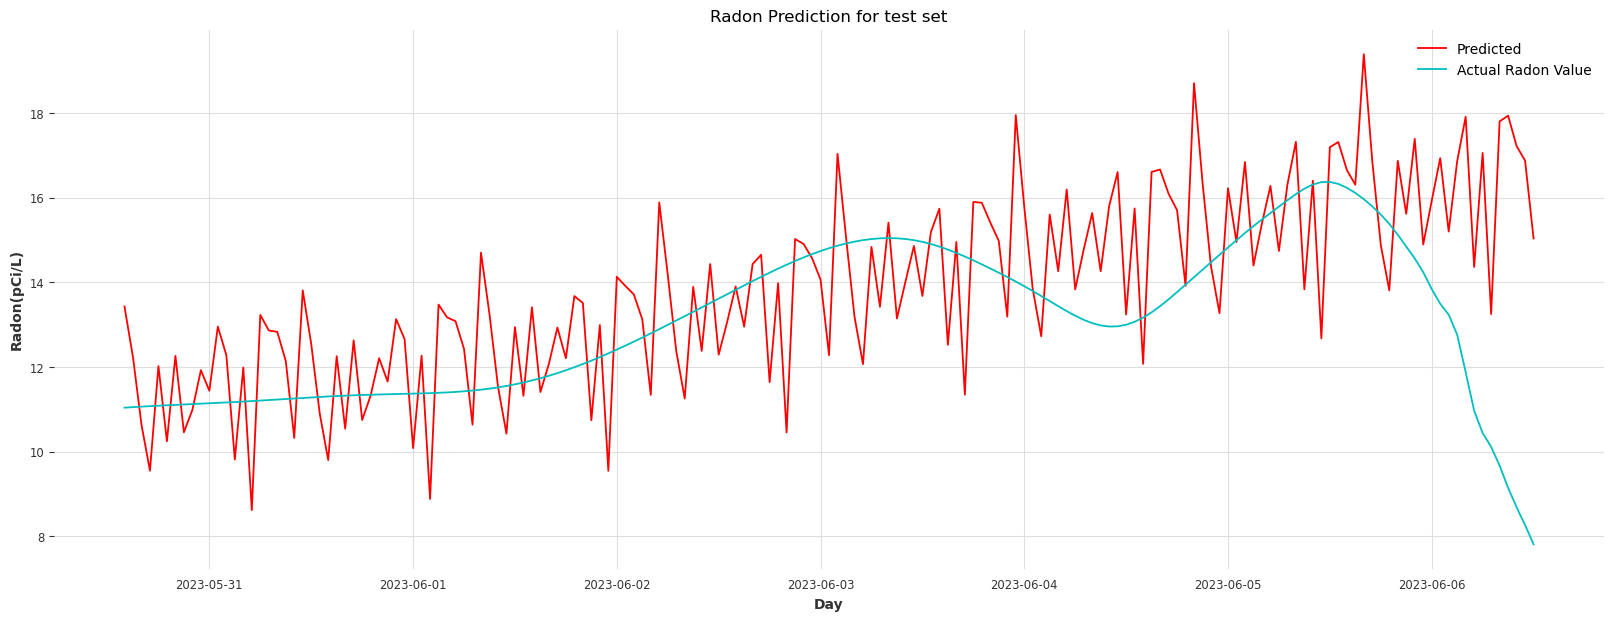

In [18]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
plt.plot(dfY.index, dfY['Predicted'], color='r', label='Predicted')
plt.plot(dfY.index, dfY['Actual'], color='c', label='Actual Radon Value')
plt.legend()
plt.title('Radon Prediction for test set')
plt.xlabel('Day')
plt.ylabel('Radon(pCi/L)')
plt.show()

# Radon 13

In [19]:
df = df_radon['13'].copy()

In [20]:
# Denoising the Radon signal
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [21]:
def wavelet_denoising(x, wavelet='db4', level=5):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    n = len(x) 
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    if len(x) % 2 ==0:
        return pywt.waverec(coeff, wavelet, mode='per')
    else:
        return pywt.waverec(coeff, wavelet, mode='per')[:n]

In [22]:
signal = df['Radon'].copy()
wavelet_name='coif17'
filtered = wavelet_denoising(signal, wavelet=wavelet_name, level=4)
df['Radon'] = filtered

In [23]:
# create time series object for target variable
ts_P = TimeSeries.from_series(df["Radon"], fill_missing_dates=True, freq="H") 

# check attributes of the time series
print("components:", ts_P.components)
print("duration:",ts_P.duration)
print("frequency:",ts_P.freq)
print("frequency:",ts_P.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_P.has_datetime_index)
print("deterministic:",ts_P.is_deterministic)
print("univariate:",ts_P.is_univariate)

components: Index(['Radon'], dtype='object', name='component')
duration: 390 days 17:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [24]:
# train/test split and scaling of target variable
ts_train, ts_test = ts_P.split_after(split_point=9210)

print("training start:", ts_train.start_time())
print("training end:", ts_train.end_time())
print("training duration:",ts_train.duration)
print("test start:", ts_test.start_time())
print("test end:", ts_test.end_time())
print("test duration:", ts_test.duration)


scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_ttest = scalerP.transform(ts_test)    
ts_t = scalerP.transform(ts_P)

# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)

print("first and last row of scaled Radon time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t.pd_dataframe().iloc[[0,-1]]

training start: 2022-05-11 19:00:00
training end: 2023-05-30 13:00:00
training duration: 383 days 18:00:00
test start: 2023-05-30 14:00:00
test end: 2023-06-06 12:00:00
test duration: 6 days 22:00:00
first and last row of scaled Radon time series:


component            Radon
SyncDate                  
2022-05-11 19:00:00   0.05
2023-06-06 12:00:00   0.05

In [25]:
print("first and last row of scaled target variable in training set: price:")
ts_ttrain.pd_dataframe().iloc[[0,-1]]

first and last row of scaled target variable in training set: price:


component            Radon
SyncDate                  
2022-05-11 19:00:00   0.05
2023-05-30 13:00:00   0.03

In [26]:
import torch
from ray.air import session
from darts.utils.losses import SmapeLoss
from torchmetrics import MetricCollection, SymmetricMeanAbsolutePercentageError, MeanAbsolutePercentageError
def build_fit_transformer_model(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1

    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "gpus":-1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
            "enable_progress_bar": False,
        }
    


    model = TransformerModel(
        input_chunk_length=model_args['in_len'],
        output_chunk_length=model_args['out_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name="Transformer",
        d_model=model_args['d_model'],
        nhead=model_args['nhead'],
        loss_fn=SmapeLoss(),
        norm_type=model_args['norm_type'],
        num_encoder_layers=model_args['num_encoder_layers'],
        num_decoder_layers=model_args['num_decoder_layers'],
        dim_feedforward=model_args['dim_feedforward'],
        dropout=model_args['dropout'],
        activation=model_args['activation'],
        #likelihood=QuantileRegression(quantiles=QUANTILES),
        optimizer_kwargs={'lr': model_args['lr']},
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                val_series=val_series,
        )
#     model.load_from_checkpoint(f"{model_args['model']} RNN model", best=True)
    ts_tpred = model.predict(
                series = ts_ttrain,
                n = len(ts_ttest),
                verbose=True
    )
    ts_q = scalerP.inverse_transform(ts_tpred)
    q_smape = smape(ts_q, ts_test)
    session.report({'q_smape': q_smape})

In [27]:
def build_fit_transformer_model_return(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1

    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "devices":1,
            'callbacks': callbacks,
        }
    


    model = TransformerModel(
        input_chunk_length=model_args['in_len'],
        output_chunk_length=model_args['out_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name="Transformer",
        d_model=model_args['d_model'],
        nhead=model_args['nhead'],
        loss_fn=SmapeLoss(),
        norm_type=model_args['norm_type'],
        num_encoder_layers=model_args['num_encoder_layers'],
        num_decoder_layers=model_args['num_decoder_layers'],
        dim_feedforward=model_args['dim_feedforward'],
        dropout=model_args['dropout'],
        activation=model_args['activation'],
        #likelihood=QuantileRegression(quantiles=QUANTILES),
        optimizer_kwargs={'lr': model_args['lr']},
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                
                val_series=val_series,
                )
#     if save_model:
#         print("have saved the model after training:", mpath)
#         model.save_model(mpath)
    return model

In [28]:
from ray import tune
from ray.tune import CLIReporter
# from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler, AsyncHyperBandScheduler
from ray.tune.search.optuna import OptunaSearch
from ray.tune.search import ConcurrencyLimiter
# tune_callback = TuneReportCallback(
#     {
#         "loss":"val_loss",
#         "sMAPE": "val_SymmetricMeanAbsolutePercentageError",
#     },
#     on="validation_end",
# )

early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )

#define the hyperparameter search space
config = {
    "batch_size": tune.choice([32,64,128]),
    "in_len": tune.randint(8,168),
    "out_len":tune.randint(1,24),
    "d_model":tune.choice([32,64,128,256]),
    "nhead":tune.choice([2,4,8]),
    "num_encoder_layers":tune.choice([1,2,3,4,5,6]),
    "num_decoder_layers":tune.choice([1,2,3,4,5,6]),
    "dim_feedforward":tune.choice([32,64,128,256]),
    "dropout":tune.uniform(0.1,0.5),
    "activation":tune.choice(["GLU", "Bilinear", "ReGLU", "GEGLU", "SwiGLU", "ReLU", "GELU"]),
    "norm_type":tune.choice([None,"LayerNorm", "RMSNorm", "LayerNormNoBias"]),
    "lr":tune.loguniform(1e-5,1e-1),
    "include_hour":tune.choice([True,False]),
}

reporter = CLIReporter(
    parameter_columns=list(config.keys()),
    metric_columns=["q_smape"])
resources_per_trial = {"cpu": 5, "gpu": 0.4}

num_samples = 100

algo = OptunaSearch()

algo = ConcurrencyLimiter(algo, max_concurrent=10)

scheduler = AsyncHyperBandScheduler(max_t=100, grace_period=10, reduction_factor=2)

train_fn_with_parameters = tune.with_parameters(build_fit_transformer_model, callbacks=[early_stopper])

analysis = tune.run(
    train_fn_with_parameters,
    resources_per_trial=resources_per_trial,
    metric="q_smape",
    mode="min",
    config=config,
    num_samples=num_samples,
    search_alg=algo,
    scheduler = scheduler,
    progress_reporter=reporter,
    name="trasnformer_tune_cov",

)

print("Best hyperparameters found were: ", analysis.best_config)

== Status ==
Current time: 2023-07-08 04:23:30 (running for 00:00:00.14)
Memory usage on this node: 22.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 1/100 (1 RUNNING)
+--------------------------------------+----------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------------------+-------------------+-----------+--------------+-------------+------------+----------------+
| Trial name                           | status   | loc                  |   batch_size |   in_len |   out_len |   d_model |   nhead |   num_encoder_layers |   num_decoder_layers |   dim_feedforward |   dropout | activation   | norm_type   |         lr | include_hour   |

(build_fit_transformer_model pid=1170731) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1170731)   rank_zero_deprecation(
(build_fit_transformer_model pid=1170731) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1170731)   rank_zero_deprecation(
(build_fit_transformer_model pid=1170731) Auto select gpus: [0]
(build_fit_transformer_model pid=1170731) GPU available: True (cuda), used: True
(build_fit_t

(build_fit_transformer_model pid=1170961) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1170961)   rank_zero_deprecation(
(build_fit_transformer_model pid=1170961) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1170961)   rank_zero_deprecation(
(build_fit_transformer_model pid=1170969) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:47

== Status ==
Current time: 2023-07-08 04:23:39 (running for 00:00:09.51)
Memory usage on this node: 27.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+--------------------------------------+----------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------------------+-------------------+-----------+--------------+-------------+-------------+----------------+
| Trial name                           | status   | loc                  |   batch_size |   in_len |   out_len |   d_model |   nhead |   num_encoder_layers |   num_decoder_layers |   dim_feedforward |   dropout | activation   | norm_type   |  

(build_fit_transformer_model pid=1171018) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1171018)   rank_zero_deprecation(
(build_fit_transformer_model pid=1171018) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1171018)   rank_zero_deprecation(
(build_fit_transformer_model pid=1170958) Auto select gpus: [0]
(build_fit_transformer_model pid=1170958) GPU available: True (cuda), used: True
(build_fit_t

(build_fit_transformer_model pid=1170958) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1170958)   rank_zero_warn(
(build_fit_transformer_model pid=1170958) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1170958)   rank_zero_warn(
(build_fit_transformer_model pid=1170958) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. Y

== Status ==
Current time: 2023-07-08 04:23:44 (running for 00:00:14.52)
Memory usage on this node: 39.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+--------------------------------------+----------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------------------+-------------------+-----------+--------------+-------------+-------------+----------------+
| Trial name                           | status   | loc                  |   batch_size |   in_len |   out_len |   d_model |   nhead |   num_encoder_layers |   num_decoder_layers |   dim_feedforward |   dropout | activation   | norm_type   |  

== Status ==
Current time: 2023-07-08 04:23:59 (running for 00:00:29.53)
Memory usage on this node: 39.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+--------------------------------------+----------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------------------+-------------------+-----------+--------------+-------------+-------------+----------------+
| Trial name                           | status   | loc                  |   batch_size |   in_len |   out_len |   d_model |   nhead |   num_encoder_layers |   num_decoder_layers |   dim_feedforward |   dropout | activation   | norm_type   |  

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.59it/s]


(build_fit_transformer_model pid=1170966) Auto select gpus: [0]
(build_fit_transformer_model pid=1170966) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1170966) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1170966) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1170966) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1170966) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1170966) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1170956) Auto select gpus: [0]
(build_fit_transformer_model pid=1170956) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1170956) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1170956) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1170956) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1170956) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1170956) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]
== Status ==
Current time: 2023-07-08 04:24:05 (running for 00:00:35.49)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 4c93ccbe with q_smape=64.1389516178848 and parameters={'batch_size': 128, 'in_len': 37, 'out_len': 6, 'd_model': 128, 'nhead': 8, 'num_encoder_layers': 4, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.4814752329702644, 'activation': 'GLU', 'norm_type': None, 'lr': 0.02885946068308065, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 10/100 (1 PENDING, 8 RUNNING, 1 TERMINATED)
+--------------------------------------+------------+----------------------+----------

(build_fit_transformer_model pid=1172587) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1172587)   rank_zero_deprecation(
(build_fit_transformer_model pid=1172587) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1172587)   rank_zero_deprecation(
(build_fit_transformer_model pid=1172587) Auto select gpus: [0]
(build_fit_transformer_model pid=1172587) GPU available: True (cuda), used: True
(build_fit_t

== Status ==
Current time: 2023-07-08 04:24:12 (running for 00:00:41.98)
Memory usage on this node: 38.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 4c93ccbe with q_smape=64.1389516178848 and parameters={'batch_size': 128, 'in_len': 37, 'out_len': 6, 'd_model': 128, 'nhead': 8, 'num_encoder_layers': 4, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.4814752329702644, 'activation': 'GLU', 'norm_type': None, 'lr': 0.02885946068308065, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 11/100 (1 PENDING, 8 RUNNING, 2 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+---------------------

(build_fit_transformer_model pid=1172823) Auto select gpus: [0]
(build_fit_transformer_model pid=1172823) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1172823) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1172823) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1172823) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1172823) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1172823) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1172823) 
(build_fit_transformer_model pid=1172823)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:24:17 (running for 00:00:46.99)
Memory usage on this node: 39.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 4c93ccbe with q_smape=64.1389516178848 and parameters={'batch_size': 128, 'in_len': 37, 'out_len': 6, 'd_model': 128, 'nhead': 8, 'num_encoder_layers': 4, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.4814752329702644, 'activation': 'GLU', 'norm_type': None, 'lr': 0.02885946068308065, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 11/100 (1 PENDING, 8 RUNNING, 2 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+---------------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1170958) Auto select gpus: [0]
(build_fit_transformer_model pid=1170958) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1170958) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1170958) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1170958) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1170958) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1170731) Auto select gpus: [0]
(build_fit_transformer_model pid=1170731) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1170731) TPU available: False, using: 0 TPU 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


(build_fit_transformer_model pid=1172823) Auto select gpus: [0]
(build_fit_transformer_model pid=1172823) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1172823) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1172823) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1172823) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1172823) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1172823) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.63it/s]


(build_fit_transformer_model pid=1171018) Auto select gpus: [0]
(build_fit_transformer_model pid=1171018) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1171018) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1171018) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1171018) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1171018) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1171018) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.39it/s]


(build_fit_transformer_model pid=1170961) Auto select gpus: [0]
(build_fit_transformer_model pid=1170961) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1170961) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1170961) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1170961) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1170961) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1170961) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]
== Status ==
Current time: 2023-07-08 04:24:27 (running for 00:00:57.45)
Memory usage on this node: 35.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 91cfadfd with q_smape=51.651720949902035 and parameters={'batch_size': 128, 'in_len': 24, 'out_len': 22, 'd_model': 64, 'nhead': 8, 'num_encoder_layers': 2, 'num_decoder_layers': 3, 'dim_feedforward': 128, 'dropout': 0.10555140648127824, 'activation': 'GEGLU', 'norm_type': 'RMSNorm', 'lr': 0.05562722910497641, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 13/100 (1 PENDING, 8 RUNNING, 4 TERMINATED)
+--------------------------------------+------------+----------------------+

(build_fit_transformer_model pid=1173087) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1173087)   rank_zero_deprecation(
(build_fit_transformer_model pid=1173087) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1173087)   rank_zero_deprecation(
(build_fit_transformer_model pid=1173085) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:47

(build_fit_transformer_model pid=1173561) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1173561)   rank_zero_deprecation(
(build_fit_transformer_model pid=1173561) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1173561)   rank_zero_deprecation(
(build_fit_transformer_model pid=1173563) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:47

== Status ==
Current time: 2023-07-08 04:24:37 (running for 00:01:07.01)
Memory usage on this node: 35.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 16/100 (1 PENDING, 8 RUNNING, 7 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+-------------

(build_fit_transformer_model pid=1173563) Auto select gpus: [0]
(build_fit_transformer_model pid=1173563) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1173563) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1173563) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1173563) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1173563) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1173563) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_transformer_model pid=1173563) 
(build_fit_transformer_model pid=1173563)   | Name                | Type                | Param

(build_fit_transformer_model pid=1173559) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1173559)   rank_zero_warn(
(build_fit_transformer_model pid=1173559) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1173559)   rank_zero_warn(


== Status ==
Current time: 2023-07-08 04:24:42 (running for 00:01:12.03)
Memory usage on this node: 39.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 16/100 (1 PENDING, 8 RUNNING, 7 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+-------------

(build_fit_transformer_model pid=1170964) Auto select gpus: [0]
(build_fit_transformer_model pid=1170964) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1170964) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1170964) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1170964) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1170964) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1170964) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


(build_fit_transformer_model pid=1174267) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1174267)   rank_zero_deprecation(
(build_fit_transformer_model pid=1174267) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1174267)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:24:49 (running for 00:01:18.99)
Memory usage on this node: 38.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 17/100 (1 PENDING, 8 RUNNING, 8 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+-------------

(build_fit_transformer_model pid=1174267) Auto select gpus: [0]
(build_fit_transformer_model pid=1174267) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1174267) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1174267) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1174267) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1174267) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1174267) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1174267) 
(build_fit_transformer_model pid=1174267)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:24:54 (running for 00:01:24.00)
Memory usage on this node: 39.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 17/100 (1 PENDING, 8 RUNNING, 8 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+-------------

(build_fit_transformer_model pid=1170969) Auto select gpus: [0]
(build_fit_transformer_model pid=1170969) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1170969) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1170969) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1170969) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1170969) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1170969) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


== Status ==
Current time: 2023-07-08 04:25:04 (running for 00:01:34.01)
Memory usage on this node: 39.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 17/100 (1 PENDING, 7 RUNNING, 9 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-----

(build_fit_transformer_model pid=1174564) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1174564)   rank_zero_deprecation(
(build_fit_transformer_model pid=1174564) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1174564)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:25:11 (running for 00:01:40.99)
Memory usage on this node: 38.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 18/100 (1 PENDING, 8 RUNNING, 9 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+-------------

(build_fit_transformer_model pid=1174564) Auto select gpus: [0]
(build_fit_transformer_model pid=1174564) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1174564) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1174564) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1174564) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1174564) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1174564) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_transformer_model pid=1174564) 
(build_fit_transformer_model pid=1174564)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:25:16 (running for 00:01:46.00)
Memory usage on this node: 39.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 18/100 (1 PENDING, 8 RUNNING, 9 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+-------------

== Status ==
Current time: 2023-07-08 04:25:26 (running for 00:01:56.02)
Memory usage on this node: 39.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 18/100 (1 PENDING, 8 RUNNING, 9 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+-------------

== Status ==
Current time: 2023-07-08 04:25:36 (running for 00:02:06.03)
Memory usage on this node: 39.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 18/100 (1 PENDING, 8 RUNNING, 9 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+-------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1173561) Auto select gpus: [0]
(build_fit_transformer_model pid=1173561) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1173561) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1173561) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1173561) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1173561) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1173561) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.89it/s]


(build_fit_transformer_model pid=1174564) Auto select gpus: [0]
(build_fit_transformer_model pid=1174564) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1174564) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1174564) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1174564) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1174564) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1174564) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.70it/s]


(build_fit_transformer_model pid=1174830) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1174830)   rank_zero_deprecation(
(build_fit_transformer_model pid=1174830) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1174830)   rank_zero_deprecation(
(build_fit_transformer_model pid=1174991) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:47

== Status ==
Current time: 2023-07-08 04:25:50 (running for 00:02:20.02)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 20/100 (1 PENDING, 8 RUNNING, 11 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1174991) Auto select gpus: [0]
(build_fit_transformer_model pid=1174991) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1174991) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1174991) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1174991) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1174991) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1174991) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_transformer_model pid=1174991) 
(build_fit_transformer_model pid=1174991)   | Name                | Type                | Param

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1172587) Auto select gpus: [0]
(build_fit_transformer_model pid=1174991) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1174991)   rank_zero_warn(
(build_fit_transformer_model pid=1174991) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1174991)   rank_zero_warn(
(build_fit_transformer_model pid=1174991) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePerce

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


(build_fit_transformer_model pid=1175308) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1175308)   rank_zero_deprecation(
(build_fit_transformer_model pid=1175308) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1175308)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:25:58 (running for 00:02:28.01)
Memory usage on this node: 38.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1175308) Auto select gpus: [0]
(build_fit_transformer_model pid=1175308) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1175308) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1175308) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1175308) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1175308) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1175308) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1175308) 
(build_fit_transformer_model pid=1175308)   | Name                | Type                | Param

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.78it/s]


(build_fit_transformer_model pid=1173087) Auto select gpus: [0]
(build_fit_transformer_model pid=1173087) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1173087) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1173087) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1173087) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1173087) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1173087) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1175550) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelera

== Status ==
Current time: 2023-07-08 04:26:08 (running for 00:02:38.02)
Memory usage on this node: 38.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 22/100 (1 PENDING, 8 RUNNING, 13 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1175550) Auto select gpus: [0]
(build_fit_transformer_model pid=1175550) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1175550) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1175550) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1175550) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1175550) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1175550) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1175550) 
(build_fit_transformer_model pid=1175550)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:26:13 (running for 00:02:43.03)
Memory usage on this node: 39.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 22/100 (1 PENDING, 8 RUNNING, 13 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1174830) Auto select gpus: [0]
(build_fit_transformer_model pid=1174830) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1174830) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1174830) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1174830) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1174830) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1174830) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.78it/s]


(build_fit_transformer_model pid=1175843) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1175843)   rank_zero_deprecation(
(build_fit_transformer_model pid=1175843) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1175843)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:26:26 (running for 00:02:56.02)
Memory usage on this node: 38.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 23/100 (1 PENDING, 8 RUNNING, 14 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1175843) Auto select gpus: [0]
(build_fit_transformer_model pid=1175843) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1175843) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1175843) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1175843) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1175843) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1175843) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1175843) 
(build_fit_transformer_model pid=1175843)   | Name                | Type                | Param

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.37it/s]


(build_fit_transformer_model pid=1174991) Auto select gpus: [0]
(build_fit_transformer_model pid=1174991) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1174991) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1174991) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1174991) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1174991) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1174991) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 28.17it/s]

(build_fit_transformer_model pid=1173085) Auto select gpus: [0]
(build_fit_transformer_model pid=1173085) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1173085) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1173085) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1173085) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1173085) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1173085) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.36it/s]
== Status ==
Current time: 2023-07-08 04:26:31 (running for 00:03:01.46)
Memory usage on this node: 37.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 24/100 (1 PENDING, 8 RUNNING, 15 TERMINATED)
+--------------------------------------+------------+----------------------+

(build_fit_transformer_model pid=1173563) Auto select gpus: [0]
(build_fit_transformer_model pid=1173563) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1173563) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1173563) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1173563) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1173563) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1173563) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_transformer_model pid=1176086) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelera

== Status ==
Current time: 2023-07-08 04:26:41 (running for 00:03:11.05)
Memory usage on this node: 36.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1176328) Auto select gpus: [0]
(build_fit_transformer_model pid=1176328) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1176328) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1176328) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1176328) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1176328) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1176328) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1176328) 
(build_fit_transformer_model pid=1176328)   | Name                | Type                | Param

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


(build_fit_transformer_model pid=1176808) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1176808)   rank_zero_deprecation(
(build_fit_transformer_model pid=1176808) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1176808)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:26:51 (running for 00:03:21.02)
Memory usage on this node: 38.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 27/100 (1 PENDING, 8 RUNNING, 18 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1176808) Auto select gpus: [0]
(build_fit_transformer_model pid=1176808) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1176808) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1176808) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1176808) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1176808) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1176808) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1176808) 
(build_fit_transformer_model pid=1176808)   | Name                | Type                | Param

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.36it/s]


(build_fit_transformer_model pid=1175550) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1177052) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1177052)   rank_zero_deprecation(
(build_fit_transformer_model pid=1177052) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1177052)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:27:01 (running for 00:03:31.02)
Memory usage on this node: 38.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 28/100 (1 PENDING, 8 RUNNING, 19 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1177052) Auto select gpus: [0]
(build_fit_transformer_model pid=1177052) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1177052) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1177052) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1177052) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1177052) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1177052) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1177052) 
(build_fit_transformer_model pid=1177052)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:27:06 (running for 00:03:36.03)
Memory usage on this node: 39.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 28/100 (1 PENDING, 8 RUNNING, 19 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

== Status ==
Current time: 2023-07-08 04:27:16 (running for 00:03:46.05)
Memory usage on this node: 39.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 28/100 (1 PENDING, 8 RUNNING, 19 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1177052) Auto select gpus: [0]
(build_fit_transformer_model pid=1177052) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1177052) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1177052) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1177052) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1177052) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1177052) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.54it/s]


(build_fit_transformer_model pid=1174267) Auto select gpus: [0]
(build_fit_transformer_model pid=1174267) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1174267) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1174267) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1174267) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1174267) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1174267) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.54it/s]


(build_fit_transformer_model pid=1177305) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1177305)   rank_zero_deprecation(
(build_fit_transformer_model pid=1177305) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1177305)   rank_zero_deprecation(
(build_fit_transformer_model pid=1177305) Auto select gpus: [0]
(build_fit_transformer_model pid=1177305) GPU available: True (cuda), used: True
(build_fit_t

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.89it/s]
== Status ==
Current time: 2023-07-08 04:27:25 (running for 00:03:54.84)
Memory usage on this node: 37.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+--------------------------------------+------------+----------------------+-

(build_fit_transformer_model pid=1177468) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1177468)   rank_zero_deprecation(
(build_fit_transformer_model pid=1177468) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1177468)   rank_zero_deprecation(
(build_fit_transformer_model pid=1177468) Auto select gpus: [0]
(build_fit_transformer_model pid=1177468) GPU available: True (cuda), used: True
(build_fit_t

== Status ==
Current time: 2023-07-08 04:27:31 (running for 00:04:01.04)
Memory usage on this node: 38.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 31/100 (1 PENDING, 8 RUNNING, 22 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1177780) Auto select gpus: [0]
(build_fit_transformer_model pid=1177780) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1177780) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1177780) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1177780) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1177780) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1177780) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1177780) 
(build_fit_transformer_model pid=1177780)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:27:36 (running for 00:04:06.05)
Memory usage on this node: 39.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 31/100 (1 PENDING, 8 RUNNING, 22 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

== Status ==
Current time: 2023-07-08 04:27:46 (running for 00:04:16.07)
Memory usage on this node: 39.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 31/100 (1 PENDING, 8 RUNNING, 22 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1177468) Auto select gpus: [0]
(build_fit_transformer_model pid=1177468) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1177468) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1177468) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1177468) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1177468) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1177468) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1178035) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelera

== Status ==
Current time: 2023-07-08 04:27:53 (running for 00:04:23.03)
Memory usage on this node: 38.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1178035) Auto select gpus: [0]
(build_fit_transformer_model pid=1178035) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1178035) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1178035) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1178035) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1178035) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1178035) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1178035) 
(build_fit_transformer_model pid=1178035)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:27:58 (running for 00:04:28.04)
Memory usage on this node: 39.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1176328) Auto select gpus: [0]
(build_fit_transformer_model pid=1176328) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1176328) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1176328) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1176328) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1176328) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1176328) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.13it/s]


(build_fit_transformer_model pid=1178323) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1178323)   rank_zero_deprecation(
(build_fit_transformer_model pid=1178323) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1178323)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:28:05 (running for 00:04:35.04)
Memory usage on this node: 38.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 33/100 (1 PENDING, 8 RUNNING, 24 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1178323) Auto select gpus: [0]
(build_fit_transformer_model pid=1178323) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1178323) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1178323) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1178323) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1178323) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1178323) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1178323) 
(build_fit_transformer_model pid=1178323)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:28:10 (running for 00:04:40.05)
Memory usage on this node: 39.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 33/100 (1 PENDING, 8 RUNNING, 24 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1175843) Auto select gpus: [0]
(build_fit_transformer_model pid=1175843) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1175843) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1175843) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1175843) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1175843) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1175843) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.33it/s]


(build_fit_transformer_model pid=1178572) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1178572)   rank_zero_deprecation(
(build_fit_transformer_model pid=1178572) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1178572)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:28:21 (running for 00:04:51.03)
Memory usage on this node: 38.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 34/100 (1 PENDING, 8 RUNNING, 25 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1178572) Auto select gpus: [0]
(build_fit_transformer_model pid=1178572) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1178572) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1178572) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1178572) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1178572) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1178572) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1178572) 
(build_fit_transformer_model pid=1178572)   | Name                | Type                | Param

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.65it/s]


(build_fit_transformer_model pid=1176808) Auto select gpus: [0]
(build_fit_transformer_model pid=1176808) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1176808) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1176808) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1176808) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1176808) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1176808) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1176330) Auto select gpus: [0]
(build_fit_transformer_model pid=1176330) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1176330) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1176330) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1176330) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1176330) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1176330) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.07it/s]


(build_fit_transformer_model pid=1177305) Auto select gpus: [0]
(build_fit_transformer_model pid=1177305) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1177305) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1177305) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1177305) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1177305) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1177305) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.82it/s]


(build_fit_transformer_model pid=1178815) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1178815)   rank_zero_deprecation(
(build_fit_transformer_model pid=1178815) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1178815)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:28:28 (running for 00:04:57.70)
Memory usage on this node: 35.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 36/100 (1 PENDING, 8 RUNNING, 27 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1178977) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1178977)   rank_zero_deprecation(
(build_fit_transformer_model pid=1178977) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1178977)   rank_zero_deprecation(
(build_fit_transformer_model pid=1178815) Auto select gpus: [0]
(build_fit_transformer_model pid=1178815) GPU available: True (cuda), used: True
(build_fit_t

(build_fit_transformer_model pid=1179285) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1179285)   rank_zero_deprecation(
(build_fit_transformer_model pid=1179285) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1179285)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:28:35 (running for 00:05:05.04)
Memory usage on this node: 38.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 37/100 (1 PENDING, 8 RUNNING, 28 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1179285) Auto select gpus: [0]
(build_fit_transformer_model pid=1179285) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1179285) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1179285) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1179285) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1179285) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1179285) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1179285) 
(build_fit_transformer_model pid=1179285)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:28:40 (running for 00:05:10.05)
Memory usage on this node: 39.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 37/100 (1 PENDING, 8 RUNNING, 28 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

== Status ==
Current time: 2023-07-08 04:28:50 (running for 00:05:20.06)
Memory usage on this node: 39.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 37/100 (1 PENDING, 8 RUNNING, 28 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.68it/s]


(build_fit_transformer_model pid=1177780) Auto select gpus: [0]
(build_fit_transformer_model pid=1177780) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1177780) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1177780) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1177780) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1177780) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1177780) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1179285) Auto select gpus: [0]
(build_fit_transformer_model pid=1179285) GPU available: True (cuda), used

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.43it/s]
== Status ==
Current time: 2023-07-08 04:29:01 (running for 00:05:30.97)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 38/100 (1 PENDING, 8 RUNNING, 29 TERMINATED)
+--------------------------------------+------------+----------------------+-

(build_fit_transformer_model pid=1179549) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1179549)   rank_zero_deprecation(
(build_fit_transformer_model pid=1179549) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1179549)   rank_zero_deprecation(
(build_fit_transformer_model pid=1179549) Auto select gpus: [0]
(build_fit_transformer_model pid=1179549) GPU available: True (cuda), used: True
(build_fit_t

== Status ==
Current time: 2023-07-08 04:29:08 (running for 00:05:38.04)
Memory usage on this node: 38.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 39/100 (1 PENDING, 8 RUNNING, 30 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1179785) Auto select gpus: [0]
(build_fit_transformer_model pid=1179785) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1179785) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1179785) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1179785) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1179785) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1179785) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1179785) 
(build_fit_transformer_model pid=1179785)   | Name                | Type                | Param

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1178977) Auto select gpus: [0]
(build_fit_transformer_model pid=1178977) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1178977) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1178977) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1178977) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1178977) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1178977) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.58it/s]


(build_fit_transformer_model pid=1180031) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1180031)   rank_zero_deprecation(
(build_fit_transformer_model pid=1180031) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1180031)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:29:16 (running for 00:05:46.05)
Memory usage on this node: 38.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 40/100 (1 PENDING, 8 RUNNING, 31 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1180031) Auto select gpus: [0]
(build_fit_transformer_model pid=1180031) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1180031) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1180031) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1180031) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1180031) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1180031) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_transformer_model pid=1180031) 
(build_fit_transformer_model pid=1180031)   | Name                | Type                | Param

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1178815) Auto select gpus: [0]
(build_fit_transformer_model pid=1178815) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1178815) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1178815) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1178815) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1178815) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1178815) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1180031) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWar

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.61it/s]


(build_fit_transformer_model pid=1180275) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1180275)   rank_zero_deprecation(
(build_fit_transformer_model pid=1180275) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1180275)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:29:24 (running for 00:05:54.05)
Memory usage on this node: 38.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 41/100 (1 PENDING, 8 RUNNING, 32 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1180275) Auto select gpus: [0]
(build_fit_transformer_model pid=1180275) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1180275) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1180275) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1180275) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1180275) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1180275) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1180275) 
(build_fit_transformer_model pid=1180275)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:29:29 (running for 00:05:59.06)
Memory usage on this node: 39.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 41/100 (1 PENDING, 8 RUNNING, 32 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1179785) Auto select gpus: [0]
(build_fit_transformer_model pid=1179785) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1179785) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1179785) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1179785) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1179785) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.19it/s]


(build_fit_transformer_model pid=1179785) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.36it/s]


(build_fit_transformer_model pid=1178323) Auto select gpus: [0]
(build_fit_transformer_model pid=1178323) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1178323) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1178323) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1178323) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1178323) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1178323) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1180524) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelera

== Status ==
Current time: 2023-07-08 04:29:44 (running for 00:06:14.05)
Memory usage on this node: 38.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 43/100 (1 PENDING, 8 RUNNING, 34 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1180687) Auto select gpus: [0]
(build_fit_transformer_model pid=1180687) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1180687) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1180687) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1180687) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1180687) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1180687) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1180687) 
(build_fit_transformer_model pid=1180687)   | Name                | Type                | Param

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.59it/s]


(build_fit_transformer_model pid=1180687) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1180687)   rank_zero_warn(
(build_fit_transformer_model pid=1180687) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1180687)   rank_zero_warn(
(build_fit_transformer_model pid=1180687) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. Y

== Status ==
Current time: 2023-07-08 04:29:50 (running for 00:06:20.05)
Memory usage on this node: 38.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 44/100 (1 PENDING, 8 RUNNING, 35 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1181001) Auto select gpus: [0]
(build_fit_transformer_model pid=1181001) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1181001) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1181001) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1181001) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1181001) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1181001) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1181001) 
(build_fit_transformer_model pid=1181001)   | Name                | Type                | Param

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1178035) Auto select gpus: [0]
(build_fit_transformer_model pid=1178035) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1178035) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1178035) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1178035) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1178035) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1178035) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1180275) Auto select gpus: [0]
(build_fit_transformer_model pid=1180275) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1180275) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1180275) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1180275) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1180275) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1180275) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.46it/s]
== Status ==
Current time: 2023-07-08 04:29:56 (running for 00:06:25.95)
Memory usage on this node: 37.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 45/100 (1 PENDING, 8 RUNNING, 36 TERMINATED)
+--------------------------------------+------------+----------------------+-

(build_fit_transformer_model pid=1181291) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1181291)   rank_zero_deprecation(
(build_fit_transformer_model pid=1181291) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1181291)   rank_zero_deprecation(
(build_fit_transformer_model pid=1181291) Auto select gpus: [0]
(build_fit_transformer_model pid=1181291) GPU available: True (cuda), used: True
(build_fit_t

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.04it/s]


(build_fit_transformer_model pid=1181291) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1181291)   rank_zero_warn(
(build_fit_transformer_model pid=1181291) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1181291)   rank_zero_warn(
(build_fit_transformer_model pid=1181291) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. Y

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
== Status ==
Current time: 2023-07-08 04:30:01 (running for 00:06:31.52)
Memory usage on this node: 37.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 46/100 (1 PENDING, 8 RUNNING, 37 TERMINATED)
+--------------------------------------+------------+----------------------+---------

(build_fit_transformer_model pid=1180031) Auto select gpus: [0]
(build_fit_transformer_model pid=1180031) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1180031) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1180031) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1180031) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1180031) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1180031) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


(build_fit_transformer_model pid=1181527) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1181527)   rank_zero_deprecation(
(build_fit_transformer_model pid=1181527) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1181527)   rank_zero_deprecation(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.82it/s]

(build_fit_transformer_model pid=1180687) Auto select gpus: [0]
(build_fit_transformer_model pid=1180687) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1180687) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1180687) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1180687) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1180687) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1180687) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(build_fit_transformer_model pid=1181527) Auto select gpus: [0]
(build_fit_transformer_model pid=1181527) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1181527) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1181527) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1181527) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1181527) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1181527) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1181527) 
(build_fit_transformer_model pid=1181527)   | Name                | Type                | Param

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1180524) Auto select gpus: [0]
(build_fit_transformer_model pid=1180524) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1180524) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1180524) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1180524) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1180524) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1180524) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


(build_fit_transformer_model pid=1181773) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1181773)   rank_zero_deprecation(
(build_fit_transformer_model pid=1181773) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1181773)   rank_zero_deprecation(
(build_fit_transformer_model pid=1181776) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:47

== Status ==
Current time: 2023-07-08 04:30:09 (running for 00:06:39.65)
Memory usage on this node: 34.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 49/100 (1 PENDING, 8 RUNNING, 40 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1182089) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1182089)   rank_zero_deprecation(
(build_fit_transformer_model pid=1182089) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1182089)   rank_zero_deprecation(
(build_fit_transformer_model pid=1181773) Auto select gpus: [0]
(build_fit_transformer_model pid=1181773) GPU available: True (cuda), used: True
(build_fit_t

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1181001) Auto select gpus: [0]
(build_fit_transformer_model pid=1181001) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1181001) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1181001) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1181001) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1181001) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1181001) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.40it/s]


(build_fit_transformer_model pid=1181773) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1181773)   rank_zero_warn(
(build_fit_transformer_model pid=1181773) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1181773)   rank_zero_warn(
(build_fit_transformer_model pid=1181773) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. Y

== Status ==
Current time: 2023-07-08 04:30:17 (running for 00:06:47.08)
Memory usage on this node: 38.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 51/100 (1 PENDING, 8 RUNNING, 42 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1182640) Auto select gpus: [0]
(build_fit_transformer_model pid=1182640) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1182640) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1182640) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1182640) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1182640) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1182640) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1182640) 
(build_fit_transformer_model pid=1182640)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:30:22 (running for 00:06:52.08)
Memory usage on this node: 39.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cd283a5a with q_smape=38.65585521298045 and parameters={'batch_size': 128, 'in_len': 73, 'out_len': 21, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'num_decoder_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3242126015778962, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.002228137327048385, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 51/100 (1 PENDING, 8 RUNNING, 42 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1181291) Auto select gpus: [0]
(build_fit_transformer_model pid=1181291) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1181291) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1181291) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1181291) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1181291) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1181291) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


(build_fit_transformer_model pid=1181527) Auto select gpus: [0]
(build_fit_transformer_model pid=1181527) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1181527) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1181527) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1181527) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1181527) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1181527) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1181776) Auto select gpus: [0]
(build_fit_transformer_model pid=1181776) GPU available: True (cuda), used

== Status ==
Current time: 2023-07-08 04:30:28 (running for 00:06:58.04)
Memory usage on this node: 37.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7b703cc5 with q_smape=32.56406671031321 and parameters={'batch_size': 128, 'in_len': 9, 'out_len': 11, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.17481851233799564, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.00956419743509778, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 51/100 (8 RUNNING, 43 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-

(build_fit_transformer_model pid=1181773) Auto select gpus: [0]
(build_fit_transformer_model pid=1181773) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1181773) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1181773) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1181773) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1181773) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1181773) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.30it/s]


(build_fit_transformer_model pid=1182967) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1182967)   rank_zero_deprecation(
(build_fit_transformer_model pid=1182967) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1182967)   rank_zero_deprecation(
(build_fit_transformer_model pid=1182967) Auto select gpus: [0]
(build_fit_transformer_model pid=1182967) GPU available: True (cuda), used: True
(build_fit_t

== Status ==
Current time: 2023-07-08 04:30:33 (running for 00:07:03.06)
Memory usage on this node: 31.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7b703cc5 with q_smape=32.56406671031321 and parameters={'batch_size': 128, 'in_len': 9, 'out_len': 11, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.17481851233799564, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.00956419743509778, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 53/100 (7 RUNNING, 46 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+----------------

(build_fit_transformer_model pid=1183216) Auto select gpus: [0]
(build_fit_transformer_model pid=1183216) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1183216) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1183216) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1183216) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1183216) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1183216) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1183216) 
(build_fit_transformer_model pid=1183216)   | Name                | Type                | Param

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.96it/s]

(build_fit_transformer_model pid=1182640) Auto select gpus: [0]
(build_fit_transformer_model pid=1182640) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1182640) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1182640) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1182640) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1182640) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1183216) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.97it/s]


(build_fit_transformer_model pid=1182089) Auto select gpus: [0]
(build_fit_transformer_model pid=1182089) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1182089) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1182089) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1182089) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1182089) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1182089) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


(build_fit_transformer_model pid=1182472) Auto select gpus: [0]
(build_fit_transformer_model pid=1182472) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1182472) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1182472) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1182472) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1182472) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1182472) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


== Status ==
Current time: 2023-07-08 04:30:40 (running for 00:07:09.79)
Memory usage on this node: 37.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7b703cc5 with q_smape=32.56406671031321 and parameters={'batch_size': 128, 'in_len': 9, 'out_len': 11, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.17481851233799564, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.00956419743509778, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 55/100 (1 PENDING, 8 RUNNING, 46 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+-------------

(build_fit_transformer_model pid=1183671) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1183671)   rank_zero_deprecation(
(build_fit_transformer_model pid=1183671) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1183671)   rank_zero_deprecation(
(build_fit_transformer_model pid=1183671) Auto select gpus: [0]
(build_fit_transformer_model pid=1183671) GPU available: True (cuda), used: True
(build_fit_t

== Status ==
Current time: 2023-07-08 04:30:48 (running for 00:07:18.13)
Memory usage on this node: 35.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7b703cc5 with q_smape=32.56406671031321 and parameters={'batch_size': 128, 'in_len': 9, 'out_len': 11, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.17481851233799564, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.00956419743509778, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 58/100 (1 PENDING, 8 RUNNING, 49 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+-------------

(build_fit_transformer_model pid=1183928) Auto select gpus: [0]
(build_fit_transformer_model pid=1183928) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1183928) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1183928) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1183928) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1183928) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1183928) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1183928) 
(build_fit_transformer_model pid=1183928)   | Name                | Type                | Param

(build_fit_transformer_model pid=1183932) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1183932)   rank_zero_warn(
(build_fit_transformer_model pid=1183932) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1183932)   rank_zero_warn(
(build_fit_transformer_model pid=1183932) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. Y

== Status ==
Current time: 2023-07-08 04:30:53 (running for 00:07:23.15)
Memory usage on this node: 39.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7b703cc5 with q_smape=32.56406671031321 and parameters={'batch_size': 128, 'in_len': 9, 'out_len': 11, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.17481851233799564, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.00956419743509778, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 58/100 (1 PENDING, 8 RUNNING, 49 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+-------------

(build_fit_transformer_model pid=1182967) Auto select gpus: [0]
(build_fit_transformer_model pid=1182967) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1182967) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1182967) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1182967) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1182967) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1182967) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1183218) Auto select gpus: [0]
(build_fit_transformer_model pid=1183218) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1183218) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1183218) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1183218) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1183218) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1183218) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


(build_fit_transformer_model pid=1183216) Auto select gpus: [0]
(build_fit_transformer_model pid=1183216) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1183216) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1183216) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1183216) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1183216) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1183216) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.90it/s]
== Status ==
Current time: 2023-07-08 04:30:59 (running for 00:07:29.04)
Memory usage on this node: 35.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7b703cc5 with q_smape=32.56406671031321 and parameters={'batch_size': 128, 'in_len': 9, 'out_len': 11, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.17481851233799564, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.00956419743509778, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 58/100 (7 RUNNING, 51 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+--

(build_fit_transformer_model pid=1184689) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1184689)   rank_zero_deprecation(
(build_fit_transformer_model pid=1184689) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1184689)   rank_zero_deprecation(
(build_fit_transformer_model pid=1184689) Auto select gpus: [0]
(build_fit_transformer_model pid=1184689) GPU available: True (cuda), used: True
(build_fit_t

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


(build_fit_transformer_model pid=1184922) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1184922)   rank_zero_deprecation(
(build_fit_transformer_model pid=1184922) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1184922)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:31:04 (running for 00:07:34.04)
Memory usage on this node: 33.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7b703cc5 with q_smape=32.56406671031321 and parameters={'batch_size': 128, 'in_len': 9, 'out_len': 11, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.17481851233799564, 'activation': 'GLU', 'norm_type': 'RMSNorm', 'lr': 0.00956419743509778, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 60/100 (8 RUNNING, 52 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-

(build_fit_transformer_model pid=1184974) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1184974)   rank_zero_deprecation(
(build_fit_transformer_model pid=1184974) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1184974)   rank_zero_deprecation(
(build_fit_transformer_model pid=1184922) Auto select gpus: [0]
(build_fit_transformer_model pid=1184922) GPU available: True (cuda), used: True
(build_fit_t

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


(build_fit_transformer_model pid=1183928) Auto select gpus: [0]
(build_fit_transformer_model pid=1183928) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1183928) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1183928) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1183928) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1183928) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1183928) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


== Status ==
Current time: 2023-07-08 04:31:12 (running for 00:07:41.82)
Memory usage on this node: 37.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 72918d2f with q_smape=28.78080707539122 and parameters={'batch_size': 128, 'in_len': 10, 'out_len': 8, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 4, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.1879621916027296, 'activation': 'ReGLU', 'norm_type': 'RMSNorm', 'lr': 0.03629976456230978, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 62/100 (1 PENDING, 8 RUNNING, 53 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+-------------

(build_fit_transformer_model pid=1185392) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1185392)   rank_zero_deprecation(
(build_fit_transformer_model pid=1185392) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1185392)   rank_zero_deprecation(
(build_fit_transformer_model pid=1185392) Auto select gpus: [0]
(build_fit_transformer_model pid=1185392) GPU available: True (cuda), used: True
(build_fit_t

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1183930) Auto select gpus: [0]
(build_fit_transformer_model pid=1183930) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1183930) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1183930) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1183930) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1183930) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1183930) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.56it/s]


(build_fit_transformer_model pid=1185636) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1185636)   rank_zero_deprecation(
(build_fit_transformer_model pid=1185636) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1185636)   rank_zero_deprecation(
(build_fit_transformer_model pid=1185636) Auto select gpus: [0]
(build_fit_transformer_model pid=1185636) GPU available: True (cuda), used: True
(build_fit_t

== Status ==
Current time: 2023-07-08 04:31:17 (running for 00:07:47.04)
Memory usage on this node: 35.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 72918d2f with q_smape=28.78080707539122 and parameters={'batch_size': 128, 'in_len': 10, 'out_len': 8, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 4, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.1879621916027296, 'activation': 'ReGLU', 'norm_type': 'RMSNorm', 'lr': 0.03629976456230978, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 63/100 (8 RUNNING, 55 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-

(build_fit_transformer_model pid=1185805) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1185805)   rank_zero_deprecation(
(build_fit_transformer_model pid=1185805) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1185805)   rank_zero_deprecation(
(build_fit_transformer_model pid=1185805) Auto select gpus: [0]
(build_fit_transformer_model pid=1185805) GPU available: True (cuda), used: True
(build_fit_t

== Status ==
Current time: 2023-07-08 04:31:26 (running for 00:07:56.48)
Memory usage on this node: 39.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 72918d2f with q_smape=28.78080707539122 and parameters={'batch_size': 128, 'in_len': 10, 'out_len': 8, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 4, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.1879621916027296, 'activation': 'ReGLU', 'norm_type': 'RMSNorm', 'lr': 0.03629976456230978, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 64/100 (1 PENDING, 8 RUNNING, 55 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+-------------

(build_fit_transformer_model pid=1184922) Auto select gpus: [0]
(build_fit_transformer_model pid=1184922) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1184922) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1184922) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1184922) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1184922) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1184922) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.79it/s]


(build_fit_transformer_model pid=1184689) Auto select gpus: [0]
(build_fit_transformer_model pid=1184689) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1184689) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1184689) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1184689) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1184689) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1184689) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1186167) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelera

== Status ==
Current time: 2023-07-08 04:31:36 (running for 00:08:06.07)
Memory usage on this node: 38.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 72918d2f with q_smape=28.78080707539122 and parameters={'batch_size': 128, 'in_len': 10, 'out_len': 8, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 4, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.1879621916027296, 'activation': 'ReGLU', 'norm_type': 'RMSNorm', 'lr': 0.03629976456230978, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 66/100 (1 PENDING, 8 RUNNING, 57 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+-------------

(build_fit_transformer_model pid=1186328) Auto select gpus: [0]
(build_fit_transformer_model pid=1186328) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1186328) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1186328) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1186328) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1186328) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1186328) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1186328) 
(build_fit_transformer_model pid=1186328)   | Name                | Type                | Param

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1183932) Auto select gpus: [0]
(build_fit_transformer_model pid=1183932) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1183932) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1183932) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1183932) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1183932) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1183932) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.07it/s]


(build_fit_transformer_model pid=1184974) Auto select gpus: [0]
(build_fit_transformer_model pid=1184974) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1184974) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1184974) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1184974) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1184974) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1184974) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 36.32it/s]


(build_fit_transformer_model pid=1186647) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1186647)   rank_zero_deprecation(
(build_fit_transformer_model pid=1186647) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1186647)   rank_zero_deprecation(
(build_fit_transformer_model pid=1186647) Auto select gpus: [0]
(build_fit_transformer_model pid=1186807) /home/ubuntu/anaconda3/lib/python3.9/site-packages/

== Status ==
Current time: 2023-07-08 04:31:45 (running for 00:08:15.07)
Memory usage on this node: 37.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 72918d2f with q_smape=28.78080707539122 and parameters={'batch_size': 128, 'in_len': 10, 'out_len': 8, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 4, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.1879621916027296, 'activation': 'ReGLU', 'norm_type': 'RMSNorm', 'lr': 0.03629976456230978, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 68/100 (1 PENDING, 8 RUNNING, 59 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+-------------

(build_fit_transformer_model pid=1186807) Auto select gpus: [0]
(build_fit_transformer_model pid=1186807) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1186807) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1186807) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1186807) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1186807) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1186807) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1186807) 
(build_fit_transformer_model pid=1186807)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:31:50 (running for 00:08:20.09)
Memory usage on this node: 39.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 72918d2f with q_smape=28.78080707539122 and parameters={'batch_size': 128, 'in_len': 10, 'out_len': 8, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 4, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.1879621916027296, 'activation': 'ReGLU', 'norm_type': 'RMSNorm', 'lr': 0.03629976456230978, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 68/100 (1 PENDING, 8 RUNNING, 59 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+-------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1176086) Auto select gpus: [0]
(build_fit_transformer_model pid=1176086) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1176086) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1176086) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1176086) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1176086) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1176086) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1185392) Auto select gpus: [0]
(build_fit_transformer_model pid=1185392) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1185392) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1185392) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1185392) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1185392) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1185392) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1185636) Auto select gpus: [0]
(build_fit_transformer_model pid=1185636) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1185636) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1185636) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1185636) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1185636) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1185636) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]


(build_fit_transformer_model pid=1187131) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1187131)   rank_zero_deprecation(
(build_fit_transformer_model pid=1187131) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1187131)   rank_zero_deprecation(
(build_fit_transformer_model pid=1186167) Auto select gpus: [0]
(build_fit_transformer_model pid=1186167) GPU available: True (cuda), used: True
(build_fit_t

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


(build_fit_transformer_model pid=1187131) Auto select gpus: [0]
(build_fit_transformer_model pid=1187131) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1187131) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1187131) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1187131) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1187131) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1187131) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_transformer_model pid=1187131) 
(build_fit_transformer_model pid=1187131)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:32:01 (running for 00:08:31.59)
Memory usage on this node: 35.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 72918d2f with q_smape=28.78080707539122 and parameters={'batch_size': 128, 'in_len': 10, 'out_len': 8, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 4, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.1879621916027296, 'activation': 'ReGLU', 'norm_type': 'RMSNorm', 'lr': 0.03629976456230978, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 70/100 (1 PENDING, 8 RUNNING, 61 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+-------------

(build_fit_transformer_model pid=1187131) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1187131)   rank_zero_warn(
(build_fit_transformer_model pid=1187131) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1187131)   rank_zero_warn(
(build_fit_transformer_model pid=1187131) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. Y

== Status ==
Current time: 2023-07-08 04:32:10 (running for 00:08:40.14)
Memory usage on this node: 35.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 72918d2f with q_smape=28.78080707539122 and parameters={'batch_size': 128, 'in_len': 10, 'out_len': 8, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 4, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.1879621916027296, 'activation': 'ReGLU', 'norm_type': 'RMSNorm', 'lr': 0.03629976456230978, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+-------------

(build_fit_transformer_model pid=1187616) Auto select gpus: [0]
(build_fit_transformer_model pid=1187616) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1187616) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1187616) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1187616) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1187616) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1187616) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1187616) 
(build_fit_transformer_model pid=1187616)   | Name                | Type                | Param

(build_fit_transformer_model pid=1187620) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1187620)   rank_zero_warn(
(build_fit_transformer_model pid=1187620) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1187620)   rank_zero_warn(


== Status ==
Current time: 2023-07-08 04:32:15 (running for 00:08:45.16)
Memory usage on this node: 39.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 72918d2f with q_smape=28.78080707539122 and parameters={'batch_size': 128, 'in_len': 10, 'out_len': 8, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 4, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.1879621916027296, 'activation': 'ReGLU', 'norm_type': 'RMSNorm', 'lr': 0.03629976456230978, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+-------------

(build_fit_transformer_model pid=1186647) Auto select gpus: [0]
(build_fit_transformer_model pid=1186647) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1186647) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1186647) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1186647) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1186647) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1186647) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1186328) Auto select gpus: [0]
(build_fit_transformer_model pid=1186328) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1186328) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1186328) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1186328) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1186328) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1186328) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1185805) Auto select gpus: [0]
(build_fit_transformer_model pid=1185805) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1185805) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1185805) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1185805) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1185805) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1185805) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


(build_fit_transformer_model pid=1188327) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1188327)   rank_zero_deprecation(
(build_fit_transformer_model pid=1188327) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1188327)   rank_zero_deprecation(
(build_fit_transformer_model pid=1188327) Auto select gpus: [0]
(build_fit_transformer_model pid=1188327) GPU available: True (cuda), used: True
(build_fit_t

(build_fit_transformer_model pid=1188327) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1188327)   rank_zero_warn(
(build_fit_transformer_model pid=1188327) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1188327)   rank_zero_warn(


== Status ==
Current time: 2023-07-08 04:32:24 (running for 00:08:54.08)
Memory usage on this node: 37.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 72918d2f with q_smape=28.78080707539122 and parameters={'batch_size': 128, 'in_len': 10, 'out_len': 8, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 4, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.1879621916027296, 'activation': 'ReGLU', 'norm_type': 'RMSNorm', 'lr': 0.03629976456230978, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 76/100 (1 PENDING, 8 RUNNING, 67 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+-------------

(build_fit_transformer_model pid=1188652) Auto select gpus: [0]
(build_fit_transformer_model pid=1188652) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1188652) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1188652) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1188652) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1188652) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1188652) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1188652) 
(build_fit_transformer_model pid=1188652)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:32:29 (running for 00:08:59.10)
Memory usage on this node: 39.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 72918d2f with q_smape=28.78080707539122 and parameters={'batch_size': 128, 'in_len': 10, 'out_len': 8, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 4, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.1879621916027296, 'activation': 'ReGLU', 'norm_type': 'RMSNorm', 'lr': 0.03629976456230978, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 76/100 (1 PENDING, 8 RUNNING, 67 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+-------------

(build_fit_transformer_model pid=1187294) Auto select gpus: [0]
(build_fit_transformer_model pid=1187294) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1187294) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1187294) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1187294) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1187294) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1187294) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


(build_fit_transformer_model pid=1189047) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1189047)   rank_zero_deprecation(
(build_fit_transformer_model pid=1189047) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1189047)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:32:38 (running for 00:09:08.08)
Memory usage on this node: 37.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 72918d2f with q_smape=28.78080707539122 and parameters={'batch_size': 128, 'in_len': 10, 'out_len': 8, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 4, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.1879621916027296, 'activation': 'ReGLU', 'norm_type': 'RMSNorm', 'lr': 0.03629976456230978, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 77/100 (1 PENDING, 8 RUNNING, 68 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+-------------

(build_fit_transformer_model pid=1187131) Auto select gpus: [0]
(build_fit_transformer_model pid=1187131) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1187131) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1187131) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1187131) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1187131) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1187131) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


(build_fit_transformer_model pid=1189047) Auto select gpus: [0]
(build_fit_transformer_model pid=1189047) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1189047) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1189047) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1189047) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1189047) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1189047) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_transformer_model pid=1189047) 
(build_fit_transformer_model pid=1189047)   | Name                | Type                | Param

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1187616) Auto select gpus: [0]
(build_fit_transformer_model pid=1187616) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1187616) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1187616) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1187616) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1187616) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1187616) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.23it/s]


(build_fit_transformer_model pid=1189286) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1189286)   rank_zero_deprecation(
(build_fit_transformer_model pid=1189286) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1189286)   rank_zero_deprecation(
(build_fit_transformer_model pid=1189286) Auto select gpus: [0]
(build_fit_transformer_model pid=1189286) GPU available: True (cuda), used: True
(build_fit_t

== Status ==
Current time: 2023-07-08 04:32:48 (running for 00:09:18.08)
Memory usage on this node: 38.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 72918d2f with q_smape=28.78080707539122 and parameters={'batch_size': 128, 'in_len': 10, 'out_len': 8, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 4, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.1879621916027296, 'activation': 'ReGLU', 'norm_type': 'RMSNorm', 'lr': 0.03629976456230978, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 79/100 (1 PENDING, 8 RUNNING, 70 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+-------------

(build_fit_transformer_model pid=1189451) Auto select gpus: [0]
(build_fit_transformer_model pid=1189451) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1189451) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1189451) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1189451) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1189451) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1189451) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1189451) 
(build_fit_transformer_model pid=1189451)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:32:53 (running for 00:09:23.10)
Memory usage on this node: 39.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 72918d2f with q_smape=28.78080707539122 and parameters={'batch_size': 128, 'in_len': 10, 'out_len': 8, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 4, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.1879621916027296, 'activation': 'ReGLU', 'norm_type': 'RMSNorm', 'lr': 0.03629976456230978, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 79/100 (1 PENDING, 8 RUNNING, 70 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+-------------

== Status ==
Current time: 2023-07-08 04:33:03 (running for 00:09:33.12)
Memory usage on this node: 39.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 72918d2f with q_smape=28.78080707539122 and parameters={'batch_size': 128, 'in_len': 10, 'out_len': 8, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 4, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.1879621916027296, 'activation': 'ReGLU', 'norm_type': 'RMSNorm', 'lr': 0.03629976456230978, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 79/100 (1 PENDING, 8 RUNNING, 70 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+-------------

(build_fit_transformer_model pid=1187618) Auto select gpus: [0]
(build_fit_transformer_model pid=1187618) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1187618) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1187618) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1187618) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1187618) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1187618) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


== Status ==
Current time: 2023-07-08 04:33:08 (running for 00:09:38.14)
Memory usage on this node: 39.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 72918d2f with q_smape=28.78080707539122 and parameters={'batch_size': 128, 'in_len': 10, 'out_len': 8, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 4, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.1879621916027296, 'activation': 'ReGLU', 'norm_type': 'RMSNorm', 'lr': 0.03629976456230978, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 79/100 (1 PENDING, 8 RUNNING, 70 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+-------------

(build_fit_transformer_model pid=1188489) Auto select gpus: [0]
(build_fit_transformer_model pid=1188489) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1188489) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1188489) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1188489) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1188489) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1188489) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1189830) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelera

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]


(build_fit_transformer_model pid=1188327) Auto select gpus: [0]
(build_fit_transformer_model pid=1188327) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1188327) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1188327) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1188327) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1188327) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1188327) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


== Status ==
Current time: 2023-07-08 04:33:16 (running for 00:09:45.96)
Memory usage on this node: 38.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 72918d2f with q_smape=28.78080707539122 and parameters={'batch_size': 128, 'in_len': 10, 'out_len': 8, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 4, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.1879621916027296, 'activation': 'ReGLU', 'norm_type': 'RMSNorm', 'lr': 0.03629976456230978, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 81/100 (1 PENDING, 8 RUNNING, 72 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+-------------

(build_fit_transformer_model pid=1189992) Auto select gpus: [0]
(build_fit_transformer_model pid=1189992) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1189992) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1189992) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1189992) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1189992) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1189992) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1189992) 
(build_fit_transformer_model pid=1189992)   | Name                | Type                | Param

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1189047) Auto select gpus: [0]
(build_fit_transformer_model pid=1189047) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1189047) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1189047) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1189047) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1189047) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1189047) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


(build_fit_transformer_model pid=1190303) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1190303)   rank_zero_deprecation(
(build_fit_transformer_model pid=1190303) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1190303)   rank_zero_deprecation(
(build_fit_transformer_model pid=1190303) Auto select gpus: [0]
(build_fit_transformer_model pid=1190303) GPU available: True (cuda), used: True
(build_fit_t

== Status ==
Current time: 2023-07-08 04:33:21 (running for 00:09:51.06)
Memory usage on this node: 36.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 72918d2f with q_smape=28.78080707539122 and parameters={'batch_size': 128, 'in_len': 10, 'out_len': 8, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 4, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.1879621916027296, 'activation': 'ReGLU', 'norm_type': 'RMSNorm', 'lr': 0.03629976456230978, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 82/100 (8 RUNNING, 74 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-

(build_fit_transformer_model pid=1188652) Auto select gpus: [0]
(build_fit_transformer_model pid=1188652) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1188652) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1188652) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1188652) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1188652) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1188652) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1190543) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelera

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


(build_fit_transformer_model pid=1190543) Auto select gpus: [0]
(build_fit_transformer_model pid=1190543) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1190543) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1190543) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1190543) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1190543) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1190543) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_transformer_model pid=1190543) 
(build_fit_transformer_model pid=1190543)   | Name                | Type                | Param

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


(build_fit_transformer_model pid=1189451) Auto select gpus: [0]
(build_fit_transformer_model pid=1189451) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1189451) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1189451) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1189451) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1189451) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1189451) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


== Status ==
Current time: 2023-07-08 04:33:26 (running for 00:09:56.07)
Memory usage on this node: 35.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 72918d2f with q_smape=28.78080707539122 and parameters={'batch_size': 128, 'in_len': 10, 'out_len': 8, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 4, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.1879621916027296, 'activation': 'ReGLU', 'norm_type': 'RMSNorm', 'lr': 0.03629976456230978, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 83/100 (8 RUNNING, 75 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+-

(build_fit_transformer_model pid=1190783) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1190783)   rank_zero_deprecation(
(build_fit_transformer_model pid=1190783) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1190783)   rank_zero_deprecation(
(build_fit_transformer_model pid=1190783) Auto select gpus: [0]
(build_fit_transformer_model pid=1190783) GPU available: True (cuda), used: True
(build_fit_t

== Status ==
Current time: 2023-07-08 04:33:36 (running for 00:10:06.09)
Memory usage on this node: 38.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 72918d2f with q_smape=28.78080707539122 and parameters={'batch_size': 128, 'in_len': 10, 'out_len': 8, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 4, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.1879621916027296, 'activation': 'ReGLU', 'norm_type': 'RMSNorm', 'lr': 0.03629976456230978, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 85/100 (1 PENDING, 8 RUNNING, 76 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+-------------

(build_fit_transformer_model pid=1191022) Auto select gpus: [0]
(build_fit_transformer_model pid=1191022) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1191022) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1191022) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1191022) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1191022) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1191022) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1191022) 
(build_fit_transformer_model pid=1191022)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:33:41 (running for 00:10:11.10)
Memory usage on this node: 39.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 72918d2f with q_smape=28.78080707539122 and parameters={'batch_size': 128, 'in_len': 10, 'out_len': 8, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 4, 'num_decoder_layers': 4, 'dim_feedforward': 128, 'dropout': 0.1879621916027296, 'activation': 'ReGLU', 'norm_type': 'RMSNorm', 'lr': 0.03629976456230978, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 85/100 (1 PENDING, 8 RUNNING, 76 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+-------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1189286) Auto select gpus: [0]
(build_fit_transformer_model pid=1189286) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1189286) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1189286) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1189286) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1189286) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1189286) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.04it/s]


(build_fit_transformer_model pid=1190303) Auto select gpus: [0]
(build_fit_transformer_model pid=1190303) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1190303) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1190303) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1190303) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1190303) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1190303) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


(build_fit_transformer_model pid=1191022) Auto select gpus: [0]
(build_fit_transformer_model pid=1191022) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1191022) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1191022) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1191022) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1191022) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1191022) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


(build_fit_transformer_model pid=1191276) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1191276)   rank_zero_deprecation(
(build_fit_transformer_model pid=1191276) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1191276)   rank_zero_deprecation(
(build_fit_transformer_model pid=1191276) Auto select gpus: [0]
(build_fit_transformer_model pid=1191276) GPU available: True (cuda), used: True
(build_fit_t

== Status ==
Current time: 2023-07-08 04:33:51 (running for 00:10:21.38)
Memory usage on this node: 35.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c01f577 with q_smape=24.924656159215143 and parameters={'batch_size': 64, 'in_len': 101, 'out_len': 1, 'd_model': 64, 'nhead': 4, 'num_encoder_layers': 4, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.3638086530123902, 'activation': 'ReLU', 'norm_type': 'RMSNorm', 'lr': 0.013214489984816257, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 87/100 (1 PENDING, 8 RUNNING, 78 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1191438) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1191438)   rank_zero_deprecation(
(build_fit_transformer_model pid=1191438) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1191438)   rank_zero_deprecation(
(build_fit_transformer_model pid=1191276) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `s

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1191438) Auto select gpus: [0]
(build_fit_transformer_model pid=1191438) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1191438) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1191438) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1191438) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1191438) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1191438) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1191438) 
(build_fit_transformer_model pid=1191438)   | Name                | Type                | Param

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


(build_fit_transformer_model pid=1191438) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1191438)   rank_zero_warn(
(build_fit_transformer_model pid=1191438) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1191438)   rank_zero_warn(
(build_fit_transformer_model pid=1191438) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. Y

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1189992) Auto select gpus: [0]
(build_fit_transformer_model pid=1189992) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1189992) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1189992) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1189992) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1189992) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1189992) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]
== Status ==
Current time: 2023-07-08 04:33:57 (running for 00:10:26.85)
Memory usage on this node: 36.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c01f577 with q_smape=24.924656159215143 and parameters={'batch_size': 64, 'in_len': 101, 'out_len': 1, 'd_model': 64, 'nhead': 4, 'num_encoder_layers': 4, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.3638086530123902, 'activation': 'ReLU', 'norm_type': 'RMSNorm', 'lr': 0.013214489984816257, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 88/100 (1 PENDING, 8 RUNNING, 79 TERMINATED)
+--------------------------------------+------------+----------------------+-

(build_fit_transformer_model pid=1191750) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1191750)   rank_zero_deprecation(
(build_fit_transformer_model pid=1191750) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1191750)   rank_zero_deprecation(
(build_fit_transformer_model pid=1191750) Auto select gpus: [0]
(build_fit_transformer_model pid=1191750) GPU available: True (cuda), used: True
(build_fit_t

== Status ==
Current time: 2023-07-08 04:34:06 (running for 00:10:36.13)
Memory usage on this node: 36.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c01f577 with q_smape=24.924656159215143 and parameters={'batch_size': 64, 'in_len': 101, 'out_len': 1, 'd_model': 64, 'nhead': 4, 'num_encoder_layers': 4, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.3638086530123902, 'activation': 'ReLU', 'norm_type': 'RMSNorm', 'lr': 0.013214489984816257, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 90/100 (1 PENDING, 8 RUNNING, 81 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1191999) Auto select gpus: [0]
(build_fit_transformer_model pid=1191999) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1191999) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1191999) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1191999) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1191999) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1191999) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_transformer_model pid=1191999) 
(build_fit_transformer_model pid=1191999)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:34:11 (running for 00:10:41.14)
Memory usage on this node: 39.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c01f577 with q_smape=24.924656159215143 and parameters={'batch_size': 64, 'in_len': 101, 'out_len': 1, 'd_model': 64, 'nhead': 4, 'num_encoder_layers': 4, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.3638086530123902, 'activation': 'ReLU', 'norm_type': 'RMSNorm', 'lr': 0.013214489984816257, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 90/100 (1 PENDING, 8 RUNNING, 81 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1190783) Auto select gpus: [0]
(build_fit_transformer_model pid=1190783) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1190783) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1190783) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1190783) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1190783) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1190783) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1191750) Auto select gpus: [0]
(build_fit_transformer_model pid=1191750) GPU available: True (cuda), used

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


(build_fit_transformer_model pid=1192476) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1192476)   rank_zero_deprecation(
(build_fit_transformer_model pid=1192476) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1192476)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:34:17 (running for 00:10:47.67)
Memory usage on this node: 37.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c01f577 with q_smape=24.924656159215143 and parameters={'batch_size': 64, 'in_len': 101, 'out_len': 1, 'd_model': 64, 'nhead': 4, 'num_encoder_layers': 4, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.3638086530123902, 'activation': 'ReLU', 'norm_type': 'RMSNorm', 'lr': 0.013214489984816257, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 91/100 (1 PENDING, 8 RUNNING, 82 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1192476) Auto select gpus: [0]
(build_fit_transformer_model pid=1192476) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1192476) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1192476) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1192476) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1192476) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1192476) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1192476) 
(build_fit_transformer_model pid=1192476)   | Name                | Type                | Param

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s]


(build_fit_transformer_model pid=1189830) Auto select gpus: [0]
(build_fit_transformer_model pid=1189830) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1189830) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1189830) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1189830) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1189830) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1189830) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_transformer_model pid=1192476) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWar

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


(build_fit_transformer_model pid=1192712) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1192712)   rank_zero_deprecation(
(build_fit_transformer_model pid=1192712) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1192712)   rank_zero_deprecation(
(build_fit_transformer_model pid=1192712) Auto select gpus: [0]
(build_fit_transformer_model pid=1192712) GPU available: True (cuda), used: True
(build_fit_t

(build_fit_transformer_model pid=1192876) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1192876)   rank_zero_warn(
(build_fit_transformer_model pid=1192876) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1192876)   rank_zero_warn(
(build_fit_transformer_model pid=1192876) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. Y

== Status ==
Current time: 2023-07-08 04:34:27 (running for 00:10:57.10)
Memory usage on this node: 38.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c01f577 with q_smape=24.924656159215143 and parameters={'batch_size': 64, 'in_len': 101, 'out_len': 1, 'd_model': 64, 'nhead': 4, 'num_encoder_layers': 4, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.3638086530123902, 'activation': 'ReLU', 'norm_type': 'RMSNorm', 'lr': 0.013214489984816257, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 94/100 (1 PENDING, 8 RUNNING, 85 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1193042) Auto select gpus: [0]
(build_fit_transformer_model pid=1193042) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1193042) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1193042) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1193042) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1193042) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1193042) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_transformer_model pid=1193042) 
(build_fit_transformer_model pid=1193042)   | Name                | Type                | Param

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


(build_fit_transformer_model pid=1193434) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1193434)   rank_zero_deprecation(
(build_fit_transformer_model pid=1193434) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1193434)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 04:34:37 (running for 00:11:07.12)
Memory usage on this node: 38.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c01f577 with q_smape=24.924656159215143 and parameters={'batch_size': 64, 'in_len': 101, 'out_len': 1, 'd_model': 64, 'nhead': 4, 'num_encoder_layers': 4, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.3638086530123902, 'activation': 'ReLU', 'norm_type': 'RMSNorm', 'lr': 0.013214489984816257, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 95/100 (1 PENDING, 8 RUNNING, 86 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1193434) Auto select gpus: [0]
(build_fit_transformer_model pid=1193434) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1193434) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1193434) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1193434) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1193434) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1193434) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_transformer_model pid=1193434) 
(build_fit_transformer_model pid=1193434)   | Name                | Type                | Param

== Status ==
Current time: 2023-07-08 04:34:42 (running for 00:11:12.13)
Memory usage on this node: 39.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c01f577 with q_smape=24.924656159215143 and parameters={'batch_size': 64, 'in_len': 101, 'out_len': 1, 'd_model': 64, 'nhead': 4, 'num_encoder_layers': 4, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.3638086530123902, 'activation': 'ReLU', 'norm_type': 'RMSNorm', 'lr': 0.013214489984816257, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 95/100 (1 PENDING, 8 RUNNING, 86 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+------------

(build_fit_transformer_model pid=1192876) Auto select gpus: [0]
(build_fit_transformer_model pid=1192876) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1192876) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1192876) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1192876) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1192876) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1192876) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1193042) Auto select gpus: [0]
(build_fit_transformer_model pid=1193042) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1193042) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1193042) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1193042) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1193042) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1193042) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]
== Status ==
Current time: 2023-07-08 04:34:49 (running for 00:11:18.87)
Memory usage on this node: 37.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c01f577 with q_smape=24.924656159215143 and parameters={'batch_size': 64, 'in_len': 101, 'out_len': 1, 'd_model': 64, 'nhead': 4, 'num_encoder_layers': 4, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.3638086530123902, 'activation': 'ReLU', 'norm_type': 'RMSNorm', 'lr': 0.013214489984816257, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 96/100 (1 PENDING, 8 RUNNING, 87 TERMINATED)
+--------------------------------------+------------+----------------------+-

(build_fit_transformer_model pid=1193680) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1193680)   rank_zero_deprecation(
(build_fit_transformer_model pid=1193680) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1193680)   rank_zero_deprecation(
(build_fit_transformer_model pid=1193680) Auto select gpus: [0]
(build_fit_transformer_model pid=1193680) GPU available: True (cuda), used: True
(build_fit_t

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1191997) Auto select gpus: [0]
(build_fit_transformer_model pid=1191997) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1191997) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1191997) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1191997) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1191997) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1191997) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_transformer_model pid=1193434) Auto select gpus: [0]
(build_fit_transformer_model pid=1193434) GPU available: True (cuda), used

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


(build_fit_transformer_model pid=1193916) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1193916)   rank_zero_deprecation(
(build_fit_transformer_model pid=1193916) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1193916)   rank_zero_deprecation(
(build_fit_transformer_model pid=1187620) Auto select gpus: [0]
(build_fit_transformer_model pid=1187620) GPU available: True (cuda), used: True
(build_fit_t

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


(build_fit_transformer_model pid=1193916) Auto select gpus: [0]
(build_fit_transformer_model pid=1193916) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1193916) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1193916) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1193916) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1193916) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1193916) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_transformer_model pid=1193916) 
(build_fit_transformer_model pid=1193916)   | Name                | Type                | Param

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1192712) Auto select gpus: [0]
(build_fit_transformer_model pid=1192712) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1192712) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1192712) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1192712) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1192712) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1192712) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


(build_fit_transformer_model pid=1193916) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1193916)   rank_zero_warn(
(build_fit_transformer_model pid=1193916) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1193916)   rank_zero_warn(
(build_fit_transformer_model pid=1193916) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. Y

== Status ==
Current time: 2023-07-08 04:34:54 (running for 00:11:24.07)
Memory usage on this node: 33.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c01f577 with q_smape=24.924656159215143 and parameters={'batch_size': 64, 'in_len': 101, 'out_len': 1, 'd_model': 64, 'nhead': 4, 'num_encoder_layers': 4, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.3638086530123902, 'activation': 'ReLU', 'norm_type': 'RMSNorm', 'lr': 0.013214489984816257, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 97/100 (7 RUNNING, 90 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+---------------

(build_fit_transformer_model pid=1194132) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1194132)   rank_zero_deprecation(
(build_fit_transformer_model pid=1194132) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1194132)   rank_zero_deprecation(
(build_fit_transformer_model pid=1194132) Auto select gpus: [0]
(build_fit_transformer_model pid=1194132) GPU available: True (cuda), used: True
(build_fit_t

== Status ==
Current time: 2023-07-08 04:34:59 (running for 00:11:29.13)
Memory usage on this node: 31.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c01f577 with q_smape=24.924656159215143 and parameters={'batch_size': 64, 'in_len': 101, 'out_len': 1, 'd_model': 64, 'nhead': 4, 'num_encoder_layers': 4, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.3638086530123902, 'activation': 'ReLU', 'norm_type': 'RMSNorm', 'lr': 0.013214489984816257, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 100/100 (8 RUNNING, 92 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------

(build_fit_transformer_model pid=1194548) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_transformer_model pid=1194548)   rank_zero_deprecation(
(build_fit_transformer_model pid=1194548) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_transformer_model pid=1194548)   rank_zero_deprecation(
(build_fit_transformer_model pid=1194550) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:47

(build_fit_transformer_model pid=1194444) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1194444)   rank_zero_warn(
(build_fit_transformer_model pid=1194444) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_transformer_model pid=1194444)   rank_zero_warn(
(build_fit_transformer_model pid=1194444) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. Y

== Status ==
Current time: 2023-07-08 04:35:08 (running for 00:11:38.66)
Memory usage on this node: 39.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c01f577 with q_smape=24.924656159215143 and parameters={'batch_size': 64, 'in_len': 101, 'out_len': 1, 'd_model': 64, 'nhead': 4, 'num_encoder_layers': 4, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.3638086530123902, 'activation': 'ReLU', 'norm_type': 'RMSNorm', 'lr': 0.013214489984816257, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 100/100 (8 RUNNING, 92 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------

== Status ==
Current time: 2023-07-08 04:35:18 (running for 00:11:48.68)
Memory usage on this node: 39.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c01f577 with q_smape=24.924656159215143 and parameters={'batch_size': 64, 'in_len': 101, 'out_len': 1, 'd_model': 64, 'nhead': 4, 'num_encoder_layers': 4, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.3638086530123902, 'activation': 'ReLU', 'norm_type': 'RMSNorm', 'lr': 0.013214489984816257, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 100/100 (8 RUNNING, 92 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------

(build_fit_transformer_model pid=1193680) Auto select gpus: [0]
(build_fit_transformer_model pid=1193680) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1193680) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1193680) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1193680) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1193680) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1193680) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]
== Status ==
Current time: 2023-07-08 04:35:27 (running for 00:11:56.90)
Memory usage on this node: 37.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c01f577 with q_smape=24.924656159215143 and parameters={'batch_size': 64, 'in_len': 101, 'out_len': 1, 'd_model': 64, 'nhead': 4, 'num_encoder_layers': 4, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.3638086530123902, 'activation': 'ReLU', 'norm_type': 'RMSNorm', 'lr': 0.013214489984816257, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 100/100 (7 RUNNING, 93 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+

(build_fit_transformer_model pid=1191999) Auto select gpus: [0]
(build_fit_transformer_model pid=1191999) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1191999) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1191999) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1191999) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1191999) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1191999) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1194132) Auto select gpus: [0]
(build_fit_transformer_model pid=1194132) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1194132) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1194132) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1194132) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1194132) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1194132) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]
== Status ==
Current time: 2023-07-08 04:35:35 (running for 00:12:05.60)
Memory usage on this node: 33.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 25.0/48 CPUs, 2.0/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c01f577 with q_smape=24.924656159215143 and parameters={'batch_size': 64, 'in_len': 101, 'out_len': 1, 'd_model': 64, 'nhead': 4, 'num_encoder_layers': 4, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.3638086530123902, 'activation': 'ReLU', 'norm_type': 'RMSNorm', 'lr': 0.013214489984816257, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 100/100 (5 RUNNING, 95 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+

(build_fit_transformer_model pid=1194550) Auto select gpus: [0]
(build_fit_transformer_model pid=1194550) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1194550) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1194550) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1194550) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1194550) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1194550) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]
== Status ==
Current time: 2023-07-08 04:35:43 (running for 00:12:13.24)
Memory usage on this node: 30.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 20.0/48 CPUs, 1.6/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c01f577 with q_smape=24.924656159215143 and parameters={'batch_size': 64, 'in_len': 101, 'out_len': 1, 'd_model': 64, 'nhead': 4, 'num_encoder_layers': 4, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.3638086530123902, 'activation': 'ReLU', 'norm_type': 'RMSNorm', 'lr': 0.013214489984816257, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 100/100 (4 RUNNING, 96 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+

(build_fit_transformer_model pid=1193916) Auto select gpus: [0]
(build_fit_transformer_model pid=1193916) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1193916) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1193916) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1193916) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1193916) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1193916) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1194548) Auto select gpus: [0]
(build_fit_transformer_model pid=1194548) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1194548) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1194548) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1194548) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1194548) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1194548) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_transformer_model pid=1194444) Auto select gpus: [0]
(build_fit_transformer_model pid=1194444) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1194444) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1194444) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1194444) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1194444) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1194444) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


== Status ==
Current time: 2023-07-08 04:35:51 (running for 00:12:20.94)
Memory usage on this node: 26.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c01f577 with q_smape=24.924656159215143 and parameters={'batch_size': 64, 'in_len': 101, 'out_len': 1, 'd_model': 64, 'nhead': 4, 'num_encoder_layers': 4, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.3638086530123902, 'activation': 'ReLU', 'norm_type': 'RMSNorm', 'lr': 0.013214489984816257, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+--------------

== Status ==
Current time: 2023-07-08 04:36:01 (running for 00:12:31.01)
Memory usage on this node: 24.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c01f577 with q_smape=24.924656159215143 and parameters={'batch_size': 64, 'in_len': 101, 'out_len': 1, 'd_model': 64, 'nhead': 4, 'num_encoder_layers': 4, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.3638086530123902, 'activation': 'ReLU', 'norm_type': 'RMSNorm', 'lr': 0.013214489984816257, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+---------------

== Status ==
Current time: 2023-07-08 04:36:11 (running for 00:12:41.03)
Memory usage on this node: 24.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c01f577 with q_smape=24.924656159215143 and parameters={'batch_size': 64, 'in_len': 101, 'out_len': 1, 'd_model': 64, 'nhead': 4, 'num_encoder_layers': 4, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.3638086530123902, 'activation': 'ReLU', 'norm_type': 'RMSNorm', 'lr': 0.013214489984816257, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+-----------+---------+----------------------+---------------

(build_fit_transformer_model pid=1192476) Auto select gpus: [0]
(build_fit_transformer_model pid=1192476) GPU available: True (cuda), used: True
(build_fit_transformer_model pid=1192476) TPU available: False, using: 0 TPU cores
(build_fit_transformer_model pid=1192476) IPU available: False, using: 0 IPUs
(build_fit_transformer_model pid=1192476) HPU available: False, using: 0 HPUs
(build_fit_transformer_model pid=1192476) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_transformer_model pid=1192476) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]
== Status ==
Current time: 2023-07-08 04:36:15 (running for 00:12:45.31)
Memory usage on this node: 24.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 0/48 CPUs, 0/4 GPUs, 0.0/109.73 GiB heap, 0.0/51.02 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3c01f577 with q_smape=24.924656159215143 and parameters={'batch_size': 64, 'in_len': 101, 'out_len': 1, 'd_model': 64, 'nhead': 4, 'num_encoder_layers': 4, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.3638086530123902, 'activation': 'ReLU', 'norm_type': 'RMSNorm', 'lr': 0.013214489984816257, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/trasnformer_tune_cov
Number of trials: 100/100 (100 TERMINATED)
+--------------------------------------+------------+----------------------+--------------+----------+-----------+---

Best hyperparameters found were:  {'batch_size': 64, 'in_len': 101, 'out_len': 1, 'd_model': 64, 'nhead': 4, 'num_encoder_layers': 4, 'num_decoder_layers': 1, 'dim_feedforward': 32, 'dropout': 0.3638086530123902, 'activation': 'ReLU', 'norm_type': 'RMSNorm', 'lr': 0.013214489984816257, 'include_hour': False}


In [29]:
analysis.best_config

{'batch_size': 64,
 'in_len': 101,
 'out_len': 1,
 'd_model': 64,
 'nhead': 4,
 'num_encoder_layers': 4,
 'num_decoder_layers': 1,
 'dim_feedforward': 32,
 'dropout': 0.3638086530123902,
 'activation': 'ReLU',
 'norm_type': 'RMSNorm',
 'lr': 0.013214489984816257,
 'include_hour': False}

In [30]:
early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )
best_model = build_fit_transformer_model_return(analysis.best_config, callbacks=[early_stopper])

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [31]:
ts_tpred = best_model.predict(
                series = ts_ttrain,
                n = len(ts_ttest),
                verbose=True
    )

Predicting: 0it [00:00, ?it/s]

In [32]:
dfY = pd.DataFrame()
dfY['Actual'] = TimeSeries.pd_series(ts_test)
def pred(ts_tpred, ts_test):
    ts_tpred = scalerP.inverse_transform(ts_tpred)
    s = TimeSeries.pd_series(ts_tpred)
    header = "Predicted"
    dfY[header] = s
    q_smape = smape(ts_tpred, ts_test)
    print('SMAPE:',q_smape)
pred(ts_tpred, ts_test)

SMAPE: 24.924656159215143


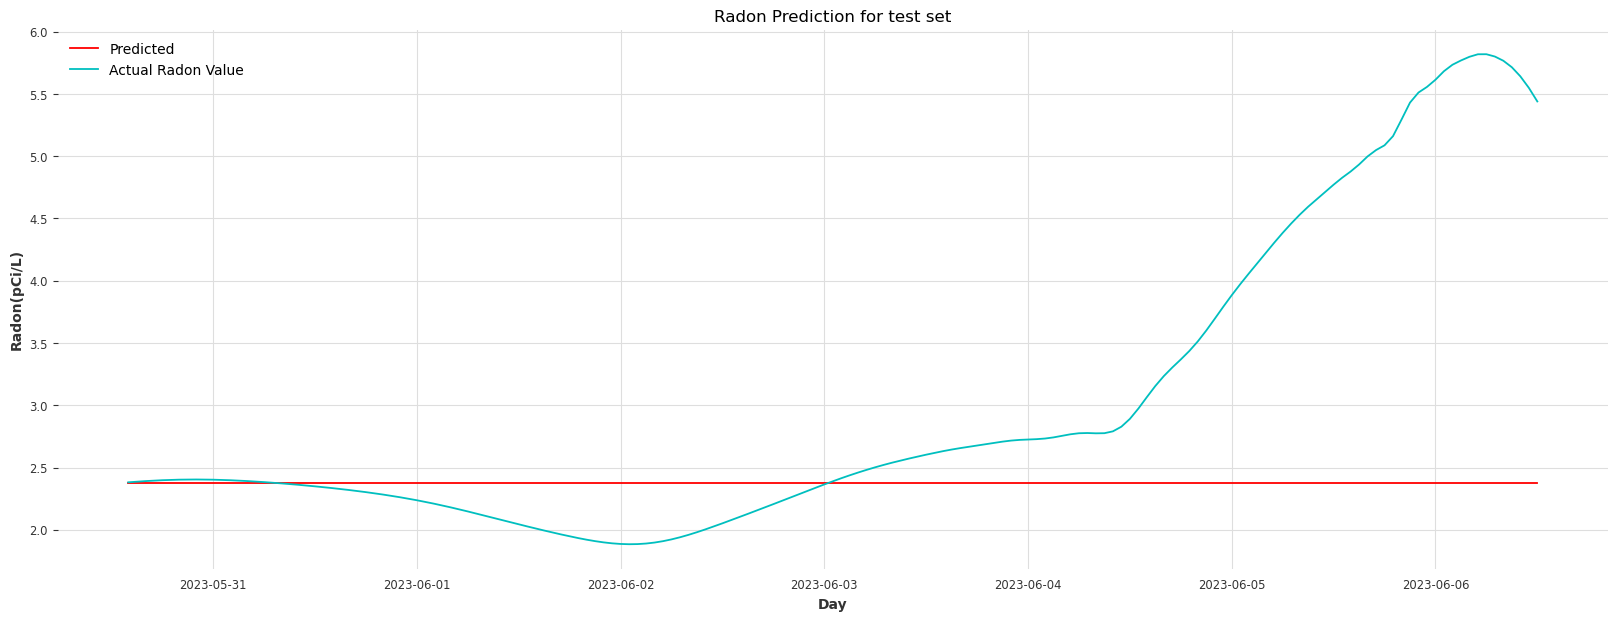

In [33]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
plt.plot(dfY.index, dfY['Predicted'], color='r', label='Predicted')
plt.plot(dfY.index, dfY['Actual'], color='c', label='Actual Radon Value')
plt.legend()
plt.title('Radon Prediction for test set')
plt.xlabel('Day')
plt.ylabel('Radon(pCi/L)')
plt.show()